# Analyse Exploratoire

### Import des modules

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import matplotlib.pyplot as plt
import re
import numpy as np

### Analyse Exploratoire

**Objectif de la modélisation**  

*Contexte métier*  

L’objectif de ce projet est de prédire la consommation énergétique normalisée d’un bâtiment (SiteEnergyUseWN) à partir de caractéristiques structurelles, d’usage et de consommation partielle, tout en garantissant la robustesse et la généralisabilité du modèle.  

*Objectif technique*

Nous cherchons à :  

- Construire un modèle de régression performant  

- Comparer plusieurs familles d’algorithmes  

- Sélectionner le meilleur modèle selon des métriques adaptées  

- Optimiser ses hyperparamètres  

- Identifier les variables les plus influentes  

In [2]:
building_consumption = pd.read_csv("building_energy_benchmarking.csv")

In [3]:
# On regarde comment un batiment est défini dans ce jeu de données 
building_consumption.head()

OSEBuildingID  DataYear    BuildingType PrimaryPropertyType  \
0              1      2016  NonResidential               Hotel   
1              2      2016  NonResidential               Hotel   
2              3      2016  NonResidential               Hotel   
3              5      2016  NonResidential               Hotel   
4              8      2016  NonResidential               Hotel   

                  PropertyName          Address     City State  ZipCode  \
0         Mayflower park hotel    405 Olive way  Seattle    WA  98101.0   
1              Paramount Hotel  724 Pine street  Seattle    WA  98101.0   
2      5673-The Westin Seattle  1900 5th Avenue  Seattle    WA  98101.0   
3                    HOTEL MAX   620 STEWART ST  Seattle    WA  98101.0   
4  WARWICK SEATTLE HOTEL (ID8)    401 LENORA ST  Seattle    WA  98121.0   

  TaxParcelIdentificationNumber  ...  Electricity(kWh) Electricity(kBtu)  \
0                    0659000030  ...      1.156514e+06         3946027.0   
1                    0659000220  ...      9.504252e+05         3242851.0   
2                    0659000475  ...      1.451544e+07        49526664.0   
3                    0659000640  ...      8.115253e+05         2768924.0   
4                    0659000970  ...      1.573449e+06         5368607.0   

   NaturalGas(therms)  NaturalGas(kBtu)  DefaultData  Comments  \
0         12764.52930         1276453.0        False       NaN   
1         51450.81641         5145082.0        False       NaN   
2         14938.00000         1493800.0        False       NaN   
3         18112.13086         1811213.0        False       NaN   
4         88039.98438         8803998.0        False       NaN   

   ComplianceStatus  Outlier  TotalGHGEmissions  GHGEmissionsIntensity  
0         Compliant      NaN             249.98                   2.83  
1         Compliant      NaN             295.86                   2.86  
2         Compliant      NaN            2089.28                   2.19  
3         Compliant      NaN             286.43                   4.67  
4         Compliant      NaN             505.01                   2.88  

[5 rows x 46 columns]

In [4]:
building_consumption.shape

(3376, 46)

On peut voir que la source contient **3376 bâtiments** et **46 colonnes** donnant des informations sur ces bâtiments.

## Préparation du DF de travail

#### Inspection du DF de base

In [5]:
# On regarde le nombre de valeurs manquantes par colonne ainsi que leur type 
building_consumption.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3376 non-null   int64  
 1   DataYear                         3376 non-null   int64  
 2   BuildingType                     3376 non-null   object 
 3   PrimaryPropertyType              3376 non-null   object 
 4   PropertyName                     3376 non-null   object 
 5   Address                          3376 non-null   object 
 6   City                             3376 non-null   object 
 7   State                            3376 non-null   object 
 8   ZipCode                          3360 non-null   float64
 9   TaxParcelIdentificationNumber    3376 non-null   object 
 10  CouncilDistrictCode              3376 non-null   int64  
 11  Neighborhood                     3376 non-null   object 
 12  Latitude            

In [6]:
building_consumption["DataYear"].nunique()


1

In [7]:
building_consumption["City"].nunique()

1

In [8]:
building_consumption["State"].nunique()

1

In [9]:
building_consumption["Comments"].nunique()

0

In [10]:
building_consumption["CouncilDistrictCode"].nunique()

7

In [11]:
building_consumption["ZipCode"].nunique()

55

In [12]:
building_consumption_clean = building_consumption.copy()

On peut supprimer les colonnes **DataYear**, **City**, **State** car elles ont toutes la même valeur. et **Comments** car il n'a pas de valeur.

In [13]:
building_consumption_clean = building_consumption_clean.drop(["DataYear", "City", "State", "Comments"], axis=1)


La latitude et la longitude n'ont pas d'impact dans notre projet étant donné que l'on a le quartier dans lequel se situe le bâitment.

In [14]:
building_consumption_clean = building_consumption_clean.drop(["Latitude", "Longitude"], axis=1)

In [15]:
building_consumption["Neighborhood"].value_counts()

Neighborhood
DOWNTOWN                  573
EAST                      453
MAGNOLIA / QUEEN ANNE     423
GREATER DUWAMISH          375
NORTHEAST                 280
LAKE UNION                251
NORTHWEST                 210
SOUTHWEST                 166
NORTH                     145
BALLARD                   126
CENTRAL                   107
SOUTHEAST                  95
DELRIDGE                   80
North                      42
Central                    27
Northwest                  11
Ballard                     7
Delridge                    4
DELRIDGE NEIGHBORHOODS      1
Name: count, dtype: int64

 On remarque qu'il y a également des quartiers en doublons car ils n'ont pas la même orthographe ( Majuscule, Minuscule). On va donc commencer par uniformiser les valeurs.

In [16]:
building_consumption_clean["Neighborhood"] = (
    building_consumption_clean["Neighborhood"].replace({
        'Central': 'CENTRAL',
        'North': 'NORTH',
        'Northwest': 'NORTHWEST',
        'Ballard': 'BALLARD',
        'Delridge': 'DELRIDGE',
        'DELRIDGE NEIGHBOHORDOODS': 'DELRIDGE'
    })
)


On peut également supprimer l'**adresse**, le **ZipCode**, le **TaxParcelIdentificationNumber** et **CouncilDistrictCode** car on a le quartier.

In [17]:
building_consumption_clean = building_consumption_clean.drop(["Address", "ZipCode", "TaxParcelIdentificationNumber", "CouncilDistrictCode"], axis=1)


In [18]:
building_consumption["BuildingType"].value_counts()

BuildingType
NonResidential          1460
Multifamily LR (1-4)    1018
Multifamily MR (5-9)     580
Multifamily HR (10+)     110
SPS-District K-12         98
Nonresidential COS        85
Campus                    24
Nonresidential WA          1
Name: count, dtype: int64

Comme on cherche uniquement les bâtiments non-résidentiels, on ne choisit que NonResidential & Nonresidential COS

In [19]:
building_consumption_clean = building_consumption_clean[
    building_consumption_clean["BuildingType"].isin(["NonResidential","Nonresidential COS"])
]

#### Comparer les unités d'énergies

In [20]:
building_consumption_clean[
    ((building_consumption_clean["NaturalGas(therms)"].isna()) | 
     (building_consumption_clean["NaturalGas(therms)"] == 0)) &
    ((building_consumption_clean["NaturalGas(kBtu)"].notna()) & 
     (building_consumption_clean["NaturalGas(kBtu)"] != 0))
][["BuildingType", "NaturalGas(therms)","NaturalGas(kBtu)"]]

Empty DataFrame
Columns: [BuildingType, NaturalGas(therms), NaturalGas(kBtu)]
Index: []

In [21]:
building_consumption_clean[
    ((building_consumption_clean["Electricity(kWh)"].isna()) | 
     (building_consumption_clean["Electricity(kWh)"] == 0)) &
    ((building_consumption_clean["Electricity(kBtu)"].notna()) & 
     (building_consumption_clean["Electricity(kBtu)"] != 0))
][["BuildingType", "Electricity(kWh)", "Electricity(kBtu)"]]

Empty DataFrame
Columns: [BuildingType, Electricity(kWh), Electricity(kBtu)]
Index: []

Toutes les colonnes ayant des valeurs en **therms** ou en **kWh** on leur équivalent en **kBtu**. On va donc supprimer ces colonnes.

In [22]:
building_consumption_clean = building_consumption_clean.drop(["Electricity(kWh)", "NaturalGas(therms)"], axis=1)

In [23]:
building_consumption_clean.shape

(1545, 34)

Nous avons donc plus que **1545 bâtiments** et **34 colonnes** d'informations.

#### Données diverses

In [24]:
building_consumption_clean["YearsENERGYSTARCertified"].value_counts()

YearsENERGYSTARCertified
2016                                5
2017                                5
20162015                            4
2009                                4
2013                                4
                                   ..
20172015201420132011                1
20152012                            1
201620152014                        1
20162015201420132012201020092008    1
20162015201020092008                1
Name: count, Length: 64, dtype: int64

In [25]:
building_consumption_clean["YearsENERGYSTARCertified"] = (
    building_consumption_clean["YearsENERGYSTARCertified"]
    .astype(str)
    .apply(lambda x: re.findall(r"\d{4}", x)[0] if re.findall(r"\d{4}", x) else None)
)

In [26]:
building_consumption_clean["YearsENERGYSTARCertified"].value_counts()

YearsENERGYSTARCertified
2016    33
2017    27
2009     6
2014     5
2015     5
2010     4
2013     4
2012     3
2011     3
2007     1
Name: count, dtype: int64

#### DefaultData

**DefaultData** : Données estimées ou réelles

In [27]:
building_consumption_clean["DefaultData"].value_counts()

DefaultData
False    1532
True       13
Name: count, dtype: int64

#### Compliance Status

**ComplianceStatus** : Conformité réglementaire du bâtiment

In [28]:
building_consumption_clean["ComplianceStatus"].value_counts()


ComplianceStatus
Compliant                       1513
Non-Compliant                     18
Error - Correct Default Data      13
Missing Data                       1
Name: count, dtype: int64

In [29]:
building_consumption_clean[building_consumption_clean["ComplianceStatus"] == "Error - Correct Default Data"]

OSEBuildingID        BuildingType          PrimaryPropertyType  \
276             405      NonResidential                 Large Office   
457             618      NonResidential  Small- and Mid-Sized Office   
1045          20617      NonResidential                 Retail Store   
1466          21898      NonResidential                    Warehouse   
1467          21902      NonResidential                    Warehouse   
1641          22953      NonResidential                 Retail Store   
1656          23011      NonResidential                 Retail Store   
1977          24030      NonResidential                 Retail Store   
2076          24374      NonResidential                 Retail Store   
2682          26593      NonResidential  Small- and Mid-Sized Office   
3366          50210  Nonresidential COS                       Office   
3369          50220  Nonresidential COS                       Office   
3371          50222  Nonresidential COS                       Office   

                      PropertyName           Neighborhood  YearBuilt  \
276                    The Decatur               DOWNTOWN       1921   
457                    Prefontaine               DOWNTOWN       1909   
1045         Seattle Habitat Store       GREATER DUWAMISH       1953   
1466          Halfon Candy Company       GREATER DUWAMISH       1978   
1467                        Samson       GREATER DUWAMISH       1979   
1641                      Tux Shop                  NORTH       1965   
1656                         Bevmo                  NORTH       1966   
1977               King Plaza 6951       GREATER DUWAMISH       2002   
2076      Jumbo chinese restaurant              SOUTHEAST       1968   
2682               Delmar Building               DOWNTOWN       1900   
3366  Central West HQ / Brown Bear  MAGNOLIA / QUEEN ANNE       1952   
3369              Genesee/SC SE HQ              SOUTHEAST       1960   
3371         Horticulture building       GREATER DUWAMISH       1990   

      NumberofBuildings  NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
276                 1.0               4            127268                   0   
457                 1.0               6             73470                   0   
1045                1.0               1             39900                   0   
1466                1.0               1             31300                   0   
1467                1.0               1             22000                   0   
1641                1.0               1             24982                   0   
1656                1.0               1             41615                   0   
1977                1.0               2             54211               17471   
2076                1.0               1             36071                   0   
2682                1.0               4             22840                   0   
3366                1.0               1             13661                   0   
3369                1.0               1             15398                   0   
3371                1.0               1             12294                   0   

      ...  SiteEnergyUse(kBtu) SiteEnergyUseWN(kBtu) SteamUse(kBtu)  \
276   ...         7.711758e+06          7.711758e+06    714523.6875   
457   ...         3.212269e+06          3.408134e+06         0.0000   
1045  ...         1.454688e+05          1.454688e+05         0.0000   
1466  ...         3.628740e+05          3.984386e+05         0.0000   
1467  ...         7.006276e+05          7.006276e+05         0.0000   
1641  ...         3.352450e+05          3.352450e+05         0.0000   
1656  ...         1.900006e+06          2.001297e+06         0.0000   
1977  ...         1.267463e+06          1.267463e+06         0.0000   
2076  ...         1.519952e+06          1.519952e+06         0.0000   
2682  ...         8.813862e+05          9.830534e+05         0.0000   
3366  ...         5.026677e+05          5.585251e+05         0.0000   
3

Ces bâtiment ont beaucoup de données. On va donc les garder.

In [30]:
building_consumption_clean[building_consumption_clean["ComplianceStatus"] == "Missing Data"]

OSEBuildingID    BuildingType PrimaryPropertyType  \
746          19776  NonResidential               Other   

                       PropertyName Neighborhood  YearBuilt  \
746  Welcome Home Society - PriceCo    NORTHWEST       2002   

     NumberofBuildings  NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
746                1.0               1             29924                   0   

     ...  SiteEnergyUse(kBtu) SiteEnergyUseWN(kBtu) SteamUse(kBtu)  \
746  ...                  0.0                   0.0            0.0   

     Electricity(kBtu) NaturalGas(kBtu)  DefaultData ComplianceStatus  \
746                0.0              0.0        False     Missing Data   

     Outlier TotalGHGEmissions  GHGEmissionsIntensity  
746      NaN               0.0                    0.0  

[1 rows x 34 columns]

On peut supprimer ces lignes qui ont trop de valeurs manquantes.

In [31]:
building_consumption_clean = building_consumption_clean.drop([746], axis=0)

In [32]:
building_consumption_clean[building_consumption_clean["ComplianceStatus"] == "Non-Compliant"]

OSEBuildingID        BuildingType          PrimaryPropertyType  \
226             350      NonResidential                 Large Office   
304             435      NonResidential                        Other   
384             539      NonResidential                 Retail Store   
448             608      NonResidential                 Large Office   
517             704      NonResidential                 Large Office   
578             773      NonResidential  Small- and Mid-Sized Office   
1229          21315      NonResidential  Small- and Mid-Sized Office   
1295          21474      NonResidential                        Other   
1611          22830      NonResidential             Worship Facility   
1945          23912      NonResidential  Small- and Mid-Sized Office   
2129          24547      NonResidential                  K-12 School   
2189          24717      NonResidential                        Other   
2216          24825      NonResidential  Small- and Mid-Sized Office   
2410          25553      NonResidential                        Hotel   
2450          25674      NonResidential         Low-Rise Multifamily   
2670          26532      NonResidential           Mixed Use Property   
2801          27007      NonResidential             Worship Facility   
3152          43948  Nonresidential COS                        Other   

                            PropertyName           Neighborhood  YearBuilt  \
226           Second And Spring Building               DOWNTOWN       1958   
304   Washington State Convention Center               DOWNTOWN       1990   
384                    University Center              NORTHEAST       1987   
448               411 1ST AVE  S (ID608)               DOWNTOWN       1913   
517                 401 Elliott Ave West  MAGNOLIA / QUEEN ANNE       2000   
578                     SEATTLE BUILDING               DOWNTOWN       1924   
1229                     1518 Fifith Ave               DOWNTOWN       1903   
1295                      The Lusty Lady               DOWNTOWN       1900   
1611                      Freedom Church              SOUTHWEST       1971   
1945                      1416 S Jackson                CENTRAL       1947   
2129           Islamic School of Seattle                CENTRAL       1929   
2189            1701 First Ave South LLC       GREATER DUWAMISH       1910   
2216                       2233 Building       GREATER DUWAMISH       1910   
2410      J & M HOTEL BUILDING (ID25553)               DOWNTOWN       1900   
2450              (ID25674) COMET TAVERN                   EAST       1910   
2670                    KALBERG BUILDING              NORTHEAST       1928   
2801            Seattle Community Church              NORTHEAST       1954   
3152               Georgetown Steamplant       GREATER DUWAMISH       1906   

      NumberofBuildings  NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
226                 1.0               6            172842               25920   
304                 1.0               6           1400000                   0   
384                 1.0               2             69492                   0   
448                 5.0               7            154159                   0   
517                 1.0               4            129551               42500   
578                 NaN               4             63150                   0   
1229                1.0               3             57720                   0   
1295                1.0               3             49760                   0   
1611                1.0               1             23772                   0   
1945                1.0               1             45068                   0   
2129                1.0               2             24152                   0   
2189                1.0               3             27690                   0   
2216                1.0               2             20970                   0   
2410                

#### Outlier

In [33]:
building_consumption_clean["Outlier"].value_counts()

Outlier
Low outlier     14
High outlier     2
Name: count, dtype: int64

In [34]:
building_consumption_clean[
    building_consumption_clean["Outlier"].isin(["Low outlier"])
]["ListOfAllPropertyUseTypes"]

384                                 Retail Store
448                                       Office
1045    Non-Refrigerated Warehouse, Retail Store
1229                                      Office
1295                                       Other
1611                            Worship Facility
1945                                      Office
2129                                 K-12 School
2189                              Other, Parking
2216                             Office, Parking
2410                                       Hotel
2450          Bar/Nightclub, Multifamily Housing
2801                            Worship Facility
3152                                       Other
Name: ListOfAllPropertyUseTypes, dtype: object

In [35]:
building_consumption_clean[
    building_consumption_clean["Outlier"].isin(["High outlier"])
]["ListOfAllPropertyUseTypes"]

226    Data Center, Office, Parking
517    Data Center, Office, Parking
Name: ListOfAllPropertyUseTypes, dtype: object

Il est normal que les valeurs de **High Outlier** soit des **Data Center** car leur consommation énergétique est très importante.

#### Données mise à jour avec la météo

On va vérifie que tous les bâtiments ont des valeurs normalisées via la météo

In [36]:
building_consumption_clean[
    (building_consumption_clean["SiteEUIWN(kBtu/sf)"].isna() | 
     (building_consumption_clean["SiteEUIWN(kBtu/sf)"] == 0))
][["BuildingType", "SiteEUIWN(kBtu/sf)", "SiteEUI(kBtu/sf)"]]


BuildingType  SiteEUIWN(kBtu/sf)  SiteEUI(kBtu/sf)
220   NonResidential                 0.0        105.199997
247   NonResidential                 0.0         73.000000
284   NonResidential                 0.0         43.400002
304   NonResidential                 0.0               NaN
350   NonResidential                 0.0         50.000000
563   NonResidential                 NaN         39.500000
578   NonResidential                 NaN               NaN
882   NonResidential                 0.0         20.700001
953   NonResidential                 0.0         37.599998
2670  NonResidential                 NaN               NaN
3275  NonResidential                 0.0         85.099998
3277  NonResidential                 0.0        252.000000

Nous avons quelques valeurs qui ne tiennent pas en compte les valeurs de la météo mais contiennent des valeurs qui n'en tiennent pas compte. On va donc regarder plus en détail ces trois bâtiments.

In [37]:
building_consumption_clean.loc[[304, 578, 2670]]

OSEBuildingID    BuildingType          PrimaryPropertyType  \
304             435  NonResidential                        Other   
578             773  NonResidential  Small- and Mid-Sized Office   
2670          26532  NonResidential           Mixed Use Property   

                            PropertyName Neighborhood  YearBuilt  \
304   Washington State Convention Center     DOWNTOWN       1990   
578                     SEATTLE BUILDING     DOWNTOWN       1924   
2670                    KALBERG BUILDING    NORTHEAST       1928   

      NumberofBuildings  NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
304                 1.0               6           1400000                   0   
578                 NaN               4             63150                   0   
2670                NaN               2             20760                   0   

      ...  SiteEnergyUse(kBtu) SiteEnergyUseWN(kBtu) SteamUse(kBtu)  \
304   ...                  0.0                   0.0            0.0   
578   ...                  NaN                   NaN            NaN   
2670  ...                  NaN                   NaN            NaN   

      Electricity(kBtu) NaturalGas(kBtu)  DefaultData ComplianceStatus  \
304                 0.0              0.0        False    Non-Compliant   
578                 NaN              NaN        False    Non-Compliant   
2670                NaN              NaN        False    Non-Compliant   

      Outlier TotalGHGEmissions  GHGEmissionsIntensity  
304       NaN               0.0                    0.0  
578       NaN               NaN                    NaN  
2670      NaN               NaN                    NaN  

[3 rows x 34 columns]

Ces bâtiments n'ayant pas assez de données exploitables, on peut les supprimer.

In [38]:
building_consumption_clean = building_consumption_clean.drop([304, 578, 2670], axis=0)

In [39]:
building_consumption_clean.shape

(1541, 34)

Nous avons donc **1541** bâtiments.

#### Détail des valeurs vides

In [40]:
# Colonnes pour lesquelles il est important qu'il y ait des valeurs.

cols_to_check = [
    "SiteEUIWN(kBtu/sf)",
    "SiteEnergyUse(kBtu)",
    "SiteEnergyUseWN(kBtu)",
    "SteamUse(kBtu)",
    "Electricity(kBtu)",
    "NaturalGas(kBtu)"
]


Vérifiez qu'il existe ou nous des lignes où toutes les valeurs sont égales à 0 ou NaN

In [41]:
building_consumption_clean[
    building_consumption_clean[cols_to_check].isna().all(axis=1) |   
    (building_consumption_clean[cols_to_check] == 0).all(axis=1)   
]

Empty DataFrame
Columns: [OSEBuildingID, BuildingType, PrimaryPropertyType, PropertyName, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ListOfAllPropertyUseTypes, LargestPropertyUseType, LargestPropertyUseTypeGFA, SecondLargestPropertyUseType, SecondLargestPropertyUseTypeGFA, ThirdLargestPropertyUseType, ThirdLargestPropertyUseTypeGFA, YearsENERGYSTARCertified, ENERGYSTARScore, SiteEUI(kBtu/sf), SiteEUIWN(kBtu/sf), SourceEUI(kBtu/sf), SourceEUIWN(kBtu/sf), SiteEnergyUse(kBtu), SiteEnergyUseWN(kBtu), SteamUse(kBtu), Electricity(kBtu), NaturalGas(kBtu), DefaultData, ComplianceStatus, Outlier, TotalGHGEmissions, GHGEmissionsIntensity]
Index: []

[0 rows x 34 columns]

Il n'y a aucun bâtiments qui ne contient des valeurs vides.

#### Matrice de corrélation de Pearson

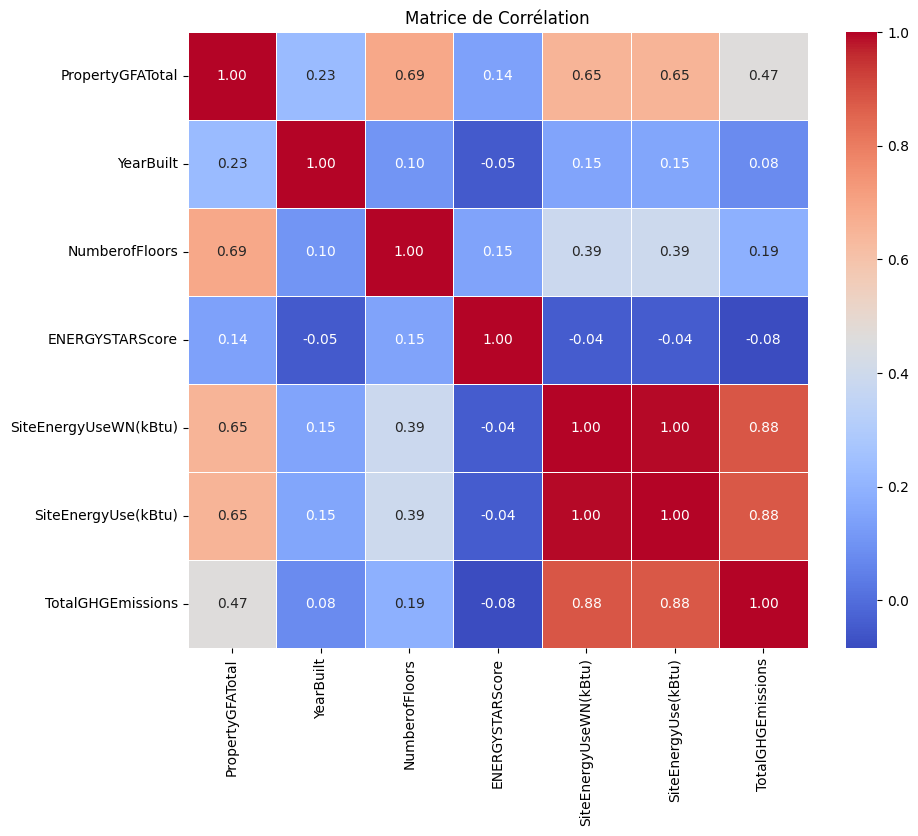

In [42]:
colonnes_correlation = [
    'PropertyGFATotal', 
    'YearBuilt', 
    'NumberofFloors',
    'ENERGYSTARScore', 
    'SiteEnergyUseWN(kBtu)', 
    'SiteEnergyUse(kBtu)', 
    'TotalGHGEmissions'
]

df_corr = building_consumption_clean[colonnes_correlation].copy()

# 2. Calcul de la matrice de corrélation
matrice_corr = df_corr.corr(method='pearson')

# 3. Visualisation (Heatmap)
plt.figure(figsize=(10, 8))
sns.heatmap(
    matrice_corr, 
    annot=True, 
    cmap='coolwarm', 
    fmt=".2f",
    linewidths=.5,
)
plt.title('Matrice de Corrélation')
plt.show()

#### Consommation énergétique en fonction du voisinage

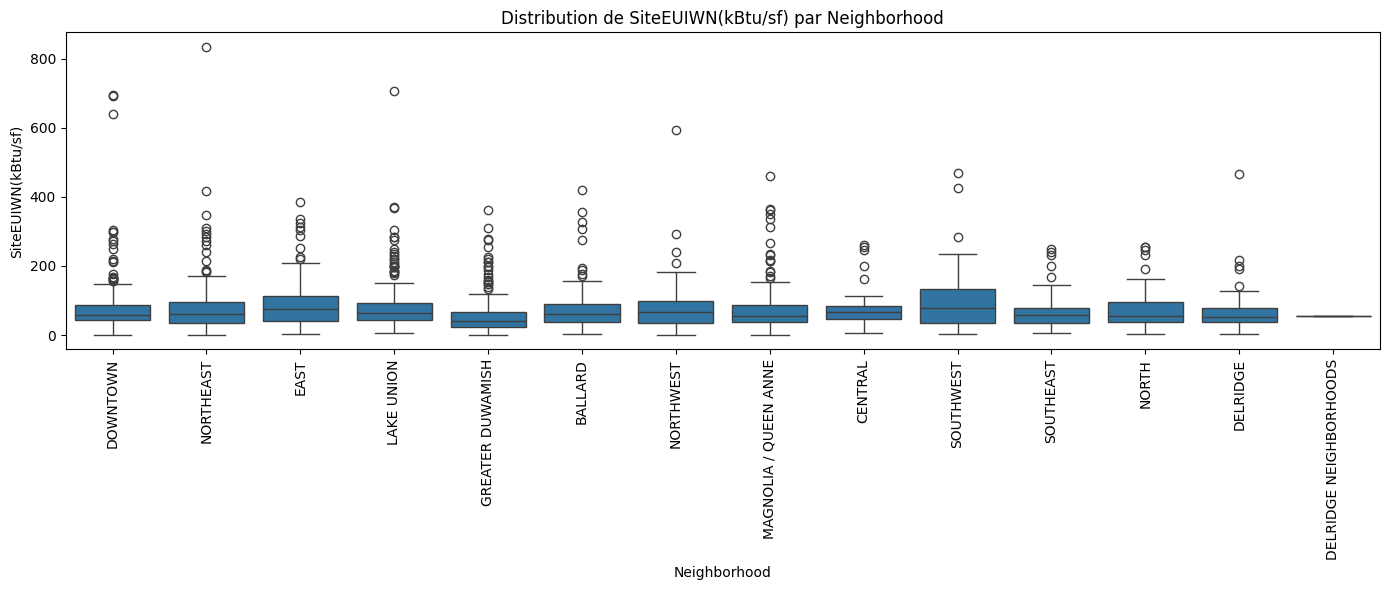

In [43]:
plt.figure(figsize=(14, 6))
sns.boxplot(
    data=building_consumption_clean,
    x="Neighborhood",
    y="SiteEUIWN(kBtu/sf)"
)

plt.xticks(rotation=90)
plt.title("Distribution de SiteEUIWN(kBtu/sf) par Neighborhood")
plt.xlabel("Neighborhood")
plt.ylabel("SiteEUIWN(kBtu/sf)")
plt.tight_layout()
plt.show()

La consommation par surface suivant les quartiers semble équivalente à l'exception de quelques outliers.

#### Lien entre l'année de construction et la consommation énergétique

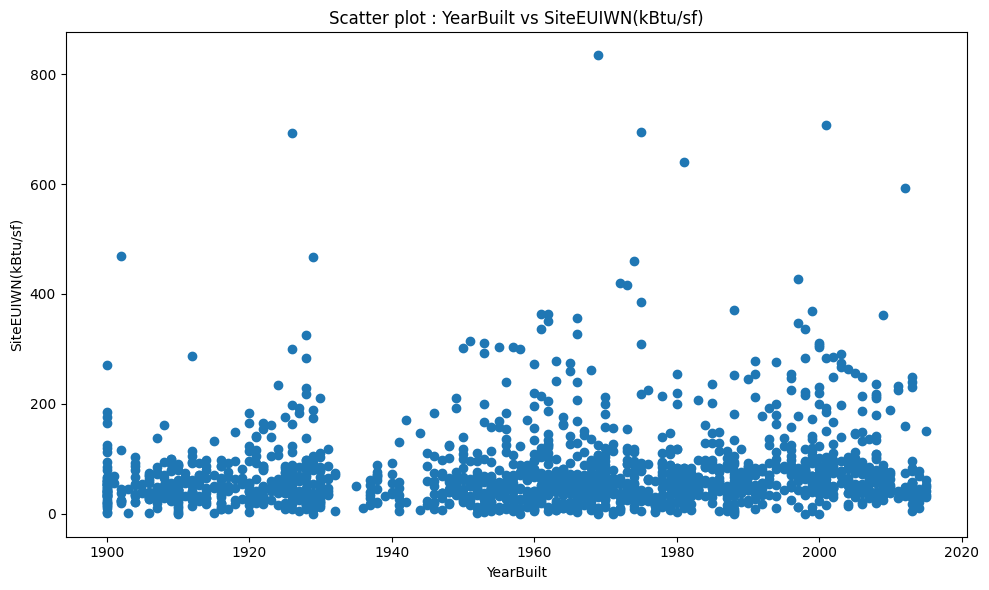

In [44]:

df = building_consumption_clean.copy()

plt.figure(figsize=(10,6))
plt.scatter(df["YearBuilt"], df["SiteEUIWN(kBtu/sf)"])

plt.xlabel("YearBuilt")
plt.ylabel("SiteEUIWN(kBtu/sf)")
plt.title("Scatter plot : YearBuilt vs SiteEUIWN(kBtu/sf)" )

plt.tight_layout()
plt.show()

On ne peut pas déduire de lien entre l'année de construction et la consommation énergétique

#### Lien entre la consommation énergétique & celle mise à jour via la météo

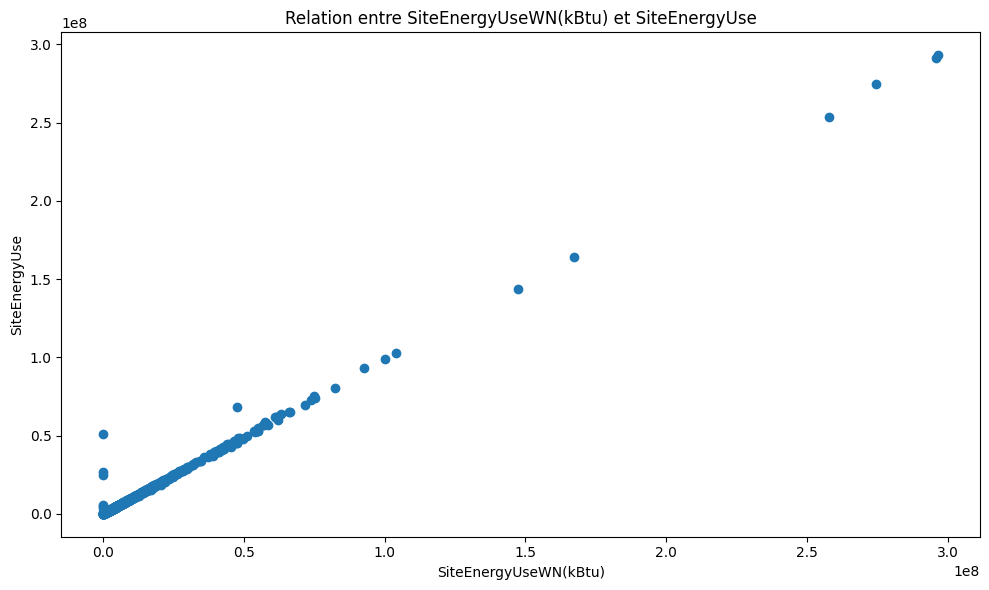

In [45]:

plt.figure(figsize=(10,6))
plt.scatter(df["SiteEnergyUseWN(kBtu)"], df["SiteEnergyUse(kBtu)"])

plt.xlabel("SiteEnergyUseWN(kBtu)")
plt.ylabel("SiteEnergyUse")
plt.title("Relation entre SiteEnergyUseWN(kBtu) et SiteEnergyUse")

plt.tight_layout()
plt.show()

Au vu de la courbe, on peut déduire qu'il y a un **lien (ratio)** entre SiteEnergyUse et SiteEnergyUseWN

In [46]:
df = building_consumption_clean.copy()

clean_df = df[["SiteEnergyUseWN(kBtu)", "SiteEnergyUse(kBtu)"]].copy()

clean_df["SiteEnergyUseWN(kBtu)"].replace(0, np.nan, inplace=True)

clean_df["ratio"] = clean_df["SiteEnergyUse(kBtu)"] / clean_df["SiteEnergyUseWN(kBtu)"]

clean_df = clean_df.dropna(subset=["ratio"])

mean_ratio = clean_df["ratio"].mean()
mean_ratio

C:\Users\mcourte\AppData\Local\Temp\ipykernel_19884\3185432864.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  clean_df["SiteEnergyUseWN(kBtu)"].replace(0, np.nan, inplace=True)


np.float64(0.9539660875649302)

In [47]:
ratio = 0.95

**Mise à jour du DF avec ce ratio pour remplir toutes les lignes**

In [48]:
building_consumption_clean.loc[
    (building_consumption_clean["SiteEnergyUse(kBtu)"].isna() | (building_consumption_clean["SiteEnergyUse(kBtu)"] == 0)) &
    (building_consumption_clean["SiteEnergyUseWN(kBtu)"].notna() & (building_consumption_clean["SiteEnergyUseWN(kBtu)"] != 0)),
    "SiteEnergyUse(kBtu)"
] = building_consumption_clean["SiteEnergyUseWN(kBtu)"] * ratio

In [49]:
building_consumption_clean.loc[
    (building_consumption_clean["SiteEnergyUseWN(kBtu)"].isna() | (building_consumption_clean["SiteEnergyUseWN(kBtu)"] == 0)) &
    (building_consumption_clean["SiteEnergyUse(kBtu)"].notna() & (building_consumption_clean["SiteEnergyUse(kBtu)"] != 0)),
    "SiteEnergyUseWN(kBtu)"
] = building_consumption_clean["SiteEnergyUse(kBtu)"] / ratio

#### Lien entre la consommation énergétique et la surface totale

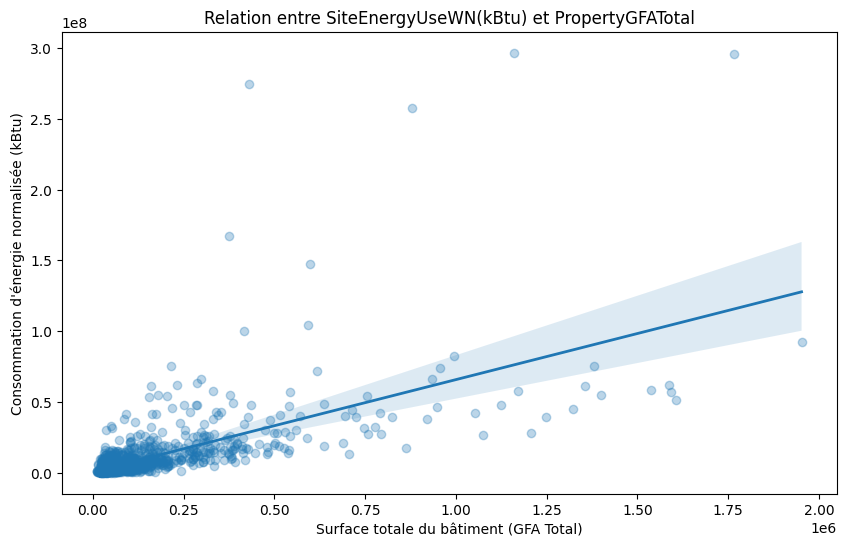

In [50]:
plt.figure(figsize=(10, 6))
sns.regplot(
    data=building_consumption_clean,
    x="PropertyGFATotal",
    y="SiteEnergyUseWN(kBtu)",
    scatter_kws={"alpha": 0.3},
    line_kws={"linewidth": 2}
)

plt.title("Relation entre SiteEnergyUseWN(kBtu) et PropertyGFATotal")
plt.xlabel("Surface totale du bâtiment (GFA Total)")
plt.ylabel("Consommation d'énergie normalisée (kBtu)")
plt.show()

Ce graphique nous permet de voir qu'il existe un lien entre la consommation énergétique et la surface du bâtiment

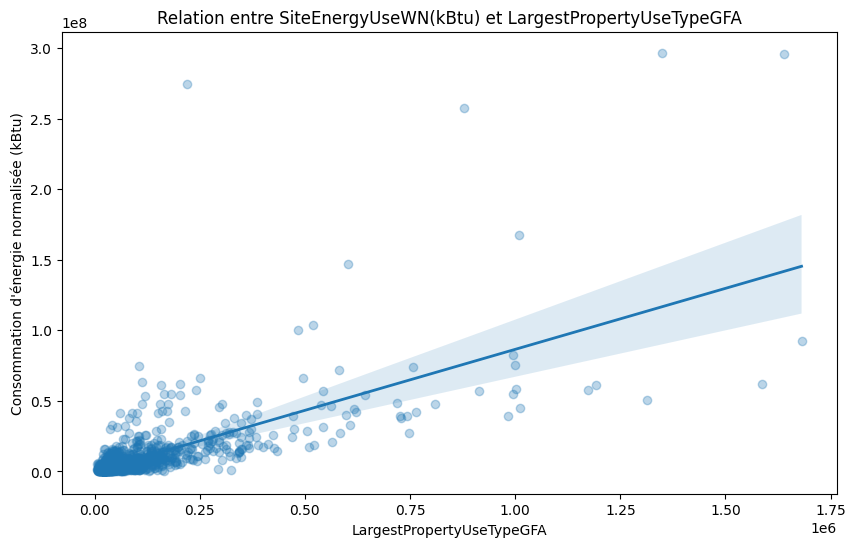

In [51]:
plt.figure(figsize=(10, 6))
sns.regplot(
    data=building_consumption_clean,
    x="LargestPropertyUseTypeGFA",
    y="SiteEnergyUseWN(kBtu)",
    scatter_kws={"alpha": 0.3},
    line_kws={"linewidth": 2}
)

plt.title("Relation entre SiteEnergyUseWN(kBtu) et LargestPropertyUseTypeGFA")
plt.xlabel("LargestPropertyUseTypeGFA")
plt.ylabel("Consommation d'énergie normalisée (kBtu)")
plt.show()

On retrouve également un lien entre la surface de l'usage principal du bâtiment et sa consommation énergétique.

##### Les Outliers

In [52]:

x_col = 'LargestPropertyUseTypeGFA'
y_col = 'SiteEnergyUseWN(kBtu)'

# On analyse à partir du 95ème quantile.

q95_x = df[x_col].quantile(0.95)
q95_y = df[y_col].quantile(0.95)

outlier_filter = (df[x_col] > q95_x) | (df[y_col] > q95_y)

df_outliers= df[outlier_filter].copy()

# Colonnes descriptives pertinentes
columns_to_check = [
    'BuildingType', 
    'LargestPropertyUseType', 
    'Neighborhood', 
    'PropertyGFATotal',
    'PropertyGFAParking',
    'PropertyGFABuilding(s)',
    'NumberofFloors',
    x_col, 
    y_col
]
df_outliers_caracteristiques = df_outliers[columns_to_check].sort_values(by=y_col, ascending=False)

In [53]:
df_outliers_caracteristiques.head(10)

BuildingType                 LargestPropertyUseType Neighborhood  \
170   NonResidential  Hospital (General Medical & Surgical)         EAST   
618   NonResidential  Hospital (General Medical & Surgical)         EAST   
558   NonResidential                            Data Center     DOWNTOWN   
124   NonResidential  Hospital (General Medical & Surgical)    NORTHEAST   
3264  NonResidential  Hospital (General Medical & Surgical)         EAST   
167   NonResidential  Hospital (General Medical & Surgical)      CENTRAL   
1690  NonResidential                         Medical Office         EAST   
1672  NonResidential  Hospital (General Medical & Surgical)    NORTHWEST   
559   NonResidential                                 Office     DOWNTOWN   
49    NonResidential                                  Hotel     DOWNTOWN   

      PropertyGFATotal  PropertyGFAParking  PropertyGFABuilding(s)  \
170            1158691                   0                 1158691   
618            1765970                   0                 1765970   
558             429405                   0                  429405   
124             879000                   0                  879000   
3264            374466                   0                  374466   
167             597519                   0                  597519   
1690            591981                   0                  591981   
1672            415632                   0                  415632   
559            1952220              319400                 1632820   
49              994212              146694                  847518   

      NumberofFloors  LargestPropertyUseTypeGFA  SiteEnergyUseWN(kBtu)  
170                8                  1350182.0            296671744.0  
618               14                  1639334.0            295929888.0  
558               33                   218997.0            274725984.0  
124               10                   879000.0            257764208.0  
3264               8                  1010135.0            167207104.0  
167                5                   601615.0            147299056.0  
1690               3                   520187.0            103985264.0  
1672               1                   483520.0            100328264.0  
559               76                  1680937.0             92537256.0  
49                34                   994212.0             82318072.0

On remarque que les bâtiments consommant énormément sont des hôpitaux, des datas center, et des bueaux & hôtels avec de nombreux étages.

#### Relation entre l'émission de gaz à effet de serre et la surface des bâtiments

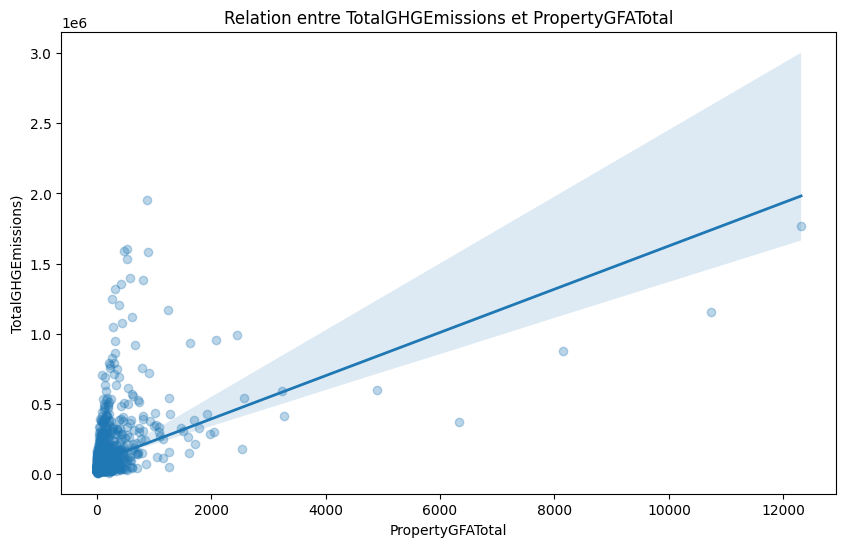

In [54]:
plt.figure(figsize=(10, 6))
sns.regplot(
    data=building_consumption_clean,
    x="TotalGHGEmissions",
    y="PropertyGFATotal",
    scatter_kws={"alpha": 0.3},
    line_kws={"linewidth": 2}
)

plt.title("Relation entre TotalGHGEmissions et PropertyGFATotal")
plt.xlabel("PropertyGFATotal")
plt.ylabel("TotalGHGEmissions)")
plt.show()

Comment pour la consommation énergétique, il existe une corrélation entre la surface du bâtiment et l'emission de gaz.

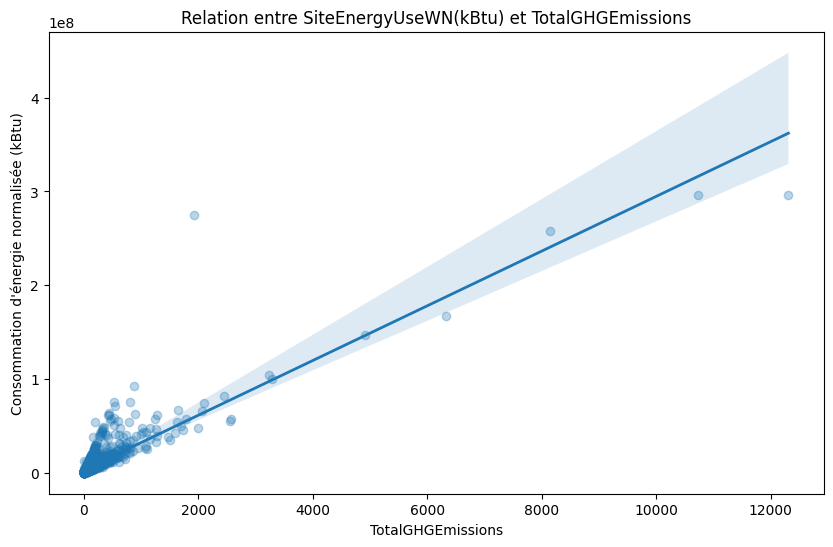

In [55]:
plt.figure(figsize=(10, 6))
sns.regplot(
    data=building_consumption_clean,
    x="TotalGHGEmissions",
    y="SiteEnergyUseWN(kBtu)",
    scatter_kws={"alpha": 0.3},
    line_kws={"linewidth": 2}
)

plt.title("Relation entre SiteEnergyUseWN(kBtu) et TotalGHGEmissions")
plt.xlabel("TotalGHGEmissions")
plt.ylabel("Consommation d'énergie normalisée (kBtu)")
plt.show()

Ce graphique nous permet de confirmer le lien entre la consommation énergétique et l'émission de gaz.

Pour faciliter nos calculs futurs, on ajoute un rapport entre la consommation et la surface, on rajoute une colonne SiteEnergyUseWN(kBtu/sf)

In [56]:
building_consumption_clean["SiteEnergyUseWN(kBtu/sf)"] = df["SiteEnergyUseWN(kBtu)"] / df["PropertyGFATotal"].replace(0, np.nan)

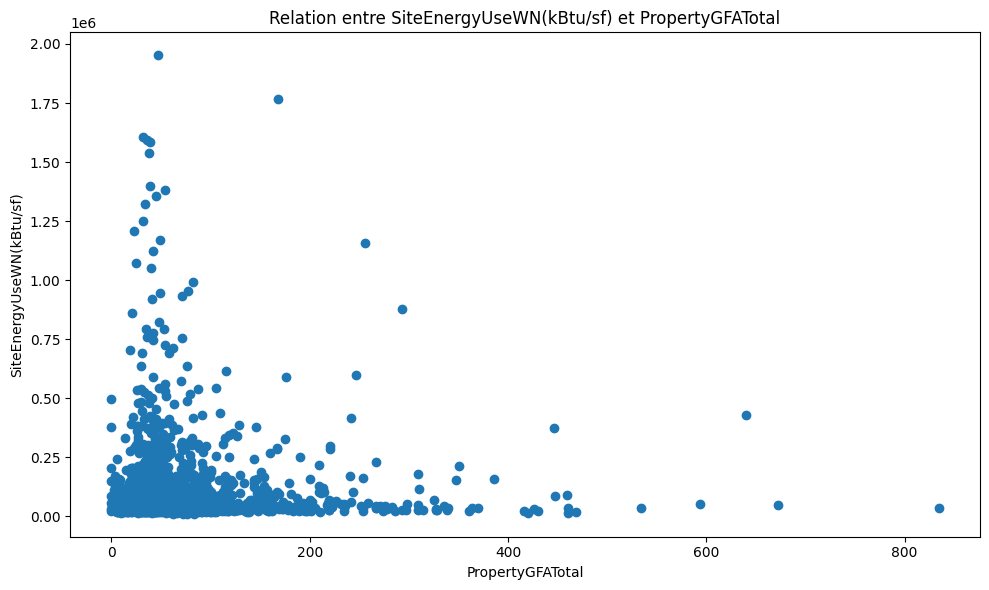

In [57]:

df = building_consumption_clean

plt.figure(figsize=(10,6))
plt.scatter(df["SiteEnergyUseWN(kBtu/sf)"], df["PropertyGFATotal"])

plt.xlabel("PropertyGFATotal")
plt.ylabel("SiteEnergyUseWN(kBtu/sf)")
plt.title("Relation entre SiteEnergyUseWN(kBtu/sf) et PropertyGFATotal")

plt.tight_layout()
plt.show()

On ne peut pas déduire de relation entre la surface totale du bâtiment et sa consommation énergétique par surface

#### Lien entre la consommation énergétique et l'année de construction

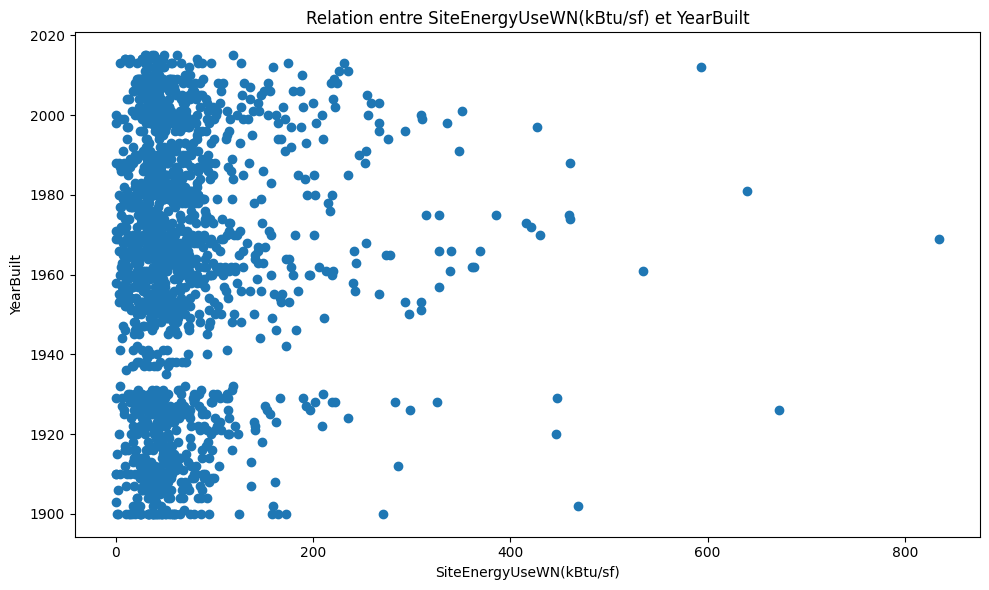

In [58]:

df = building_consumption_clean.copy()

plt.figure(figsize=(10,6))
plt.scatter(df["SiteEnergyUseWN(kBtu/sf)"], df["YearBuilt"])

plt.xlabel("SiteEnergyUseWN(kBtu/sf)")
plt.ylabel("YearBuilt")
plt.title("Relation entre SiteEnergyUseWN(kBtu/sf) et YearBuilt")

plt.tight_layout()
plt.show()

On ne peut pas déduire de relation entre l'année de construction et la consommation électrique

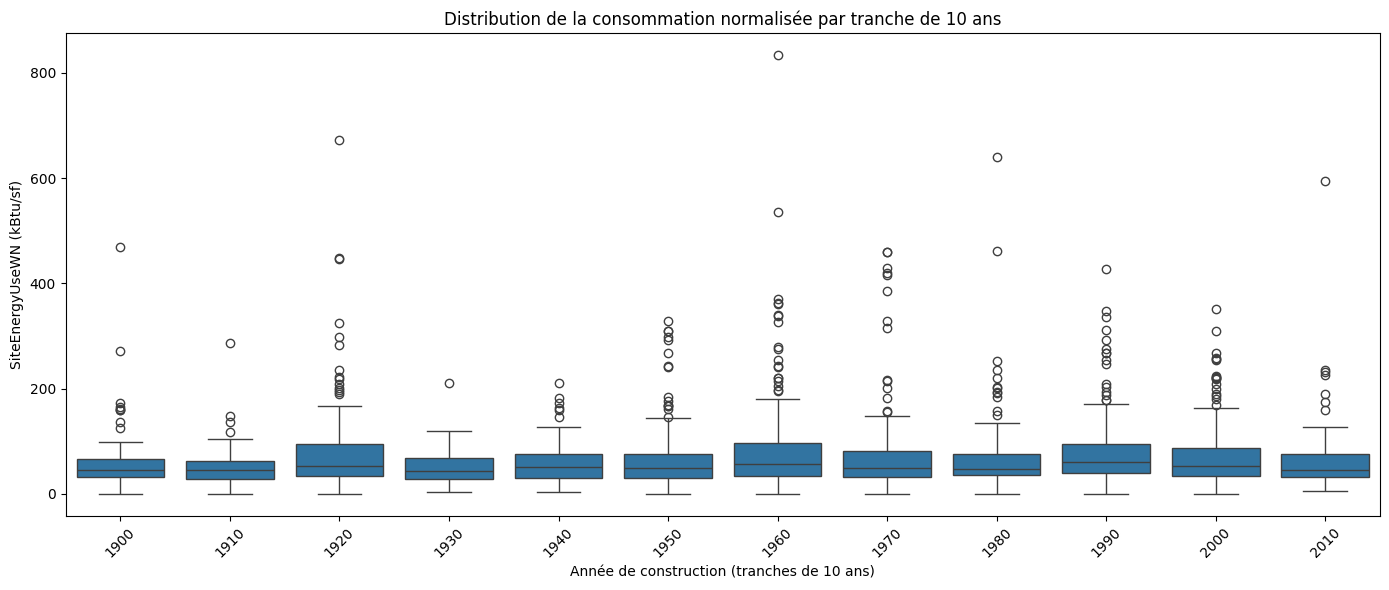

In [59]:
df["YearBuilt_10"] = (df["YearBuilt"] // 10) * 10
plt.figure(figsize=(14,6))
sns.boxplot(
    data=df,
    x="YearBuilt_10",
    y="SiteEnergyUseWN(kBtu/sf)"
)

plt.xticks(rotation=45)
plt.xlabel("Année de construction (tranches de 10 ans)")
plt.ylabel("SiteEnergyUseWN (kBtu/sf)")
plt.title("Distribution de la consommation normalisée par tranche de 10 ans")
plt.tight_layout()

plt.show()

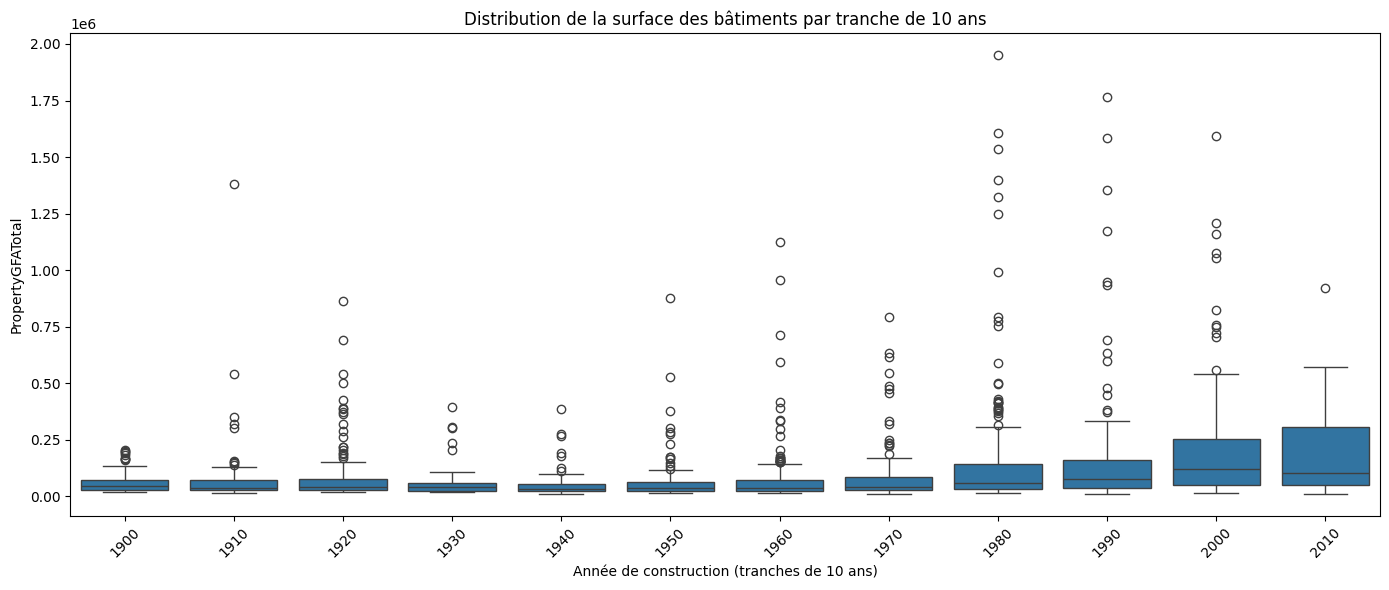

In [60]:
plt.figure(figsize=(14,6))
sns.boxplot(
    data=df,
    x="YearBuilt_10",
    y="PropertyGFATotal"
)

plt.xticks(rotation=45)
plt.xlabel("Année de construction (tranches de 10 ans)")
plt.ylabel("PropertyGFATotal")
plt.title("Distribution de la surface des bâtiments par tranche de 10 ans")
plt.tight_layout()

plt.show()

On remarque que la surface des bâtiments augmente au final des années. (hors années 40 (situation géopolitque)) .Avec une nette augmentation pour les années > 2000.

#### Distribution de la consommation énergétique

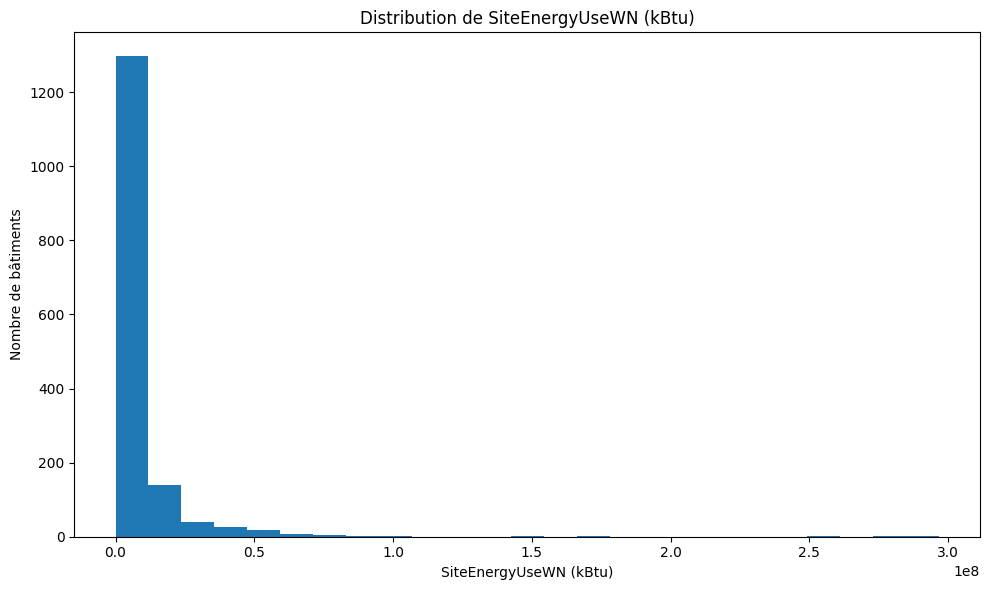

In [61]:
plt.figure(figsize=(10,6))

plt.hist(
    building_consumption_clean["SiteEnergyUseWN(kBtu)"].dropna(),
    bins=25
)

plt.title("Distribution de SiteEnergyUseWN (kBtu)")
plt.xlabel("SiteEnergyUseWN (kBtu)")
plt.ylabel("Nombre de bâtiments")

plt.tight_layout()
plt.show()

On remarque que la majorité des bâtiments consomment peu, sauf quelques uns qui semblent avoir des valeurs extrèment évelvés.

#### Distribution de la surface totale

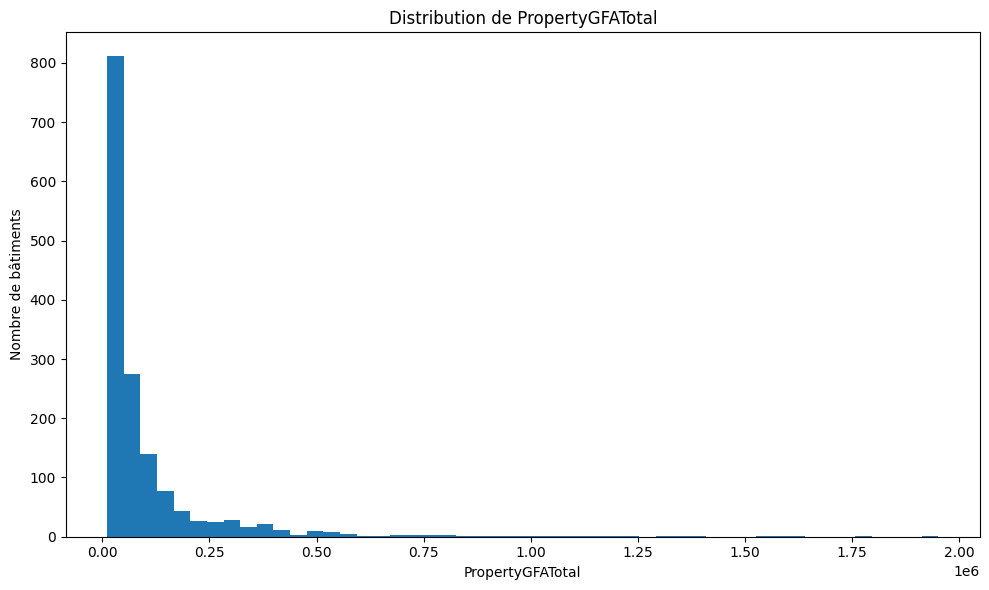

In [62]:
plt.figure(figsize=(10,6))

plt.hist(
    building_consumption_clean["PropertyGFATotal"].dropna(),
    bins=50
)

plt.title("Distribution de PropertyGFATotal")
plt.xlabel("PropertyGFATotal")
plt.ylabel("Nombre de bâtiments")

plt.tight_layout()
plt.show()

#### Distribution de la surface des bâtiments

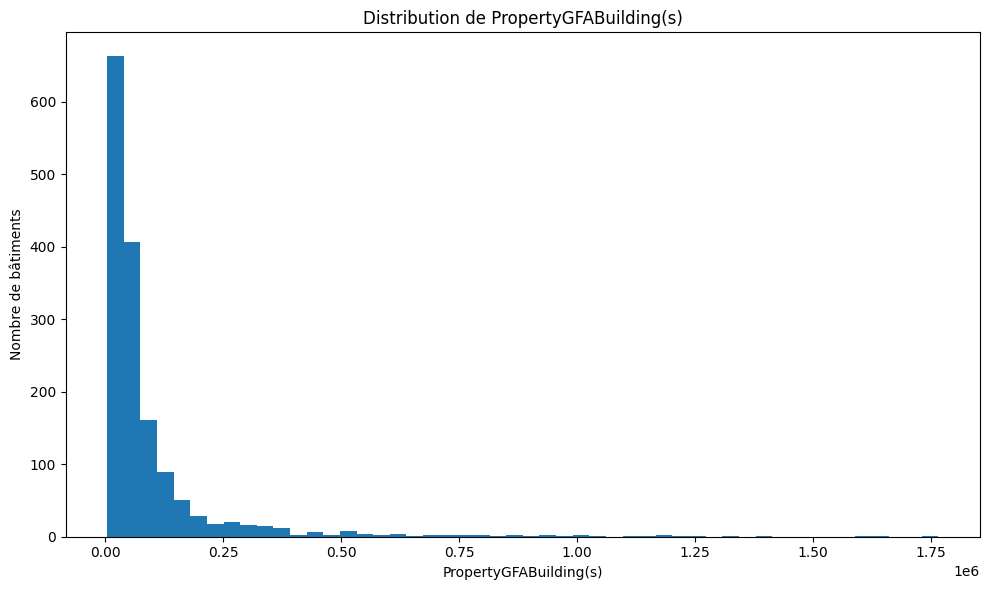

In [63]:
plt.figure(figsize=(10,6))

plt.hist(
    building_consumption_clean["PropertyGFABuilding(s)"].dropna(),
    bins=50
)

plt.title("Distribution de PropertyGFABuilding(s)")
plt.xlabel("PropertyGFABuilding(s)")
plt.ylabel("Nombre de bâtiments")

plt.tight_layout()
plt.show()

On retrouve une courbe similaire pour la surface qui correspond uniquement au bâtiment (sans les parking)

#### Distribution de la consommation énergétique en fonction des quartiers

C:\Users\mcourte\AppData\Local\Temp\ipykernel_19884\755792323.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups, labels=labels, vert=True)


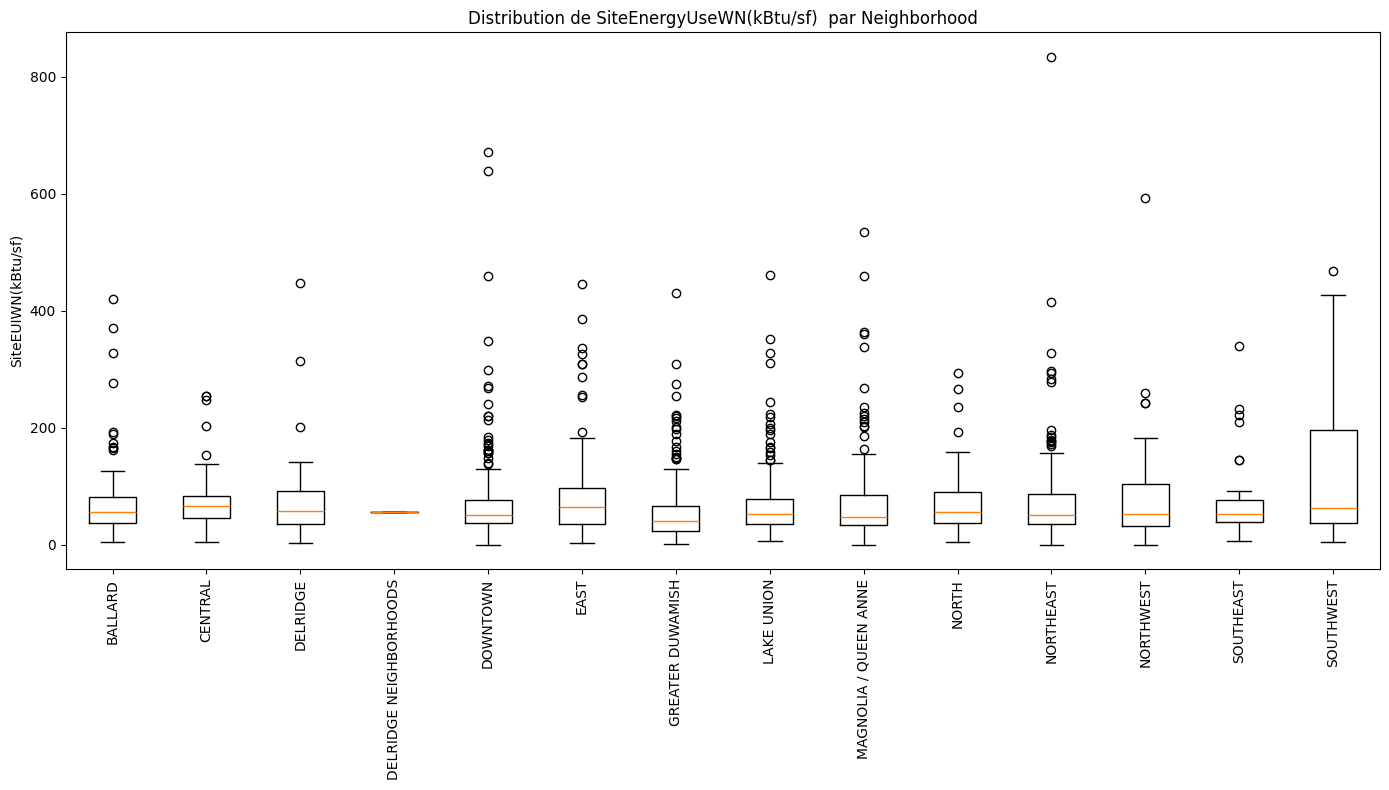

In [64]:
plt.figure(figsize=(14, 8))


df_plot = building_consumption_clean[["Neighborhood", "SiteEnergyUseWN(kBtu/sf)"]].dropna()

groups = [group["SiteEnergyUseWN(kBtu/sf)"].values 
          for name, group in df_plot.groupby("Neighborhood")]

labels = df_plot.groupby("Neighborhood").groups.keys()

plt.boxplot(groups, labels=labels, vert=True)

plt.xticks(rotation=90)
plt.title("Distribution de SiteEnergyUseWN(kBtu/sf)  par Neighborhood")
plt.ylabel("SiteEUIWN(kBtu/sf)")
plt.tight_layout()
plt.show()

#### Distribution de la consommation énergétique en fonction de la fonction première des bâtiments

C:\Users\mcourte\AppData\Local\Temp\ipykernel_19884\3012280451.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups, labels=labels, vert=True)


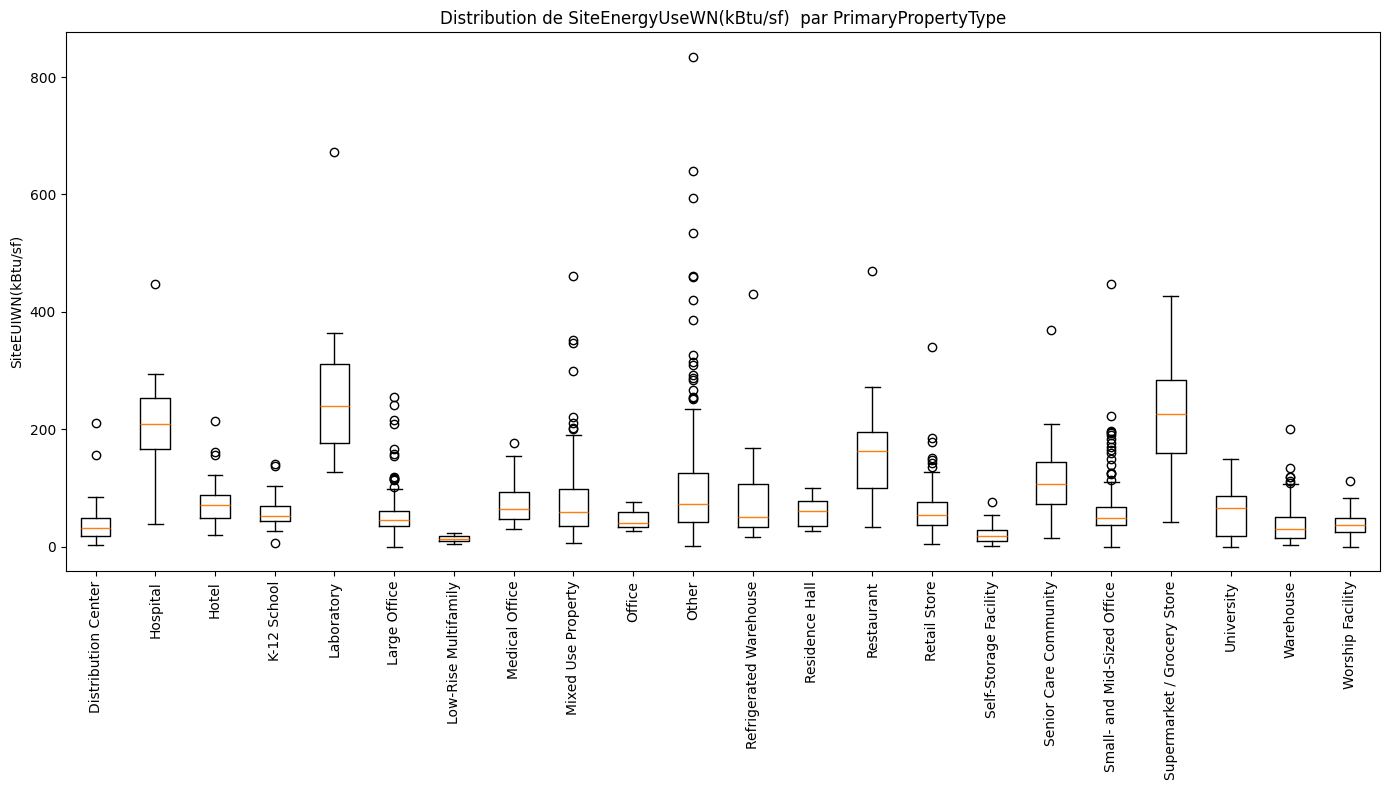

In [65]:
plt.figure(figsize=(14, 8))


df_plot = building_consumption_clean[["PrimaryPropertyType", "SiteEnergyUseWN(kBtu/sf)"]].dropna()

groups = [group["SiteEnergyUseWN(kBtu/sf)"].values 
          for name, group in df_plot.groupby("PrimaryPropertyType")]

labels = df_plot.groupby("PrimaryPropertyType").groups.keys()

plt.boxplot(groups, labels=labels, vert=True)

plt.xticks(rotation=90)
plt.title("Distribution de SiteEnergyUseWN(kBtu/sf)  par PrimaryPropertyType")
plt.ylabel("SiteEUIWN(kBtu/sf)")
plt.tight_layout()
plt.show()

Les hôpitaux sont les plus gros consommateurs d'énergie.

C:\Users\mcourte\AppData\Local\Temp\ipykernel_19884\1860180066.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups, labels=labels, vert=True)


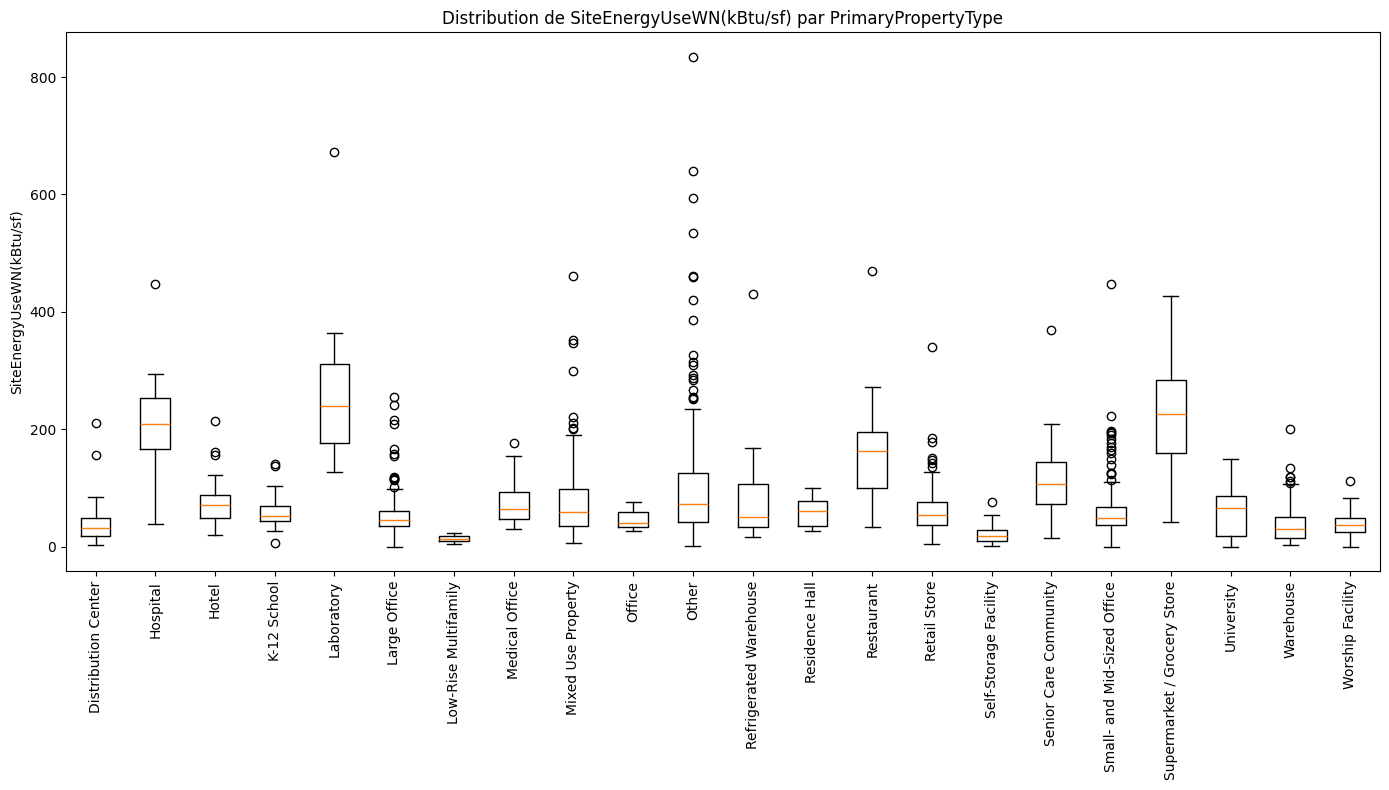

In [66]:
plt.figure(figsize=(14, 8))


df_plot = building_consumption_clean[["PrimaryPropertyType", "SiteEnergyUseWN(kBtu/sf)"]].dropna()

groups = [group["SiteEnergyUseWN(kBtu/sf)"].values 
          for name, group in df_plot.groupby("PrimaryPropertyType")]

labels = df_plot.groupby("PrimaryPropertyType").groups.keys()

plt.boxplot(groups, labels=labels, vert=True)

plt.xticks(rotation=90)
plt.title("Distribution de SiteEnergyUseWN(kBtu/sf) par PrimaryPropertyType")
plt.ylabel("SiteEnergyUseWN(kBtu/sf)")
plt.tight_layout()
plt.show()

Les hôpitaux et les Data Center sont les plus gros consommateur d'énergie

#### Proportion de LargestPropertyUse et PropertyGFA total 

In [67]:
surface_total = df['PropertyGFATotal'].copy()

surface_total.replace(0, np.nan, inplace=True)

df['Proportion_LargestUse_to_TotalGFA'] = df['LargestPropertyUseTypeGFA'] / surface_total
df['Proportion_LargestUse_to_TotalGFA'].fillna(0)

0       1.000000
1       0.809918
2       0.791220
3       1.000000
4       0.703070
          ...   
3371    1.000000
3372    1.000000
3373    0.576347
3374    0.468123
3375    0.453007
Name: Proportion_LargestUse_to_TotalGFA, Length: 1541, dtype: float64

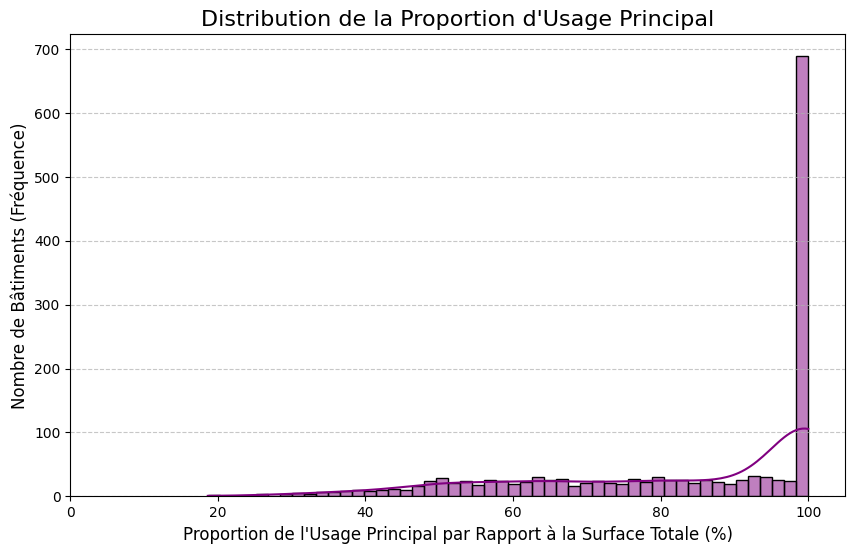

In [68]:
proportion_percent = df['Proportion_LargestUse_to_TotalGFA'] * 100
proportion_percent = np.minimum(proportion_percent, 100)

plt.figure(figsize=(10, 6))

# Création de l'histogramme avec la colonne PLAFONNÉE
sns.histplot(proportion_percent, bins=50, kde=True, color='purple', edgecolor='black')

plt.title("Distribution de la Proportion d'Usage Principal", fontsize=16)
plt.xlabel("Proportion de l'Usage Principal par Rapport à la Surface Totale (%)", fontsize=12)
plt.ylabel("Nombre de Bâtiments (Fréquence)", fontsize=12)
plt.xlim(0, 105) # Limiter l'axe X pour bien voir l'effet du plafonnement
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [69]:
surface_total = df['PropertyGFATotal'].copy()

surface_total.replace(0, np.nan, inplace=True)

df['Proportion_SecondUse_to_TotalGFA'] = df['SecondLargestPropertyUseTypeGFA'] / surface_total
df['Proportion_SecondUse_to_TotalGFA'].fillna(0)

0       0.000000
1       0.145453
2       0.000000
3       0.000000
4       0.387339
          ...   
3371    0.000000
3372    0.000000
3373    0.423653
3374    0.461031
3375    0.438164
Name: Proportion_SecondUse_to_TotalGFA, Length: 1541, dtype: float64

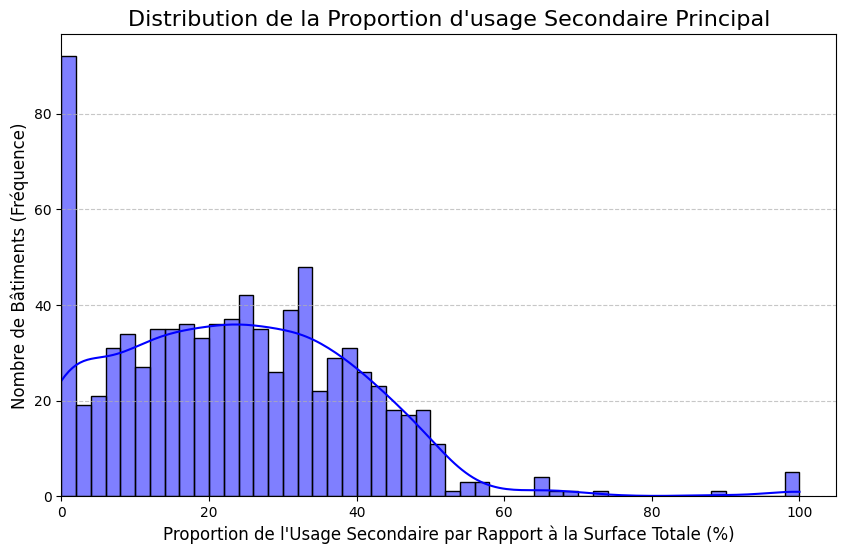

In [70]:
proportion_percent = df['Proportion_SecondUse_to_TotalGFA'] * 100
proportion_percent = np.minimum(proportion_percent, 100)

plt.figure(figsize=(10, 6))

sns.histplot(proportion_percent, bins=50, kde=True, color='blue', edgecolor='black')

plt.title("Distribution de la Proportion d'usage Secondaire Principal", fontsize=16)
plt.xlabel("Proportion de l'Usage Secondaire par Rapport à la Surface Totale (%)", fontsize=12)
plt.ylabel("Nombre de Bâtiments (Fréquence)", fontsize=12)
plt.xlim(0, 105)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [71]:
surface_total = df['PropertyGFATotal'].copy()

surface_total.replace(0, np.nan, inplace=True)

df['Proportion_ThirdUse_to_TotalGFA'] = df['ThirdLargestPropertyUseTypeGFA'] / surface_total
df['Proportion_ThirdUse_to_TotalGFA'].fillna(0)

0       0.000000
1       0.044629
2       0.000000
3       0.000000
4       0.000000
          ...   
3371    0.000000
3372    0.000000
3373    0.000000
3374    0.034324
3375    0.060686
Name: Proportion_ThirdUse_to_TotalGFA, Length: 1541, dtype: float64

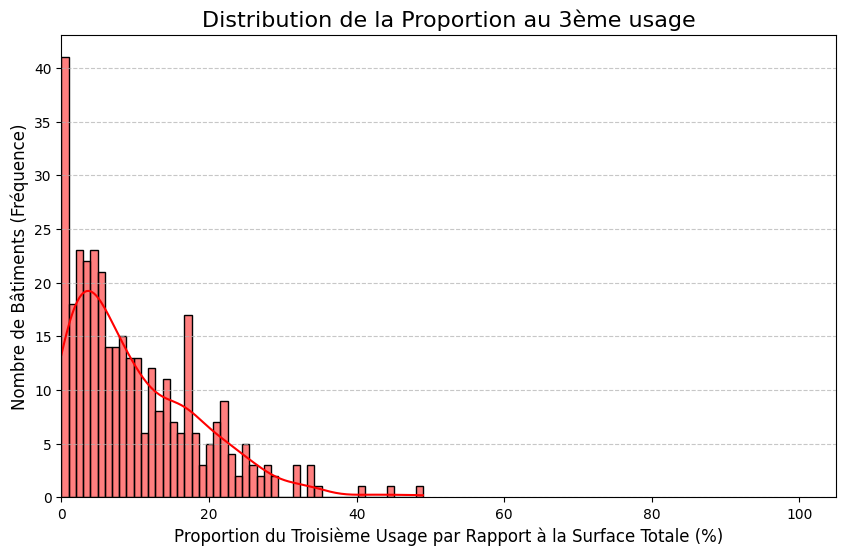

In [72]:
proportion_percent = df['Proportion_ThirdUse_to_TotalGFA'] * 100
proportion_percent = np.minimum(proportion_percent, 100)

plt.figure(figsize=(10, 6))


sns.histplot(proportion_percent, bins=50, kde=True, color='red', edgecolor='black')

plt.title("Distribution de la Proportion au 3ème usage", fontsize=16)
plt.xlabel("Proportion du Troisième Usage par Rapport à la Surface Totale (%)", fontsize=12)
plt.ylabel("Nombre de Bâtiments (Fréquence)", fontsize=12)
plt.xlim(0, 105) 
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [73]:
building_consumption_clean.shape

(1541, 35)

# Modélisation 

### Import des modules 

In [74]:
#Selection
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV, 
    cross_validate,
    cross_val_score
)
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.inspection import permutation_importance

#Preprocess
from sklearn.compose import ColumnTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

#Modèles
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

#### Définition du DF de départ

In [75]:
df = building_consumption_clean.copy()

In [76]:
target = 'SiteEnergyUseWN(kBtu)'
# On peut supprimer les colonnes correspondant à l'ID et le nom du bâtiment, ainsi que la liste de tous les usages d'un bâtiment 
#( on peut s'arrêter aux trois premiers types d'usage)
columns_to_drop = [target, 'OSEBuildingID', 'PropertyName', 'ListOfAllPropertyUse'] 
df = df.drop(columns=columns_to_drop, errors='ignore') 


#### Matrice de Pearson

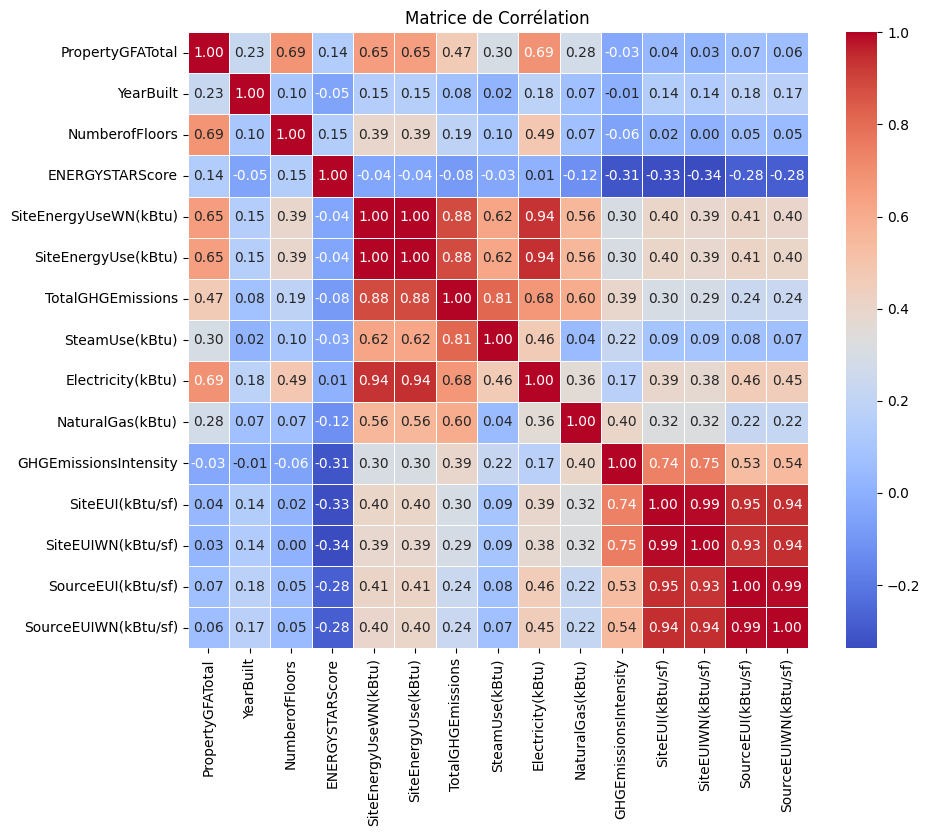

In [77]:
colonnes_correlation = [
    'PropertyGFATotal', 
    'YearBuilt', 
    'NumberofFloors',
    'ENERGYSTARScore', 
    'SiteEnergyUseWN(kBtu)', 
    'SiteEnergyUse(kBtu)', 
    'TotalGHGEmissions',
    'SteamUse(kBtu)', 
    'Electricity(kBtu)',
    'NaturalGas(kBtu)',
    'GHGEmissionsIntensity',
    'SiteEUI(kBtu/sf)', 
    'SiteEUIWN(kBtu/sf)',
    'SourceEUI(kBtu/sf)', 
    'SourceEUIWN(kBtu/sf)',
]

df_corr = building_consumption_clean[colonnes_correlation].copy()

# 2. Calcul de la matrice de corrélation
matrice_corr = df_corr.corr(method='pearson')

# 3. Visualisation (Heatmap)
plt.figure(figsize=(10, 8))
sns.heatmap(
    matrice_corr, 
    annot=True, 
    cmap='coolwarm', 
    fmt=".2f",
    linewidths=.5,
)
plt.title('Matrice de Corrélation')
plt.show()

les colonnes ayant une trop forte ou trop petite corrélation les unes avec les autres peuvent être supprimer dans notre DF pour avoir une meilleure analyse. Elles risque de mal entraîner notre futur modèle.

#### Création d'un DF sans Data Leakage

In [78]:
# Selection des colonnes provoquant un Data Leakage
data_leakage_columns = [
    'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
    'SiteEnergyUse(kBtu)', 'SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)',
    'TotalGHGEmissions', 'GHGEmissionsIntensity', 'ENERGYSTARScore', 'YearsENERGYSTARCertified',
    'SiteEnergyUseWN(kBtu/sf)',
]


# Construction de la liste finale des colonnes à supprimer.
features_to_drop = list(set(data_leakage_columns))


df_without_leakage = df.drop(columns=features_to_drop)

In [79]:
# Séparation des colonnes en colonnes numérique et catégorielles
numeric_columns = df_without_leakage.select_dtypes(include=np.number).columns.tolist()
categorical_columns = df_without_leakage.select_dtypes(exclude=np.number).columns.tolist()

#### Categorical Columns

In [80]:
#Vérifivcation qu'il existe des colonnes catégorielles avec des NaN
df_without_leakage[categorical_columns].isna().any()

BuildingType                    False
PrimaryPropertyType             False
Neighborhood                    False
ListOfAllPropertyUseTypes       False
LargestPropertyUseType           True
SecondLargestPropertyUseType     True
ThirdLargestPropertyUseType      True
DefaultData                     False
ComplianceStatus                False
Outlier                          True
dtype: bool

On remarque que **LargestPropertyUseType** et **SecondLargestPropertyUseType** et **Outlier** contiennent des NaN

##### LargestPropertyUseType

In [81]:
df_without_leakage[df_without_leakage['LargestPropertyUseType'].isna()]

BuildingType          PrimaryPropertyType Neighborhood  YearBuilt  \
353   NonResidential        Self-Storage Facility      BALLARD       1946   
1147  NonResidential                        Hotel     DOWNTOWN       1910   
2414  NonResidential  Small- and Mid-Sized Office   LAKE UNION       2008   
2459  NonResidential                   Restaurant     DOWNTOWN       1913   

      NumberofBuildings  NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
353                 2.0               2            111445                   0   
1147                1.0               8             61721                   0   
2414                1.0               4             48350                   0   
2459                1.0               3             28800                   0   

      PropertyGFABuilding(s)  \
353                   111445   
1147                   61721   
2414                   48350   
2459                   28800   

                              ListOfAllPropertyUseTypes  \
353   Fitness Center/Health Club/Gym, Office, Other ...   
1147                                              Hotel   
2414                                             Office   
2459                                         Restaurant   

     LargestPropertyUseType  LargestPropertyUseTypeGFA  \
353                     NaN                        NaN   
1147                    NaN                        NaN   
2414                    NaN                        NaN   
2459                    NaN                        NaN   

     SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA  \
353                           NaN                              NaN   
1147                          NaN                              NaN   
2414                          NaN                              NaN   
2459                          NaN                              NaN   

     ThirdLargestPropertyUseType  ThirdLargestPropertyUseTypeGFA  DefaultData  \
353                          NaN                             NaN        False   
1147                         NaN                             NaN        False   
2414                         NaN                             NaN        False   
2459                         NaN                             NaN        False   

     ComplianceStatus Outlier  
353         Compliant     NaN  
1147        Compliant     NaN  
2414        Compliant     NaN  
2459        Compliant     NaN

On peut supposer que l'on peut appliquer les valeurs de **PrimaryPropertyType** à **LargestPropertyUseType**

In [82]:
mask = df_without_leakage['LargestPropertyUseType'].isna() & df_without_leakage['PrimaryPropertyType'].notna()
df_without_leakage.loc[mask, 'LargestPropertyUseType'] = df_without_leakage.loc[mask, 'PrimaryPropertyType']

In [83]:
df_without_leakage[df_without_leakage['LargestPropertyUseType'].isna()]

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ListOfAllPropertyUseTypes, LargestPropertyUseType, LargestPropertyUseTypeGFA, SecondLargestPropertyUseType, SecondLargestPropertyUseTypeGFA, ThirdLargestPropertyUseType, ThirdLargestPropertyUseTypeGFA, DefaultData, ComplianceStatus, Outlier]
Index: []

##### SecondLargestPropertyUseType

In [84]:
df_without_leakage[df_without_leakage['SecondLargestPropertyUseType'].isna()]

BuildingType PrimaryPropertyType            Neighborhood  \
0         NonResidential               Hotel                DOWNTOWN   
2         NonResidential               Hotel                DOWNTOWN   
3         NonResidential               Hotel                DOWNTOWN   
5     Nonresidential COS               Other                DOWNTOWN   
6         NonResidential               Hotel                DOWNTOWN   
...                  ...                 ...                     ...   
3367  Nonresidential COS               Other                    EAST   
3369  Nonresidential COS              Office               SOUTHEAST   
3370  Nonresidential COS               Other  DELRIDGE NEIGHBORHOODS   
3371  Nonresidential COS              Office        GREATER DUWAMISH   
3372  Nonresidential COS               Other                DOWNTOWN   

      YearBuilt  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
0          1927                1.0              12             88434   
2          1969                1.0              41            956110   
3          1926                1.0              10             61320   
5          1999                1.0               2             97288   
6          1926                1.0              11             83008   
...         ...                ...             ...               ...   
3367       1912                1.0               1             23445   
3369       1960                1.0               1             15398   
3370       1982                1.0               1             18261   
3371       1990                1.0               1             12294   
3372       2004                1.0               1             16000   

      PropertyGFAParking  PropertyGFABuilding(s) ListOfAllPropertyUseTypes  \
0                      0                   88434                     Hotel   
2                 196718                  759392                     Hotel   
3                      0                   61320                     Hotel   
5                  37198                   60090            Police Station   
6                      0                   83008                     Hotel   
...                  ...                     ...                       ...   
3367                   0                   23445        Other - Recreation   
3369                   0                   15398                    Office   
3370                   0                   18261        Other - Recreation   
3371                   0                   12294                    Office   
3372                   0                   16000        Other - Recreation   

     LargestPropertyUseType  LargestPropertyUseTypeGFA  \
0                     Hotel                    88434.0   
2                     Hotel                   756493.0   
3                     Hotel                    61320.0   
5            Police Station                    88830.0   
6                     Hotel                    81352.0   
...                     ...                        ...   
3367     Other - Recreation                    23445.0   
3369                 Office                    15398.0   
3370     Other - Recreation                    18261.0   
3371                 Office                    12294.0   
3372     Other - Recreation                    16000.0   

     SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA  \
0                             NaN                              NaN   
2                             NaN                              NaN   
3                             NaN                              NaN   
5                             NaN                              NaN   
6                             NaN                              NaN   
...                           ...                              ...   
3367                          NaN                              NaN   
3369                          NaN                              NaN   
3370              

Comme nous ne pouvons pas deviner quel est le second usage du bâtiment, on remplace ces valeurs par **None**

In [85]:
df_without_leakage['SecondLargestPropertyUseType'] = df_without_leakage['SecondLargestPropertyUseType'].fillna('None')

In [86]:
df_without_leakage['ThirdLargestPropertyUseType'] = df_without_leakage['ThirdLargestPropertyUseType'].fillna('None')

##### Outliers

In [87]:
df_without_leakage[df_without_leakage['Outlier'].isna()]

BuildingType PrimaryPropertyType           Neighborhood  \
0         NonResidential               Hotel               DOWNTOWN   
1         NonResidential               Hotel               DOWNTOWN   
2         NonResidential               Hotel               DOWNTOWN   
3         NonResidential               Hotel               DOWNTOWN   
4         NonResidential               Hotel               DOWNTOWN   
...                  ...                 ...                    ...   
3371  Nonresidential COS              Office       GREATER DUWAMISH   
3372  Nonresidential COS               Other               DOWNTOWN   
3373  Nonresidential COS               Other  MAGNOLIA / QUEEN ANNE   
3374  Nonresidential COS  Mixed Use Property       GREATER DUWAMISH   
3375  Nonresidential COS  Mixed Use Property       GREATER DUWAMISH   

      YearBuilt  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
0          1927                1.0              12             88434   
1          1996                1.0              11            103566   
2          1969                1.0              41            956110   
3          1926                1.0              10             61320   
4          1980                1.0              18            175580   
...         ...                ...             ...               ...   
3371       1990                1.0               1             12294   
3372       2004                1.0               1             16000   
3373       1974                1.0               1             13157   
3374       1989                1.0               1             14101   
3375       1938                1.0               1             18258   

      PropertyGFAParking  PropertyGFABuilding(s)  \
0                      0                   88434   
1                  15064                   88502   
2                 196718                  759392   
3                      0                   61320   
4                  62000                  113580   
...                  ...                     ...   
3371                   0                   12294   
3372                   0                   16000   
3373                   0                   13157   
3374                   0                   14101   
3375                   0                   18258   

                              ListOfAllPropertyUseTypes  \
0                                                 Hotel   
1                            Hotel, Parking, Restaurant   
2                                                 Hotel   
3                                                 Hotel   
4                         Hotel, Parking, Swimming Pool   
...                                                 ...   
3371                                             Office   
3372                                 Other - Recreation   
3373  Fitness Center/Health Club/Gym, Other - Recrea...   
3374  Fitness Center/Health Club/Gym, Food Service, ...   
3375  Fitness Center/Health Club/Gym, Food Service, ...   

     LargestPropertyUseType  LargestPropertyUseTypeGFA  \
0                     Hotel                    88434.0   
1                     Hotel                    83880.0   
2                     Hotel                   756493.0   
3                     Hotel                    61320.0   
4                     Hotel                   123445.0   
...                     ...                        ...   
3371                 Office                    12294.0   
3372     Other - Recreation                    16000.0   
3373     Other - Recreation                     7583.0   
3374     Other - Recreation                     6601.0   
3375     Other - Recreation                     8271.0   

        SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA  \
0                               None                              NaN   
1                            Parking                          15064.0   
2                               None        

Pour les **outliers** qui  ne sont ni *High* ni *Low* on va les remplacer par **No**

In [88]:
df_without_leakage['Outlier'] = df_without_leakage['Outlier'].fillna('No')

##### Vérification qu'il n'existe plus de colonnes catégorielles vides

In [89]:
df_without_leakage[categorical_columns].isna().any()

BuildingType                    False
PrimaryPropertyType             False
Neighborhood                    False
ListOfAllPropertyUseTypes       False
LargestPropertyUseType          False
SecondLargestPropertyUseType    False
ThirdLargestPropertyUseType     False
DefaultData                     False
ComplianceStatus                False
Outlier                         False
dtype: bool

#### Numeric Columns

In [90]:
df_without_leakage[numeric_columns].isna().any()

YearBuilt                          False
NumberofBuildings                  False
NumberofFloors                     False
PropertyGFATotal                   False
PropertyGFAParking                 False
PropertyGFABuilding(s)             False
LargestPropertyUseTypeGFA           True
SecondLargestPropertyUseTypeGFA     True
ThirdLargestPropertyUseTypeGFA      True
dtype: bool

On remarque que **LargestPropertyUseTypeGFA** et **SecondLargestPropertyUseTypeGFA** ont des valeurs nulles.

##### LargestPropertyUseTypeGFA

In [91]:
df_without_leakage[df_without_leakage['LargestPropertyUseTypeGFA'].isna()]

BuildingType          PrimaryPropertyType Neighborhood  YearBuilt  \
353   NonResidential        Self-Storage Facility      BALLARD       1946   
1147  NonResidential                        Hotel     DOWNTOWN       1910   
2414  NonResidential  Small- and Mid-Sized Office   LAKE UNION       2008   
2459  NonResidential                   Restaurant     DOWNTOWN       1913   

      NumberofBuildings  NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
353                 2.0               2            111445                   0   
1147                1.0               8             61721                   0   
2414                1.0               4             48350                   0   
2459                1.0               3             28800                   0   

      PropertyGFABuilding(s)  \
353                   111445   
1147                   61721   
2414                   48350   
2459                   28800   

                              ListOfAllPropertyUseTypes  \
353   Fitness Center/Health Club/Gym, Office, Other ...   
1147                                              Hotel   
2414                                             Office   
2459                                         Restaurant   

           LargestPropertyUseType  LargestPropertyUseTypeGFA  \
353         Self-Storage Facility                        NaN   
1147                        Hotel                        NaN   
2414  Small- and Mid-Sized Office                        NaN   
2459                   Restaurant                        NaN   

     SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA  \
353                          None                              NaN   
1147                         None                              NaN   
2414                         None                              NaN   
2459                         None                              NaN   

     ThirdLargestPropertyUseType  ThirdLargestPropertyUseTypeGFA  DefaultData  \
353                         None                             NaN        False   
1147                        None                             NaN        False   
2414                        None                             NaN        False   
2459                        None                             NaN        False   

     ComplianceStatus Outlier  
353         Compliant      No  
1147        Compliant      No  
2414        Compliant      No  
2459        Compliant      No

Pour ces  colonnes, on va remplacer la **LargestPropertyUseTypeGFA** par la **PropertyGFATotal** puisque que le **SecondLargestPropertyUseType** est *Unknown* et la colonne **PropertyGFABuilding(s)** est égale à la **LargestPropertyUseTypeGFA**

In [92]:
mask = (df_without_leakage['LargestPropertyUseTypeGFA'].isna()) & \
       (df_without_leakage['PropertyGFABuilding(s)'].notna())

df_without_leakage.loc[mask, 'LargestPropertyUseTypeGFA'] = \
    df_without_leakage.loc[mask, 'PropertyGFABuilding(s)']


In [93]:
df_without_leakage[df_without_leakage['LargestPropertyUseTypeGFA'].isna()]

Empty DataFrame
Columns: [BuildingType, PrimaryPropertyType, Neighborhood, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFATotal, PropertyGFAParking, PropertyGFABuilding(s), ListOfAllPropertyUseTypes, LargestPropertyUseType, LargestPropertyUseTypeGFA, SecondLargestPropertyUseType, SecondLargestPropertyUseTypeGFA, ThirdLargestPropertyUseType, ThirdLargestPropertyUseTypeGFA, DefaultData, ComplianceStatus, Outlier]
Index: []

##### SecondLargestPropertyUseTypeGFA

In [94]:
df_without_leakage[df_without_leakage['SecondLargestPropertyUseTypeGFA'].isna()]

BuildingType PrimaryPropertyType            Neighborhood  \
0         NonResidential               Hotel                DOWNTOWN   
2         NonResidential               Hotel                DOWNTOWN   
3         NonResidential               Hotel                DOWNTOWN   
5     Nonresidential COS               Other                DOWNTOWN   
6         NonResidential               Hotel                DOWNTOWN   
...                  ...                 ...                     ...   
3367  Nonresidential COS               Other                    EAST   
3369  Nonresidential COS              Office               SOUTHEAST   
3370  Nonresidential COS               Other  DELRIDGE NEIGHBORHOODS   
3371  Nonresidential COS              Office        GREATER DUWAMISH   
3372  Nonresidential COS               Other                DOWNTOWN   

      YearBuilt  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
0          1927                1.0              12             88434   
2          1969                1.0              41            956110   
3          1926                1.0              10             61320   
5          1999                1.0               2             97288   
6          1926                1.0              11             83008   
...         ...                ...             ...               ...   
3367       1912                1.0               1             23445   
3369       1960                1.0               1             15398   
3370       1982                1.0               1             18261   
3371       1990                1.0               1             12294   
3372       2004                1.0               1             16000   

      PropertyGFAParking  PropertyGFABuilding(s) ListOfAllPropertyUseTypes  \
0                      0                   88434                     Hotel   
2                 196718                  759392                     Hotel   
3                      0                   61320                     Hotel   
5                  37198                   60090            Police Station   
6                      0                   83008                     Hotel   
...                  ...                     ...                       ...   
3367                   0                   23445        Other - Recreation   
3369                   0                   15398                    Office   
3370                   0                   18261        Other - Recreation   
3371                   0                   12294                    Office   
3372                   0                   16000        Other - Recreation   

     LargestPropertyUseType  LargestPropertyUseTypeGFA  \
0                     Hotel                    88434.0   
2                     Hotel                   756493.0   
3                     Hotel                    61320.0   
5            Police Station                    88830.0   
6                     Hotel                    81352.0   
...                     ...                        ...   
3367     Other - Recreation                    23445.0   
3369                 Office                    15398.0   
3370     Other - Recreation                    18261.0   
3371                 Office                    12294.0   
3372     Other - Recreation                    16000.0   

     SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA  \
0                            None                              NaN   
2                            None                              NaN   
3                            None                              NaN   
5                            None                              NaN   
6                            None                              NaN   
...                           ...                              ...   
3367                         None                              NaN   
3369                         None                              NaN   
3370              

In [95]:
mask_non_unknown = df_without_leakage['SecondLargestPropertyUseType'] != 'None'
mask_unknown = df_without_leakage['SecondLargestPropertyUseType'] == 'None'
# 1. Calculer la différence
diff_gfa = df_without_leakage['PropertyGFATotal'] - df_without_leakage['LargestPropertyUseTypeGFA']

# 2. Cas 1 : S'il y a un second usage, on prend la différence, mais on force le minimum à 0
# (Cela supprime les valeurs négatives dues aux erreurs de saisie)
df_without_leakage.loc[mask_non_unknown, 'SecondLargestPropertyUseTypeGFA'] = diff_gfa.clip(lower=0)

# 3. Cas 2 : Si pas de second usage
df_without_leakage.loc[mask_unknown, 'SecondLargestPropertyUseTypeGFA'] = 0

In [96]:

# Calcul de la surface restante théorique
restante = (df_without_leakage['PropertyGFATotal'] 
            - df_without_leakage['LargestPropertyUseTypeGFA'] 
            - df_without_leakage['SecondLargestPropertyUseTypeGFA'])

# Cas 1 : S'il y a un troisième usage, on prend le reste (minimum 0)
mask_non_unknown = df_without_leakage['ThirdLargestPropertyUseType'] != 'None'
df_without_leakage.loc[mask_non_unknown, 'ThirdLargestPropertyUseTypeGFA'] = restante.clip(lower=0)

# Cas 2 : Si pas de troisième usage
mask_unknown = df_without_leakage['ThirdLargestPropertyUseType'] == 'None'
df_without_leakage.loc[mask_unknown, 'ThirdLargestPropertyUseTypeGFA'] = 0

In [97]:
df_without_leakage[categorical_columns].isna().any()

BuildingType                    False
PrimaryPropertyType             False
Neighborhood                    False
ListOfAllPropertyUseTypes       False
LargestPropertyUseType          False
SecondLargestPropertyUseType    False
ThirdLargestPropertyUseType     False
DefaultData                     False
ComplianceStatus                False
Outlier                         False
dtype: bool

In [98]:
df_without_leakage[numeric_columns].isna().any()

YearBuilt                          False
NumberofBuildings                  False
NumberofFloors                     False
PropertyGFATotal                   False
PropertyGFAParking                 False
PropertyGFABuilding(s)             False
LargestPropertyUseTypeGFA          False
SecondLargestPropertyUseTypeGFA    False
ThirdLargestPropertyUseTypeGFA     False
dtype: bool

Plus aucunes colonnes numériques et catégorielles contiennent des valeurs nulles.

In [99]:
# Retransformation des colonnes numériques et catégorielles
numeric_columns = df_without_leakage.select_dtypes(include=np.number).columns.tolist()
categorical_columns = df_without_leakage.select_dtypes(exclude=np.number).columns.tolist()

### Regression Linéaire

In [100]:
# On liste les colonnes qui sont importantes pour notre modèle
features_to_keep = [
    'BuildingType', 'PrimaryPropertyType', 'Neighborhood', 'YearBuilt',
    'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
    'PropertyGFAParking', 'PropertyGFABuilding(s)',
    'LargestPropertyUseType', 'ListOfAllPropertyUseTypes',
    'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType',
    'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType',
    'ThirdLargestPropertyUseTypeGFA','DefaultData', 'ComplianceStatus',
    'Outlier'
]


#### Pipeline train/test

In [101]:
df_without_leakage[features_to_keep].columns

Index(['BuildingType', 'PrimaryPropertyType', 'Neighborhood', 'YearBuilt',
       'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'LargestPropertyUseType', 'ListOfAllPropertyUseTypes',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType',
       'ThirdLargestPropertyUseTypeGFA', 'DefaultData', 'ComplianceStatus',
       'Outlier'],
      dtype='object')

In [102]:


y = building_consumption_clean['SiteEnergyUse(kBtu)']
X = df_without_leakage[features_to_keep].copy()


X = X.loc[y.index]

numeric_columns = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_columns = X.select_dtypes(include=['object', 'category']).columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,  # 20% pour le jeu de test
    random_state=42 # Pour garantir la reproductibilité
)



numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_columns),
        ('cat', categorical_transformer, categorical_columns)
    ],
    remainder='drop'
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])


pipeline.fit(X_train, y_train)

y_prediction_test = pipeline.predict(X_test)

Nous utilisons principalement le coefficient de détermination R², complété par la RMSE et la MAE.  
*Justification :*  

- **R²** : capacité du modèle à expliquer la variance de la consommation énergétique  

- **RMSE** : pénalise fortement les grosses erreurs  

- **MAE** : erreur moyenne facilement interprétable métier  

*Ces métriques permettent d’évaluer à la fois la précision et la stabilité du modèle.*

In [103]:
y_true = y_test 
y_pred = y_prediction_test

# On calcule la MSE (Mean Squared Error) :
mse = mean_squared_error(y_true, y_pred)

# On calcule la RMSE (Root Mean Squared Error) :
rmse = np.sqrt(mse)

# On calcule la MAE (Mean Absolute Error) :
mae = mean_absolute_error(y_true, y_pred)

# On calcule le R² :
r2 = r2_score(y_true, y_pred)

# Affichage des résultats
print("--- Mesures du Modèle sur l'Ensemble de TEST (20% des données) ---")
print(f"R-carré (R2) : {r2:.4f}")
print(f"Erreur Quadratique Moyenne (RMSE) : {rmse:.2f} kBtu")
print(f"Erreur Absolue Moyenne (MAE) : {mae:.2f} kBtu")


--- Mesures du Modèle sur l'Ensemble de TEST (20% des données) ---
R-carré (R2) : -0.0337
Erreur Quadratique Moyenne (RMSE) : 13664728.08 kBtu
Erreur Absolue Moyenne (MAE) : 6816366.09 kBtu


LE R² étant négatif, ce premier modèle de Régression linéaire n'est pas adapté pour notre projet.

#### Calcul de la différence entre le y_réel et le y_prediction

In [104]:

y_column_name = 'SiteEnergyUseWN(kBtu)'

y_series = building_consumption_clean[y_column_name].copy()

df_combined = pd.concat([X, y_series], axis=1)


X_final = df_combined[X.columns]
y_final = df_combined[y_series.name]


pipeline.fit(X_final, y_final)

# Prédiction
y_reel = pipeline.predict(X_final)


In [105]:
df_resultats_test = pd.DataFrame({
    # y_test contient les vraies valeurs du jeu de test (la vérité terrain)
    'y_reel': y_test.values,
    
    # y_prediction_test contient les prédictions correspondantes du jeu de test
    'y_predict': y_prediction_test,
})


df_resultats_test.index = y_test.index



df_resultats_test['erreur_pourcentage'] = (
    np.abs(df_resultats_test['y_reel'] - df_resultats_test['y_predict']) / df_resultats_test['y_reel']
) * 100

#### Ajout d'une colonne Bonne ou Mauvaise Prédicition

In [106]:
# Calcul du 90e percentile de la colonne d'erreur
percentile_90 = df_resultats_test['erreur_pourcentage'].quantile(0.90)

# Créer un masque pour les 90% d'observations avec la plus petite erreur (les 'non-outliers')
mask_90_percent = df_resultats_test['erreur_pourcentage'] <= percentile_90

df_90_percent = df_resultats_test[mask_90_percent]

df_10_percent = df_resultats_test[~mask_90_percent]

df_90_percent_plot = df_90_percent.copy()
df_10_percent_plot = df_10_percent.copy()

df_90_percent_plot['Catégorie'] = '90% Moins d\'Erreur'
df_10_percent_plot['Catégorie'] = '10% Plus d\'Erreur'

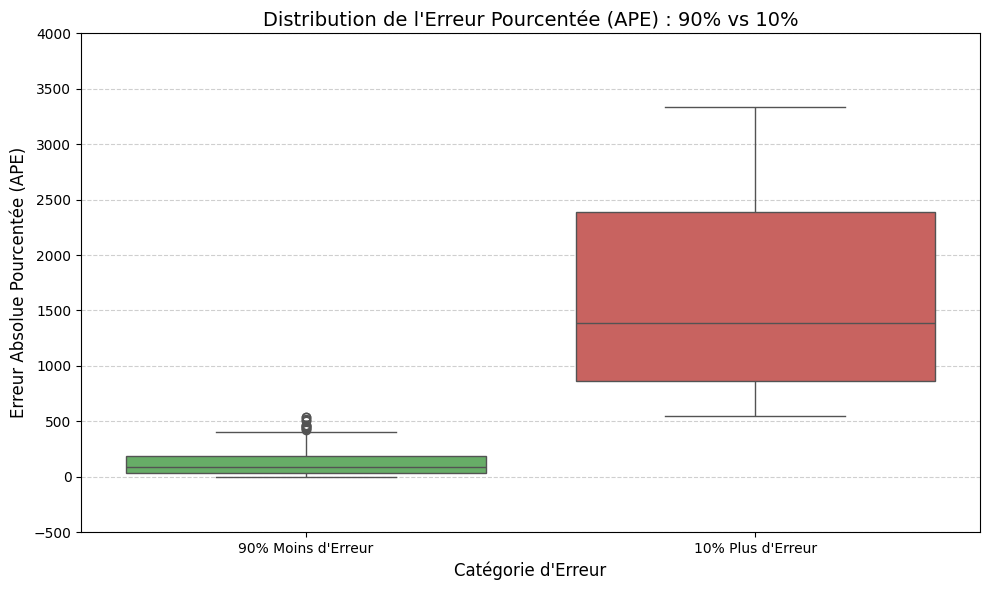

In [107]:


df_boxplot = pd.concat([df_90_percent_plot, df_10_percent_plot])



plt.figure(figsize=(10, 6))

sns.boxplot(
    x='Catégorie',
    y='erreur_pourcentage',
    data=df_boxplot,
    palette=['#5cb85c', '#d9534f'],
    order=['90% Moins d\'Erreur', '10% Plus d\'Erreur'],
    hue='Catégorie'
)

y_min = -500
y_max = 4000
plt.ylim(y_min, y_max) 

plt.title(f"Distribution de l'Erreur Pourcentée (APE) : 90% vs 10%", fontsize=14)
plt.xlabel("Catégorie d'Erreur", fontsize=12)
plt.ylabel("Erreur Absolue Pourcentée (APE)", fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

##### Ajout de la colonne de consommation par surface

In [108]:
df = building_consumption_clean.copy()

new_column = "SiteEnergyUseWN(kBtu/sf)" 

df[new_column] = df["SiteEnergyUseWN(kBtu)"] / df["PropertyGFATotal"]

serie = df[new_column]

df_without_leakage.loc[:, new_column] = serie.loc[df_without_leakage.index]

##### Analyse de la consommation par quartier

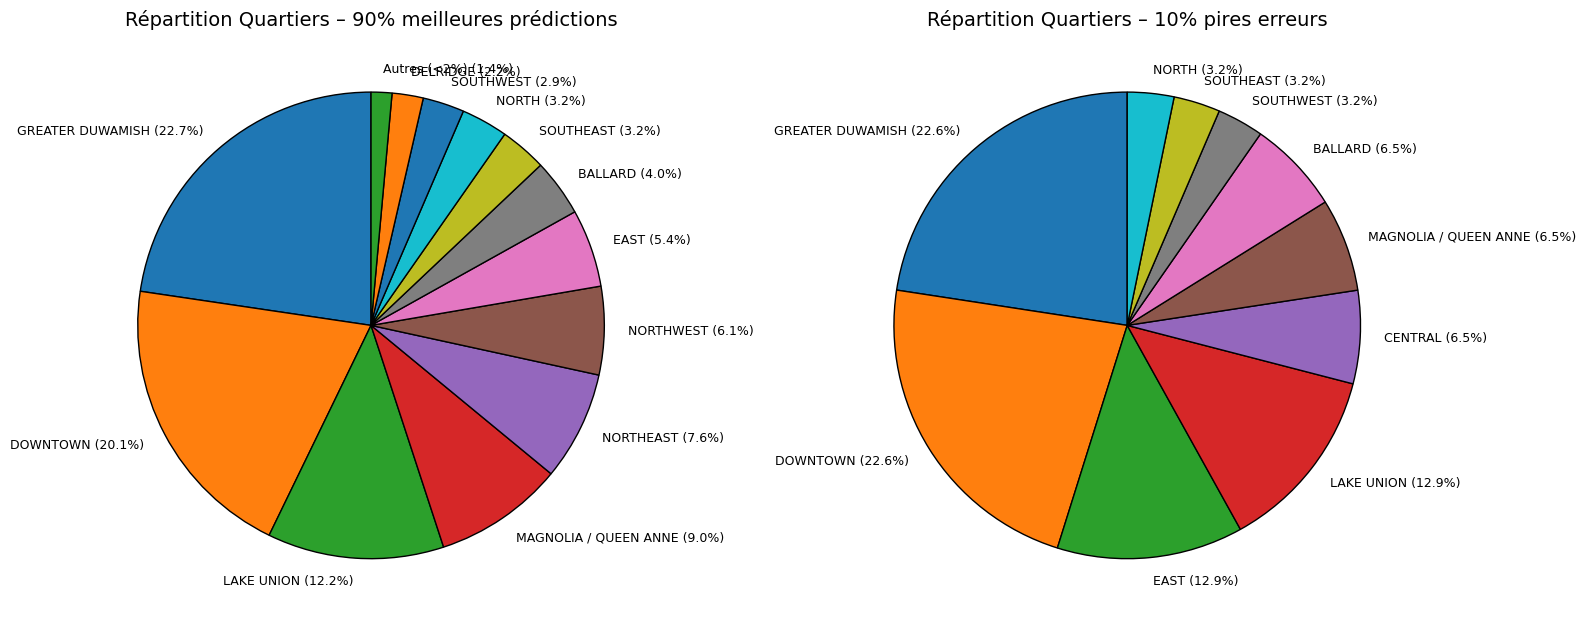

In [109]:

df_resultats_test["Neighborhood"] = df_combined["Neighborhood"]
df_combined["SiteEnergyUseWN(kBtu/sf)"] = df_without_leakage["Neighborhood"]

seuil_90 = df_resultats_test["erreur_pourcentage"].quantile(0.90)

df_90 = df_resultats_test[df_resultats_test["erreur_pourcentage"] <= seuil_90]
df_10 = df_resultats_test[df_resultats_test["erreur_pourcentage"] > seuil_90]

freq_90 = df_90["Neighborhood"].value_counts(normalize=True) * 100

main_90 = freq_90[freq_90 >= 2]
autres_90 = freq_90[freq_90 < 2].sum()
if autres_90 > 0:
    main_90["Autres (<2%)"] = autres_90

labels_90 = [f"{quartier} ({val:.1f}%)" for quartier, val in main_90.items()]

freq_10 = df_10["Neighborhood"].value_counts(normalize=True) * 100

main_10 = freq_10[freq_10 >= 2]
autres_10 = freq_10[freq_10 < 2].sum()
if autres_10 > 0:
    main_10["Autres (<2%)"] = autres_10

labels_10 = [f"{quartier} ({val:.1f}%)" for quartier, val in main_10.items()]

plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.pie(
    main_90.values,
    labels=labels_90,
    startangle=90,
    wedgeprops={'edgecolor': 'black'},
    textprops={'fontsize': 9}
)
plt.title("Répartition Quartiers – 90% meilleures prédictions", fontsize=14)

plt.subplot(1, 2, 2)
plt.pie(
    main_10.values,
    labels=labels_10,
    startangle=90,
    wedgeprops={'edgecolor': 'black'},
    textprops={'fontsize': 9}
)
plt.title("Répartition Quartiers – 10% pires erreurs", fontsize=14)

plt.tight_layout()
plt.show()


<Axes: xlabel='Neighborhood', ylabel='SiteEnergyUseWN(kBtu/sf)'>

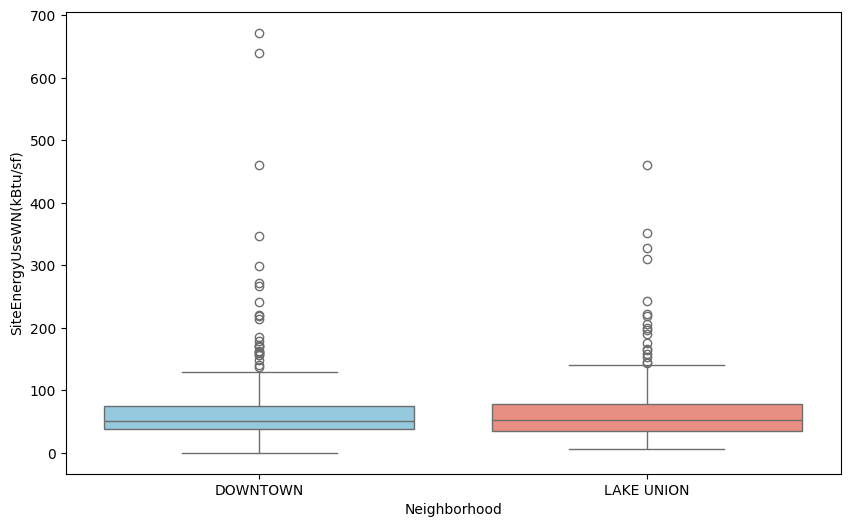

In [110]:
feature_col = 'Neighborhood'
neighborhoods = ['DOWNTOWN', 'LAKE UNION']

consommation_col = 'SiteEnergyUseWN(kBtu/sf)'

df_filtre = df[df[feature_col].isin(neighborhoods)]

plt.figure(figsize=(10, 6))

sns.boxplot(
    x=feature_col,
    y=consommation_col,
    data=df_filtre,
    palette=['skyblue', 'salmon'],
    hue=feature_col
)

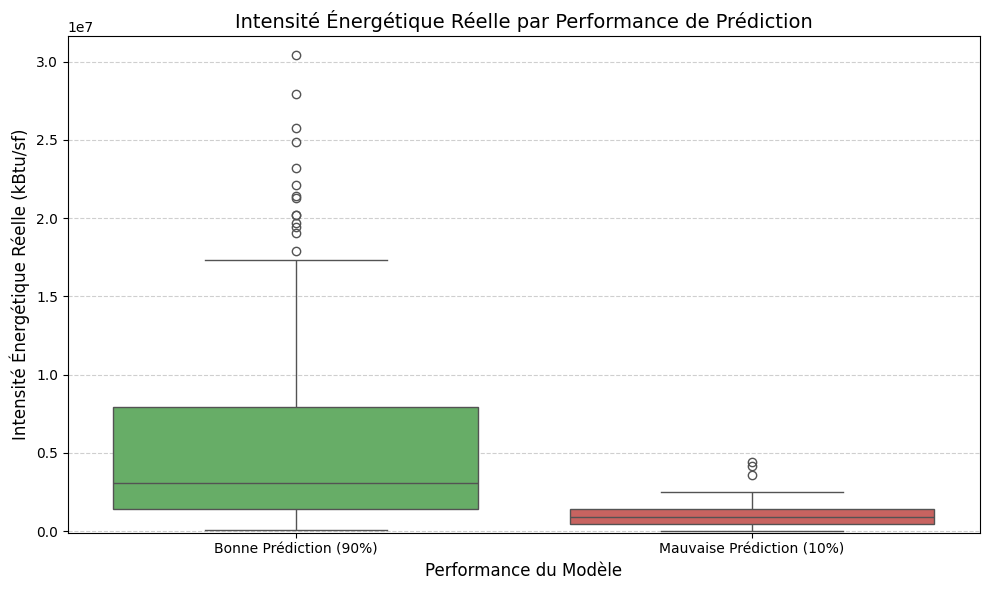

In [111]:
# La liste des index présents dans les deux DataFrames.
valid_90_indices = df_90_percent.index.intersection(df_combined.index)


valid_10_indices = df_10_percent.index.intersection(df_combined.index)


df_combined['Performance_Modele'] = '' 


df_combined.loc[valid_90_indices, 'Performance_Modele'] = 'Bonne Prédiction (90%)'


df_combined.loc[valid_10_indices, 'Performance_Modele'] = 'Mauvaise Prédiction (10%)'



y_column_name = 'SiteEnergyUseWN(kBtu)'

plt.figure(figsize=(10, 6))

sns.boxplot(
    x='Performance_Modele',
    y=y_column_name, 
    data=df_combined[df_combined['Performance_Modele'] != ''], 
    palette=['#5cb85c', '#d9534f'],
    order=['Bonne Prédiction (90%)', 'Mauvaise Prédiction (10%)'],
    hue='Performance_Modele'
)

y_min = -1e5
y_max = 10 ** 7.5
plt.ylim(y_min, y_max) 

plt.title("Intensité Énergétique Réelle par Performance de Prédiction", fontsize=14)
plt.xlabel("Performance du Modèle", fontsize=12)
plt.ylabel("Intensité Énergétique Réelle (kBtu/sf)", fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

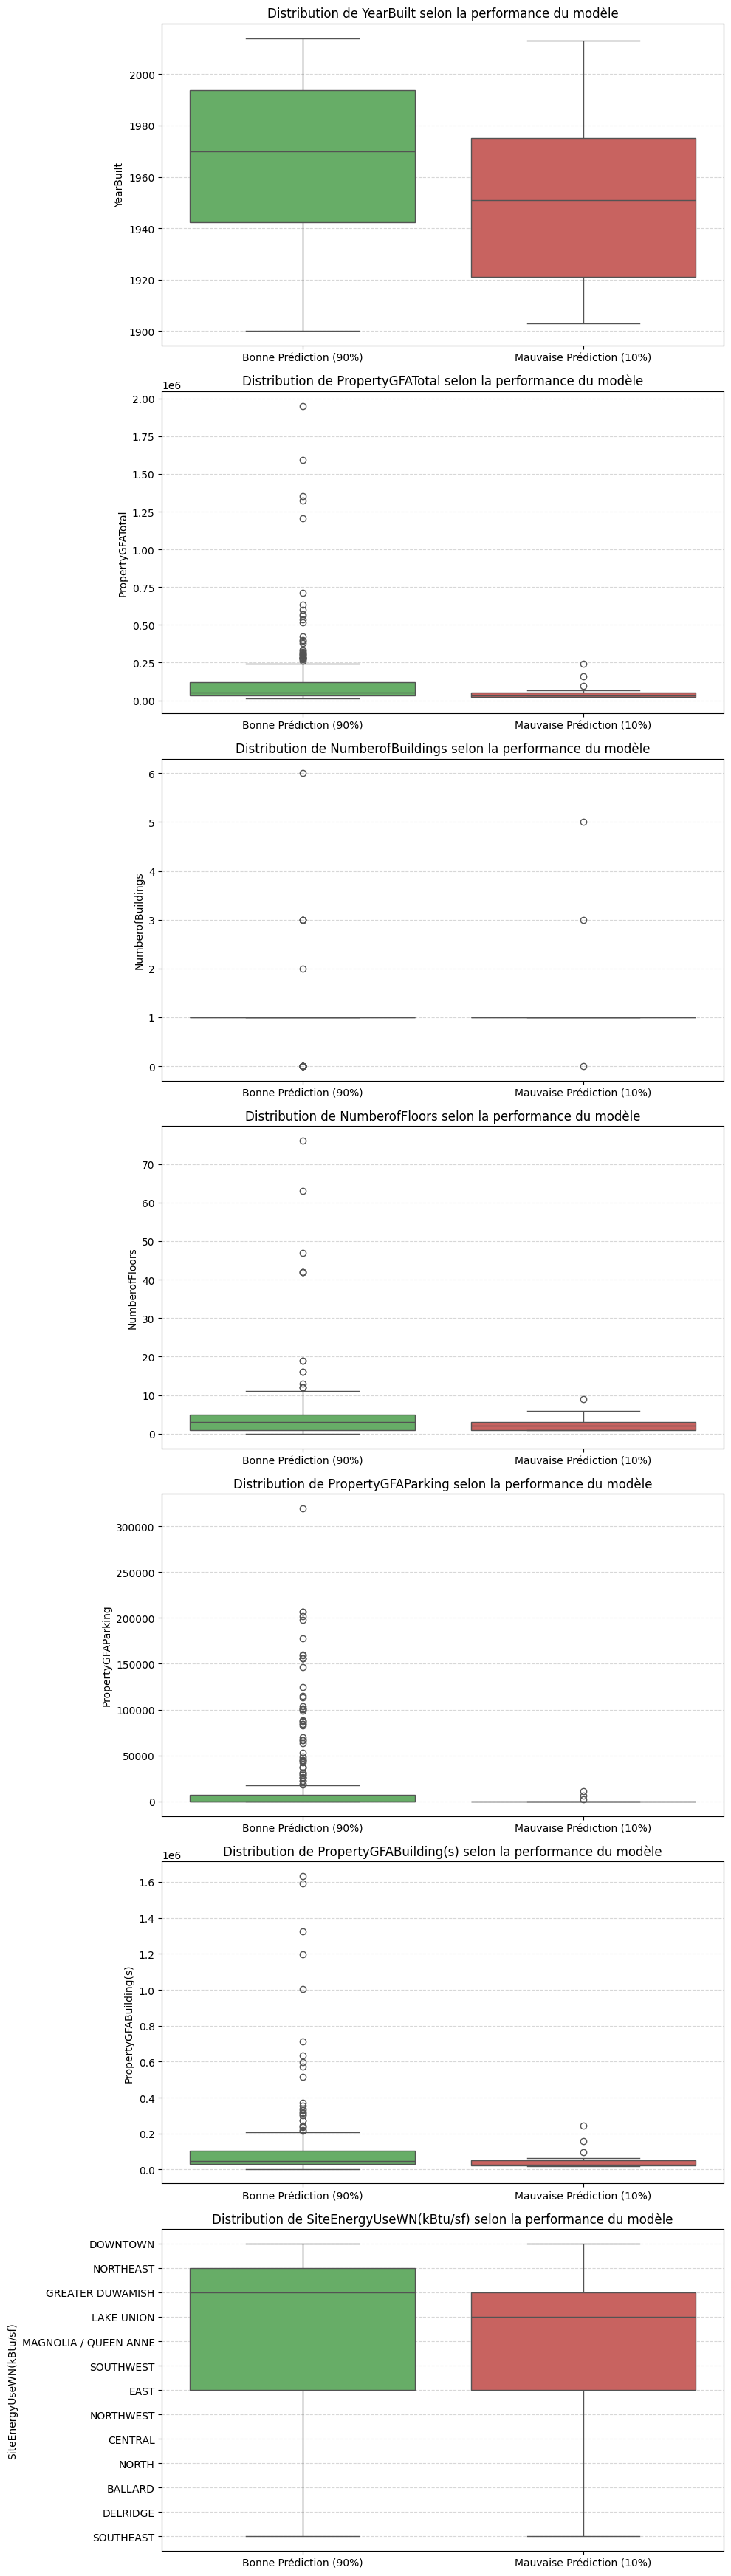

In [112]:
# Colonnes numériques à analyser
columns_cibles = [
    'YearBuilt',
    'PropertyGFATotal',
    'NumberofBuildings',
    'NumberofFloors',
    'PropertyGFAParking',
    'PropertyGFABuilding(s)',
    'SiteEnergyUseWN(kBtu/sf)'
]

performance_col = "Performance_Modele"
order_perf = ['Bonne Prédiction (90%)', 'Mauvaise Prédiction (10%)']

# Filtrer uniquement les lignes classées 90% / 10%
df_plot = df_combined[df_combined[performance_col].isin(order_perf)].copy()

fig, axes = plt.subplots(len(columns_cibles), 1, figsize=(10, 5 * len(columns_cibles)))
if len(columns_cibles) == 1:
    axes = [axes]  

# Tracer un boxplot pour chaque colonne
for ax, col in zip(axes, columns_cibles):
    sns.boxplot(
        data=df_plot,
        x=performance_col,
        y=col,
        hue=performance_col,
        order=order_perf,
        palette=['#5cb85c', '#d9534f'],
        ax=ax
    )
    ax.set_title(f"Distribution de {col} selon la performance du modèle")
    ax.set_xlabel("")
    ax.set_ylabel(col)
    ax.grid(axis="y", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()


##### Analyse de la consommation par LargestPropertyUseType

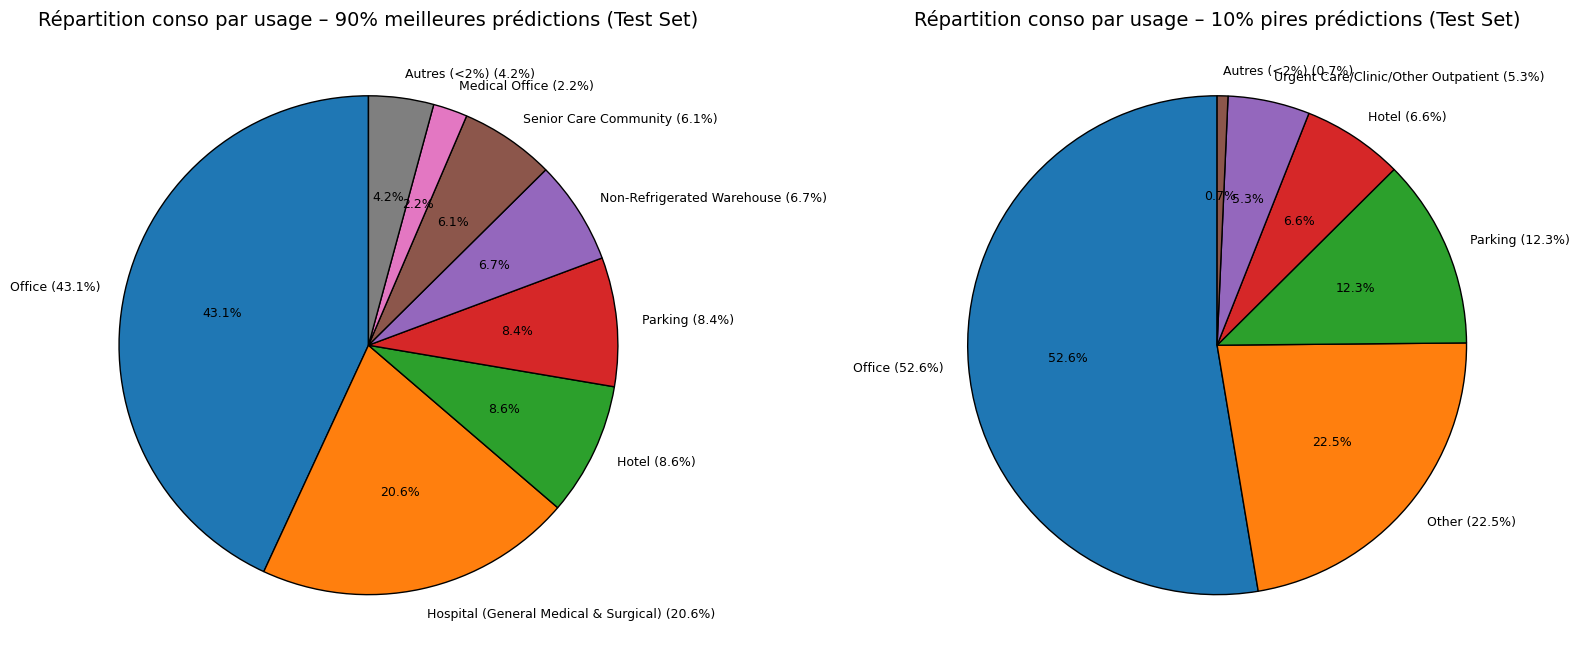

In [113]:
# Définition des colonnes
largest_use_col = 'LargestPropertyUseType'
conso_col = 'SiteEnergyUseWN(kBtu)'

df_resultats_test = pd.DataFrame({
    # y_test contient les vraies valeurs du jeu de test (la vérité terrain)
    'y_reel': y_test.values,
    
    # y_prediction_test contient les prédictions correspondantes du jeu de test
    'y_predict': y_prediction_test,
})
# Ajout de LargestPropertyUseType et consommation réelle
df_resultats_test[largest_use_col] = X_test[largest_use_col]
df_resultats_test["Consommation_reel"] = y_test 


df_resultats_test['erreur_pourcentage'] = (
    np.abs(df_resultats_test['y_reel'] - df_resultats_test['y_predict']) / df_resultats_test['y_reel']
) * 100
# Calcul du seuil des 90% meilleures prédictions
seuil_90 = df_resultats_test["erreur_pourcentage"].quantile(0.90)
df_90 = df_resultats_test[df_resultats_test["erreur_pourcentage"] <= seuil_90].copy()
df_10 = df_resultats_test[df_resultats_test["erreur_pourcentage"] > seuil_90].copy()


# Calcul des pourcentages par type d'usage
freq_90 = df_90.groupby(largest_use_col)["Consommation_reel"].sum()
freq_90 = 100 * freq_90 / freq_90.sum()
freq_90 = freq_90.sort_values(ascending=False)

# Regrouper les petites catégories (<2%)
main_90 = freq_90[freq_90 >= 2]
autres_90 = freq_90[freq_90 < 2].sum()
if autres_90 > 0:
    main_90[f"Autres (<2%)"] = autres_90


labels_90 = [f"{cat} ({val:.1f}%)" for cat, val in main_90.items()]
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.pie(
    main_90.values,
    labels=labels_90,
    startangle=90,
    wedgeprops={'edgecolor': 'black'},
    textprops={'fontsize': 9},
    autopct='%.1f%%'
)
plt.title("Répartition conso par usage – 90% meilleures prédictions (Test Set)", fontsize=14)

# --- Tracé du second camembert (10% pires prédictions) ---
freq_10 = df_10.groupby(largest_use_col)["Consommation_reel"].sum()
freq_10 = 100 * freq_10 / freq_10.sum()
freq_10 = freq_10.sort_values(ascending=False)

main_10 = freq_10[freq_10 >= 2]
autres_10 = freq_10[freq_10 < 2].sum()
if autres_10 > 0:
    main_10[f"Autres (<2%)"] = autres_10

labels_10 = [f"{cat} ({val:.1f}%)" for cat, val in main_10.items()]
plt.subplot(1, 2, 2)
plt.pie(
    main_10.values,
    labels=labels_10,
    startangle=90,
    wedgeprops={'edgecolor': 'black'},
    textprops={'fontsize': 9},
    autopct='%.1f%%'
)
plt.title("Répartition conso par usage – 10% pires prédictions (Test Set)", fontsize=14)

plt.tight_layout()
plt.show()


##### Analyse de la consommation par PrimaryPropertyType

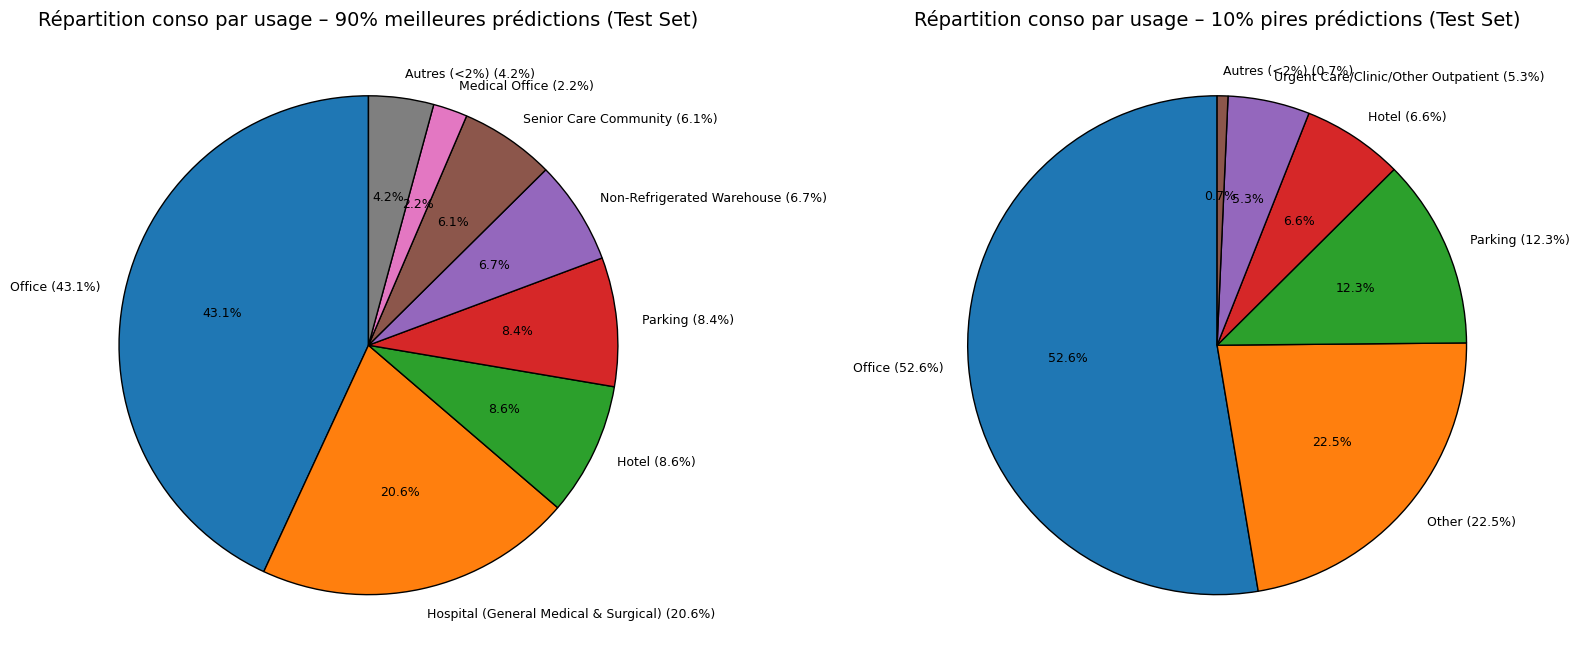

In [114]:

df_resultats_test["PrimaryPropertyType"] = df_combined["PrimaryPropertyType"]
df_resultats_test["Consommation_reel"] = df_combined["SiteEnergyUseWN(kBtu)"]

# Ajout de LargestPropertyUseType et consommation réelle
df_resultats_test[largest_use_col] = X_test[largest_use_col]
df_resultats_test["Consommation_reel"] = y_test 

# Calcul du seuil des 90% meilleures prédictions
seuil_90 = df_resultats_test["erreur_pourcentage"].quantile(0.90)
df_90 = df_resultats_test[df_resultats_test["erreur_pourcentage"] <= seuil_90].copy()
df_10 = df_resultats_test[df_resultats_test["erreur_pourcentage"] > seuil_90].copy()


# Calcul des pourcentages par type d'usage
freq_90 = df_90.groupby(largest_use_col)["Consommation_reel"].sum()
freq_90 = 100 * freq_90 / freq_90.sum()
freq_90 = freq_90.sort_values(ascending=False)

# Regrouper les petites catégories (<2%)
main_90 = freq_90[freq_90 >= 2]
autres_90 = freq_90[freq_90 < 2].sum()
if autres_90 > 0:
    main_90[f"Autres (<2%)"] = autres_90


labels_90 = [f"{cat} ({val:.1f}%)" for cat, val in main_90.items()]
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.pie(
    main_90.values,
    labels=labels_90,
    startangle=90,
    wedgeprops={'edgecolor': 'black'},
    textprops={'fontsize': 9},
    autopct='%.1f%%'
)
plt.title("Répartition conso par usage – 90% meilleures prédictions (Test Set)", fontsize=14)

# --- Tracé du second camembert (10% pires prédictions) ---
freq_10 = df_10.groupby(largest_use_col)["Consommation_reel"].sum()
freq_10 = 100 * freq_10 / freq_10.sum()
freq_10 = freq_10.sort_values(ascending=False)

main_10 = freq_10[freq_10 >= 2]
autres_10 = freq_10[freq_10 < 2].sum()
if autres_10 > 0:
    main_10[f"Autres (<2%)"] = autres_10

labels_10 = [f"{cat} ({val:.1f}%)" for cat, val in main_10.items()]
plt.subplot(1, 2, 2)
plt.pie(
    main_10.values,
    labels=labels_10,
    startangle=90,
    wedgeprops={'edgecolor': 'black'},
    textprops={'fontsize': 9},
    autopct='%.1f%%'
)
plt.title("Répartition conso par usage – 10% pires prédictions (Test Set)", fontsize=14)

plt.tight_layout()
plt.show()

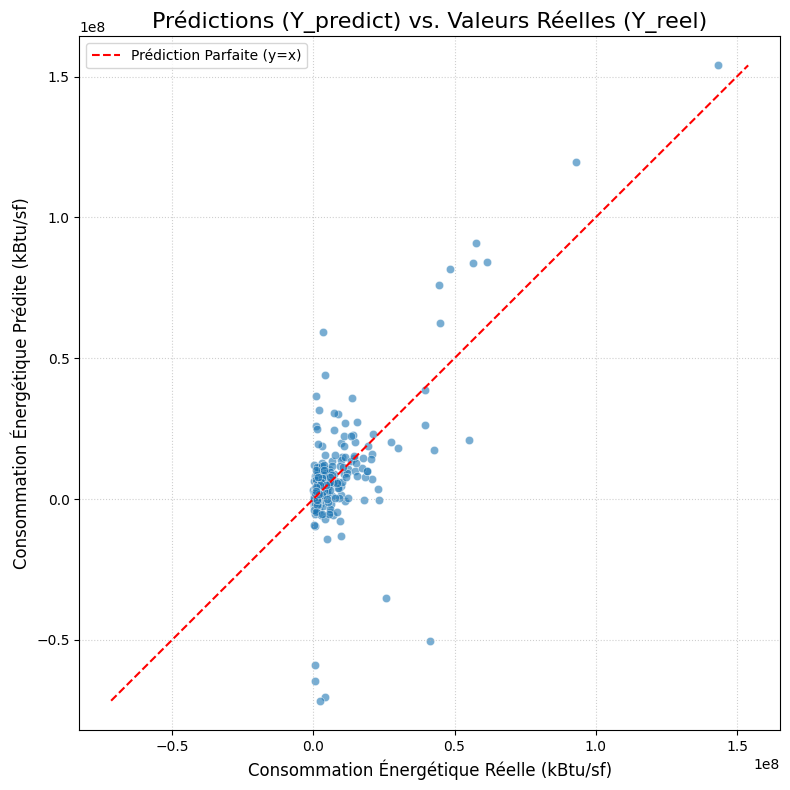

In [115]:

y_reel = df_resultats_test['y_reel']
y_prediction = df_resultats_test['y_predict']

plt.figure(figsize=(8, 8))

sns.scatterplot(
    x=y_reel, 
    y=y_prediction, 
    alpha=0.6, 
    edgecolor='w'
)

#Ajout de la Droite Parfaite (y=x).
max_val = max(y_reel.max(), y_prediction.max())
min_val = min(y_reel.min(), y_prediction.min())

plt.plot(
    [min_val, max_val], 
    [min_val, max_val], 
    color='red', 
    linestyle='--', 
    label='Prédiction Parfaite (y=x)'
)


plt.title("Prédictions (Y_predict) vs. Valeurs Réelles (Y_reel)", fontsize=16)
plt.xlabel("Consommation Énergétique Réelle (kBtu/sf)", fontsize=12)
plt.ylabel("Consommation Énergétique Prédite (kBtu/sf)", fontsize=12)

plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.axis('equal') 
plt.tight_layout()
plt.show()

Ce graphique nous confirme qu'on ne peut pas trouver de lien via ce modèle de régression linéaire.

#### Création d'une fonction permettant d'être appelée pour chaque modèle

In [116]:
def train_and_evaluate_model(model, X, y, model_name):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Entraînement
    model.fit(X_train, y_train)

    # Prédictions
    y_test_pred = model.predict(X_test)

    # Cross-validation (on ajoute le MSE ici)
    cv_results = cross_validate(
        model, X, y, cv=5,
        scoring={
            'r2': 'r2',
            'rmse': 'neg_root_mean_squared_error',
            'mse': 'neg_mean_squared_error',
            'mae': 'neg_mean_absolute_error'
        },
        n_jobs=-1
    )

    # Retourne un dictionnaire avec toutes les métriques moyennes de la CV
    return {
        "Modèle": model_name,
        "R2 CV": cv_results['test_r2'].mean(),
        "MAE CV": -cv_results['test_mae'].mean(),
        "MSE CV": -cv_results['test_mse'].mean(),
        "RMSE CV": -cv_results['test_rmse'].mean()
    }

Les données sont séparées en un jeu d’entraînement (80 %) et un jeu de test (20 %).  

En complément :  
  
Nous utilisons la méthode **cross_validate** avec 5 folds  
Cela permet de mesurer la robustesse du modèle et de limiter les effets de sur-apprentissage

#### Ajout des colonnes de Feature Engineering

In [117]:
cols_energy = [
    'SiteEnergyUseWN(kBtu)',
    'SteamUse(kBtu)',
    'Electricity(kBtu)',
    'NaturalGas(kBtu)'
]

df_without_leakage = df_without_leakage.join(
    building_consumption_clean[cols_energy],
    how="left"
)

In [118]:
# Ajout des colonnes % UseType: 
df_without_leakage["TotalUseTypePct"] = (df_without_leakage["PropertyGFATotal"] / df_without_leakage["PropertyGFATotal"])*100
df_without_leakage["PrimaryUseTypePct"] = (df_without_leakage["LargestPropertyUseTypeGFA"] / df_without_leakage["PropertyGFATotal"])*100
df_without_leakage["SecondaryUseTypePct"] = (df_without_leakage["SecondLargestPropertyUseTypeGFA"] / df_without_leakage["PropertyGFATotal"])*100
df_without_leakage["ThirdUseTypePct"]   = (df_without_leakage["ThirdLargestPropertyUseTypeGFA"]   / df_without_leakage["PropertyGFATotal"])*100

In [119]:
# Ajout des colonnes % UseType:
df_without_leakage["ElectricUsePct"] = ( df_without_leakage['Electricity(kBtu)'] / df_without_leakage["SiteEnergyUseWN(kBtu)"])*100
df_without_leakage["SteamUsePct"]  = ( df_without_leakage['SteamUse(kBtu)']  / df_without_leakage["SiteEnergyUseWN(kBtu)"])*100
df_without_leakage["GasUsePct"]   = (df_without_leakage["NaturalGas(kBtu)"]   / df_without_leakage["SiteEnergyUseWN(kBtu)"])*100

**Faire OneHotEncoder sur les PropertyUseType x %UseTypeGFA ( sommer Primary,Secondary,Third)**

In [120]:
cols_to_drop=['SiteEnergyUseWN(kBtu/sf)','SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)',
       'Electricity(kBtu)', 'NaturalGas(kBtu)', 'ListOfAllPropertyUseTypes']
df_to_train= df_without_leakage.drop(columns=cols_to_drop)
building_consumption_clean= building_consumption_clean.drop(columns='ListOfAllPropertyUseTypes')

In [121]:
numeric_columns = df_to_train.select_dtypes(include=np.number).columns.tolist()
categorical_columns = df_to_train.select_dtypes(exclude=np.number).columns.tolist()

#### Pipeline de Régression Linéaire

In [122]:
models = {
    "Régression Linéaire": pipeline,
}

# 2. On vide la liste de résultats
results = []

# 3. On lance la boucle
for name, model in models.items():
    print(f"Entraînement de : {name}...")
    res = train_and_evaluate_model(
        model=model, # On utilise bien l'argument de la boucle
        X=X, 
        y=y, 
        model_name=name
    )
    results.append(res)

# 4. CRUCIAL : On crée le DataFrame à partir de la NOUVELLE liste
df_results = pd.DataFrame(results)

# 5. Tri et affichage
df_results = df_results.sort_values(by='R2 CV', ascending=False)
df_results


Entraînement de : Régression Linéaire...


Modèle     R2 CV        MAE CV        MSE CV       RMSE CV
0  Régression Linéaire -0.488602  6.391177e+06  2.352204e+14  1.445987e+07

Le R² étant négatif, on peut supposer que d'autres modèles peuvent être plus adapté dans notre cas.

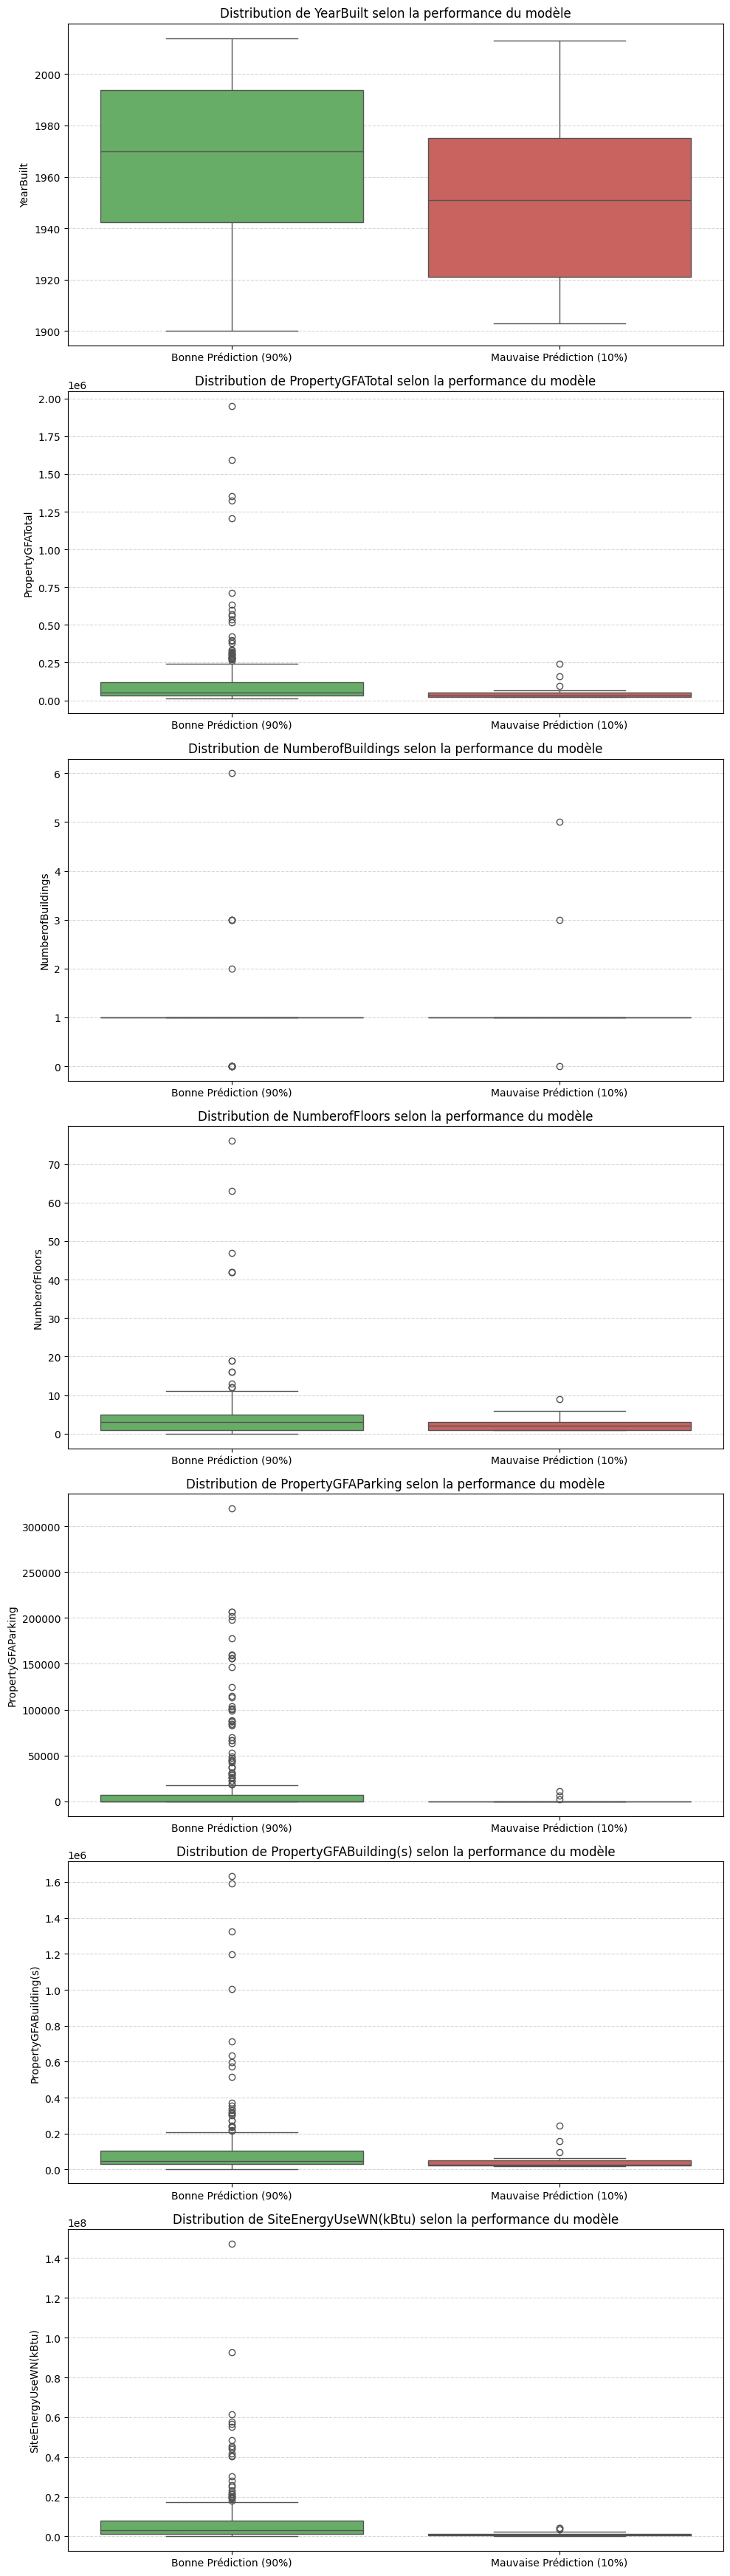

In [123]:
# Colonnes numériques à analyser
columns_cibles = [
    'YearBuilt',
    'PropertyGFATotal',
    'NumberofBuildings',
    'NumberofFloors',
    'PropertyGFAParking',
    'PropertyGFABuilding(s)',
    'SiteEnergyUseWN(kBtu)'
]

performance_col = "Performance_Modele"
order_perf = ['Bonne Prédiction (90%)', 'Mauvaise Prédiction (10%)']

# Filtrer uniquement les lignes classées 90% / 10%
df_plot = df_combined[df_combined[performance_col].isin(order_perf)].copy()

fig, axes = plt.subplots(len(columns_cibles), 1, figsize=(10, 5 * len(columns_cibles)))
if len(columns_cibles) == 1:
    axes = [axes]  

# Tracer un boxplot pour chaque colonne
for ax, col in zip(axes, columns_cibles):
    sns.boxplot(
        data=df_plot,
        x=performance_col,
        y=col,
        hue=performance_col,
        order=order_perf,
        palette=['#5cb85c', '#d9534f'],
        ax=ax
    )
    ax.set_title(f"Distribution de {col} selon la performance du modèle")
    ax.set_xlabel("")
    ax.set_ylabel(col)
    ax.grid(axis="y", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()


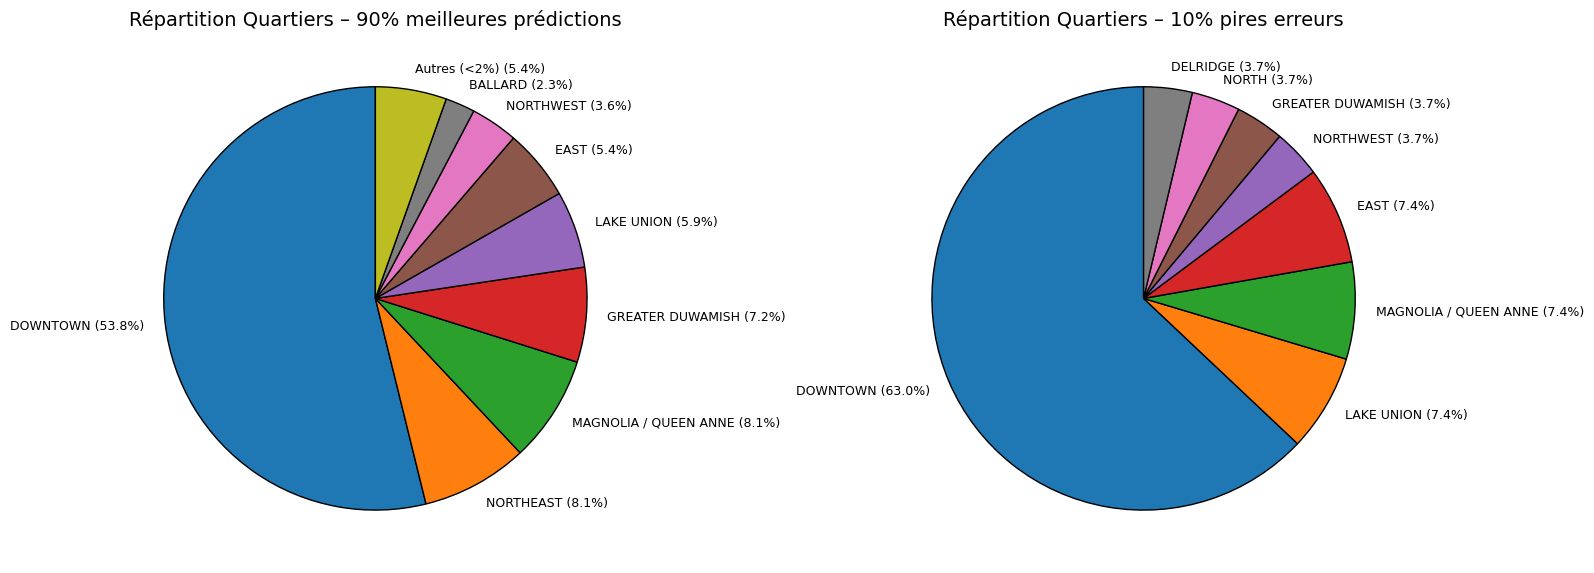

In [124]:

df_resultats_test["Neighborhood"] = df_combined["Neighborhood"]
df_combined["SiteEnergyUseWN(kBtu)"] = df_without_leakage["Neighborhood"]

seuil_90 = df_resultats_test["erreur_pourcentage"].quantile(0.90)

df_90 = df_resultats_test[df_resultats_test["erreur_pourcentage"] <= seuil_90]
df_10 = df_resultats_test[df_resultats_test["erreur_pourcentage"] > seuil_90]

freq_90 = df_90["Neighborhood"].value_counts(normalize=True) * 100

main_90 = freq_90[freq_90 >= 2]
autres_90 = freq_90[freq_90 < 2].sum()
if autres_90 > 0:
    main_90["Autres (<2%)"] = autres_90

labels_90 = [f"{quartier} ({val:.1f}%)" for quartier, val in main_90.items()]

freq_10 = df_10["Neighborhood"].value_counts(normalize=True) * 100

main_10 = freq_10[freq_10 >= 2]
autres_10 = freq_10[freq_10 < 2].sum()
if autres_10 > 0:
    main_10["Autres (<2%)"] = autres_10

labels_10 = [f"{quartier} ({val:.1f}%)" for quartier, val in main_10.items()]

plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.pie(
    main_90.values,
    labels=labels_90,
    startangle=90,
    wedgeprops={'edgecolor': 'black'},
    textprops={'fontsize': 9}
)
plt.title("Répartition Quartiers – 90% meilleures prédictions", fontsize=14)

plt.subplot(1, 2, 2)
plt.pie(
    main_10.values,
    labels=labels_10,
    startangle=90,
    wedgeprops={'edgecolor': 'black'},
    textprops={'fontsize': 9}
)
plt.title("Répartition Quartiers – 10% pires erreurs", fontsize=14)

plt.tight_layout()
plt.show()


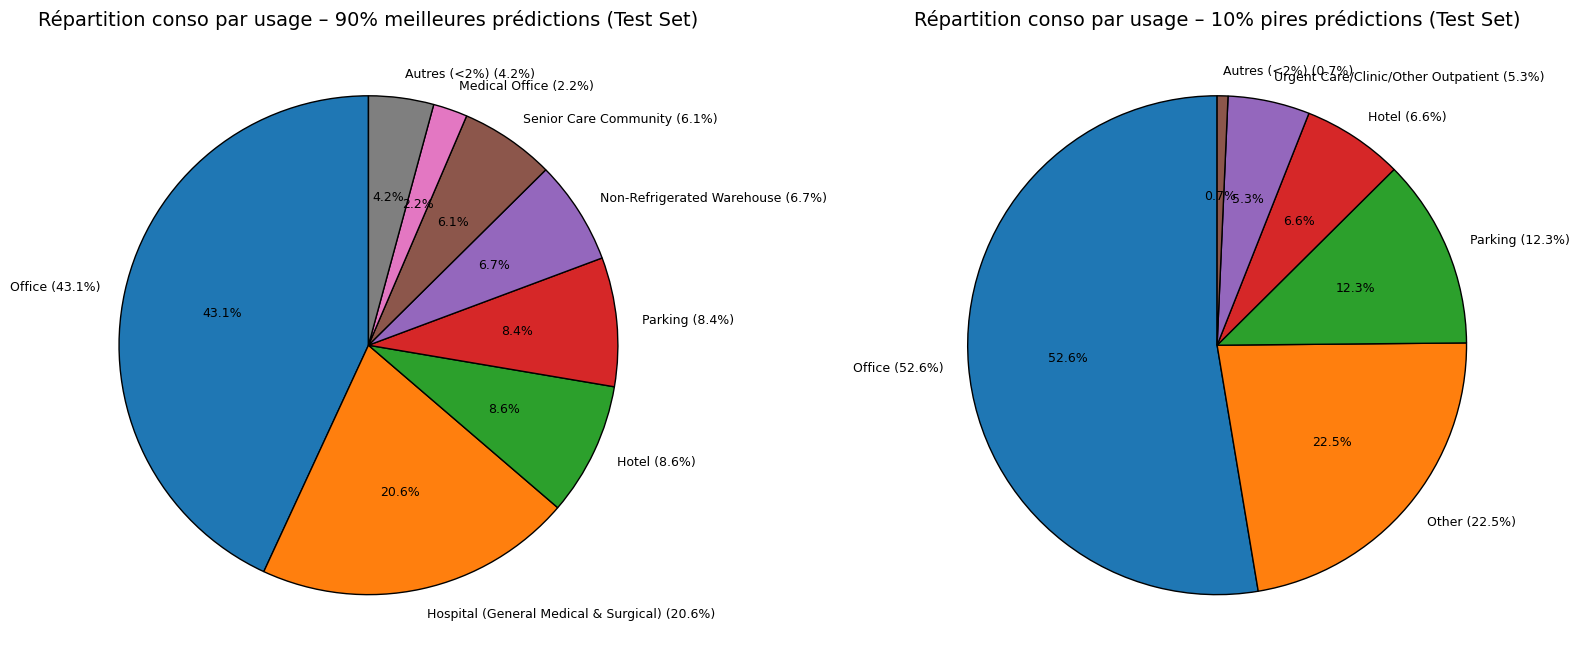

In [125]:
# Définition des colonnes
largest_use_col = 'LargestPropertyUseType'
conso_col = 'SiteEnergyUseWN(kBtu)'

# Ajout de LargestPropertyUseType et consommation réelle
df_resultats_test[largest_use_col] = X_test[largest_use_col]
df_resultats_test["Consommation_reel"] = y_test 

# Calcul du seuil des 90% meilleures prédictions
seuil_90 = df_resultats_test["erreur_pourcentage"].quantile(0.90)
df_90 = df_resultats_test[df_resultats_test["erreur_pourcentage"] <= seuil_90].copy()
df_10 = df_resultats_test[df_resultats_test["erreur_pourcentage"] > seuil_90].copy()


# Calcul des pourcentages par type d'usage
freq_90 = df_90.groupby(largest_use_col)["Consommation_reel"].sum()
freq_90 = 100 * freq_90 / freq_90.sum()
freq_90 = freq_90.sort_values(ascending=False)

# Regrouper les petites catégories (<2%)
main_90 = freq_90[freq_90 >= 2]
autres_90 = freq_90[freq_90 < 2].sum()
if autres_90 > 0:
    main_90[f"Autres (<2%)"] = autres_90


labels_90 = [f"{cat} ({val:.1f}%)" for cat, val in main_90.items()]
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.pie(
    main_90.values,
    labels=labels_90,
    startangle=90,
    wedgeprops={'edgecolor': 'black'},
    textprops={'fontsize': 9},
    autopct='%.1f%%'
)
plt.title("Répartition conso par usage – 90% meilleures prédictions (Test Set)", fontsize=14)

# --- Tracé du second camembert (10% pires prédictions) ---
freq_10 = df_10.groupby(largest_use_col)["Consommation_reel"].sum()
freq_10 = 100 * freq_10 / freq_10.sum()
freq_10 = freq_10.sort_values(ascending=False)

main_10 = freq_10[freq_10 >= 2]
autres_10 = freq_10[freq_10 < 2].sum()
if autres_10 > 0:
    main_10[f"Autres (<2%)"] = autres_10

labels_10 = [f"{cat} ({val:.1f}%)" for cat, val in main_10.items()]
plt.subplot(1, 2, 2)
plt.pie(
    main_10.values,
    labels=labels_10,
    startangle=90,
    wedgeprops={'edgecolor': 'black'},
    textprops={'fontsize': 9},
    autopct='%.1f%%'
)
plt.title("Répartition conso par usage – 10% pires prédictions (Test Set)", fontsize=14)

plt.tight_layout()
plt.show()

#### Graphique de comparaison entre Y-predict et Y-reel

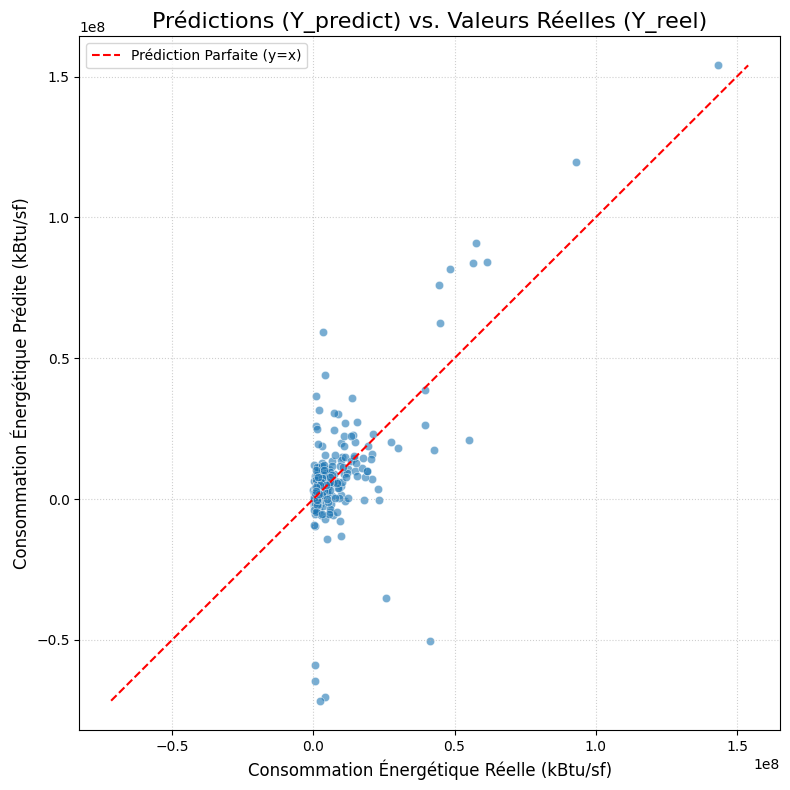

In [126]:

y_reel = df_resultats_test['y_reel']
y_pred_lr = pipeline.predict(X_test)

plt.figure(figsize=(8, 8))

sns.scatterplot(
    x=y_reel, 
    y=y_pred_lr, 
    alpha=0.6, 
    edgecolor='w'
)

#Ajout de la Droite Parfaite (y=x).
max_val = max(y_reel.max(), y_pred_lr.max())
min_val = min(y_reel.min(), y_pred_lr.min())

plt.plot(
    [min_val, max_val], 
    [min_val, max_val], 
    color='red', 
    linestyle='--', 
    label='Prédiction Parfaite (y=x)'
)


plt.title("Prédictions (Y_predict) vs. Valeurs Réelles (Y_reel)", fontsize=16)
plt.xlabel("Consommation Énergétique Réelle (kBtu/sf)", fontsize=12)
plt.ylabel("Consommation Énergétique Prédite (kBtu/sf)", fontsize=12)

plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.axis('equal') 
plt.tight_layout()
plt.show()

**L'analyse graphique nous montre que le modèle de Régression Linéaire semble peu adapté à notre projet.**

### Modèle Arbres 

#### Gradient Boost

##### Pipeline de Gradien Boost

In [127]:
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns
categorical_features = X.select_dtypes(include=["object", "category"]).columns

gbr_model = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    random_state=42
)

pipeline_gbr = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", gbr_model)
])

models = {
    "GradianBoost": pipeline_gbr,
}

results = []

for name, model in models.items():
    print(f"Entraînement de : {name}...")
    res = train_and_evaluate_model(
        model=model, 
        X=X, 
        y=y, 
        model_name=name
    )
    results.append(res)

df_results = pd.DataFrame(results)

# 5. Tri et affichage
df_results = df_results.sort_values(by='R2 CV', ascending=False)
df_results

Entraînement de : GradianBoost...


Modèle     R2 CV        MAE CV        MSE CV       RMSE CV
0  GradianBoost  0.613052  3.612826e+06  1.159658e+14  9.312583e+06

##### Calcul du R²

In [128]:
scoring = {
    'r2': 'r2',
    'rmse': 'neg_root_mean_squared_error',
    'mae': 'neg_mean_absolute_error'
}

cv_results = cross_validate(
    estimator=pipeline_gbr,
    X=X,
    y=y,
    cv=5,
    scoring=scoring,
    return_train_score=True,
    n_jobs=-1
)
cv_df = pd.DataFrame({
    'R2_train': cv_results['train_r2'],
    'R2_test': cv_results['test_r2'],
    'RMSE_test': -cv_results['test_rmse'],
    'MAE_test': -cv_results['test_mae']
})

cv_df.mean()

R2_train     9.816732e-01
R2_test      6.130523e-01
RMSE_test    9.312583e+06
MAE_test     3.612826e+06
dtype: float64

**Le R² étant plus proche de 1 que pour la régression linéaire. On peut penser que c'est un bon modèle pour notre projet.**

##### Analyse des résultats du modèle

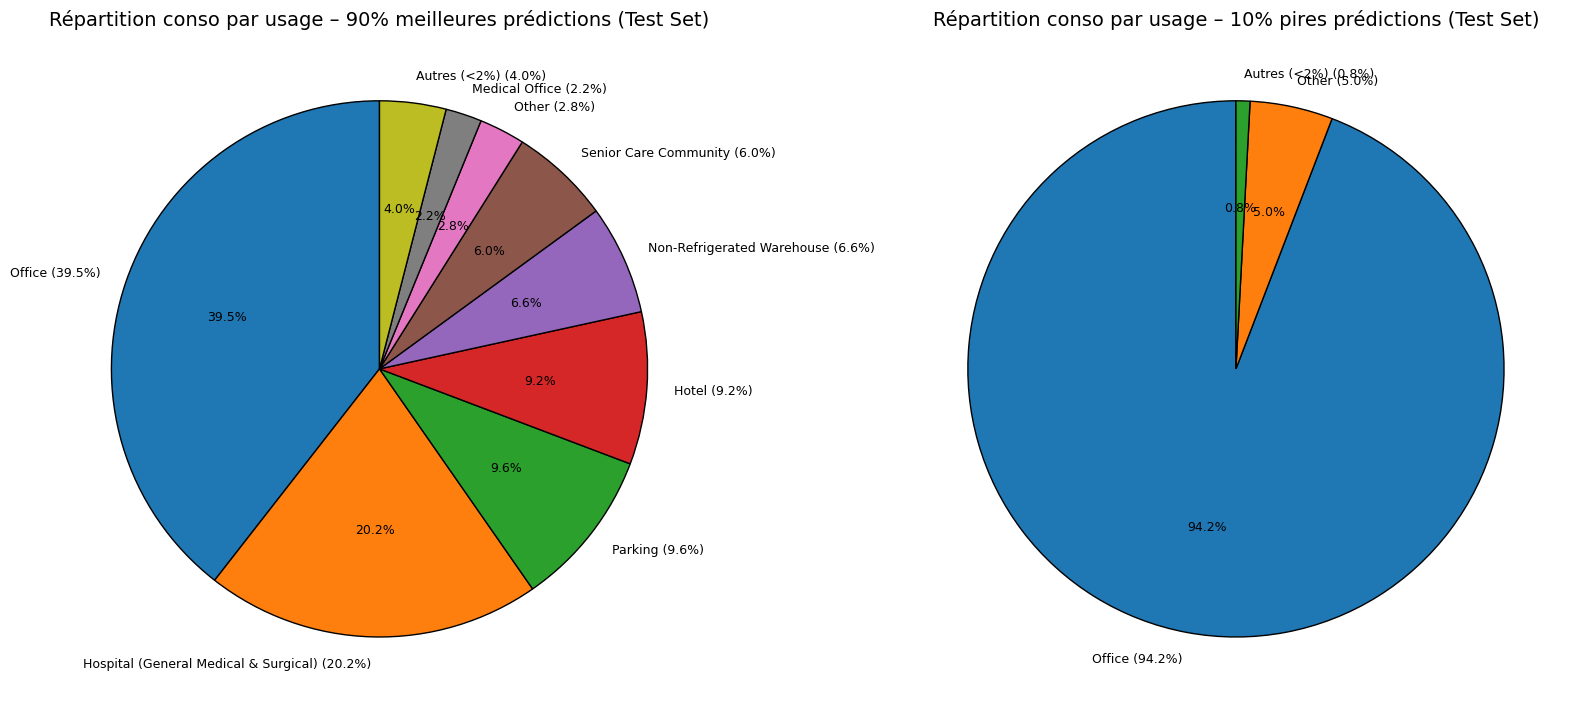

In [129]:
y_reel = y_test
y_pred_rf = pipeline_gbr.predict(X_test)

# Définition des colonnes
largest_use_col = 'LargestPropertyUseType'
conso_col = 'SiteEnergyUseWN(kBtu)'

df_resultats_test = pd.DataFrame({
    # y_test contient les vraies valeurs du jeu de test (la vérité terrain)
    'y_reel': y_test.values,
    
    # y_prediction_test contient les prédictions correspondantes du jeu de test
    'y_pred_rf': y_pred_rf,
})

df_resultats_test['erreur_pourcentage'] = (
    np.abs(df_resultats_test['y_reel'] - df_resultats_test['y_pred_rf']) / df_resultats_test['y_reel']
) * 100
# Ajout de LargestPropertyUseType et consommation réelle
df_resultats_test[largest_use_col] = X_test[largest_use_col]
df_resultats_test["Consommation_reel"] = y_test 

# Calcul du seuil des 90% meilleures prédictions
seuil_90 = df_resultats_test["erreur_pourcentage"].quantile(0.90)
df_90 = df_resultats_test[df_resultats_test["erreur_pourcentage"] <= seuil_90].copy()
df_10 = df_resultats_test[df_resultats_test["erreur_pourcentage"] > seuil_90].copy()


# Calcul des pourcentages par type d'usage
freq_90 = df_90.groupby(largest_use_col)["Consommation_reel"].sum()
freq_90 = 100 * freq_90 / freq_90.sum()
freq_90 = freq_90.sort_values(ascending=False)

# Regrouper les petites catégories (<2%)
main_90 = freq_90[freq_90 >= 2]
autres_90 = freq_90[freq_90 < 2].sum()
if autres_90 > 0:
    main_90[f"Autres (<2%)"] = autres_90


labels_90 = [f"{cat} ({val:.1f}%)" for cat, val in main_90.items()]
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.pie(
    main_90.values,
    labels=labels_90,
    startangle=90,
    wedgeprops={'edgecolor': 'black'},
    textprops={'fontsize': 9},
    autopct='%.1f%%'
)
plt.title("Répartition conso par usage – 90% meilleures prédictions (Test Set)", fontsize=14)

# --- Tracé du second camembert (10% pires prédictions) ---
freq_10 = df_10.groupby(largest_use_col)["Consommation_reel"].sum()
freq_10 = 100 * freq_10 / freq_10.sum()
freq_10 = freq_10.sort_values(ascending=False)

main_10 = freq_10[freq_10 >= 2]
autres_10 = freq_10[freq_10 < 2].sum()
if autres_10 > 0:
    main_10[f"Autres (<2%)"] = autres_10

labels_10 = [f"{cat} ({val:.1f}%)" for cat, val in main_10.items()]
plt.subplot(1, 2, 2)
plt.pie(
    main_10.values,
    labels=labels_10,
    startangle=90,
    wedgeprops={'edgecolor': 'black'},
    textprops={'fontsize': 9},
    autopct='%.1f%%'
)
plt.title("Répartition conso par usage – 10% pires prédictions (Test Set)", fontsize=14)

plt.tight_layout()
plt.show()







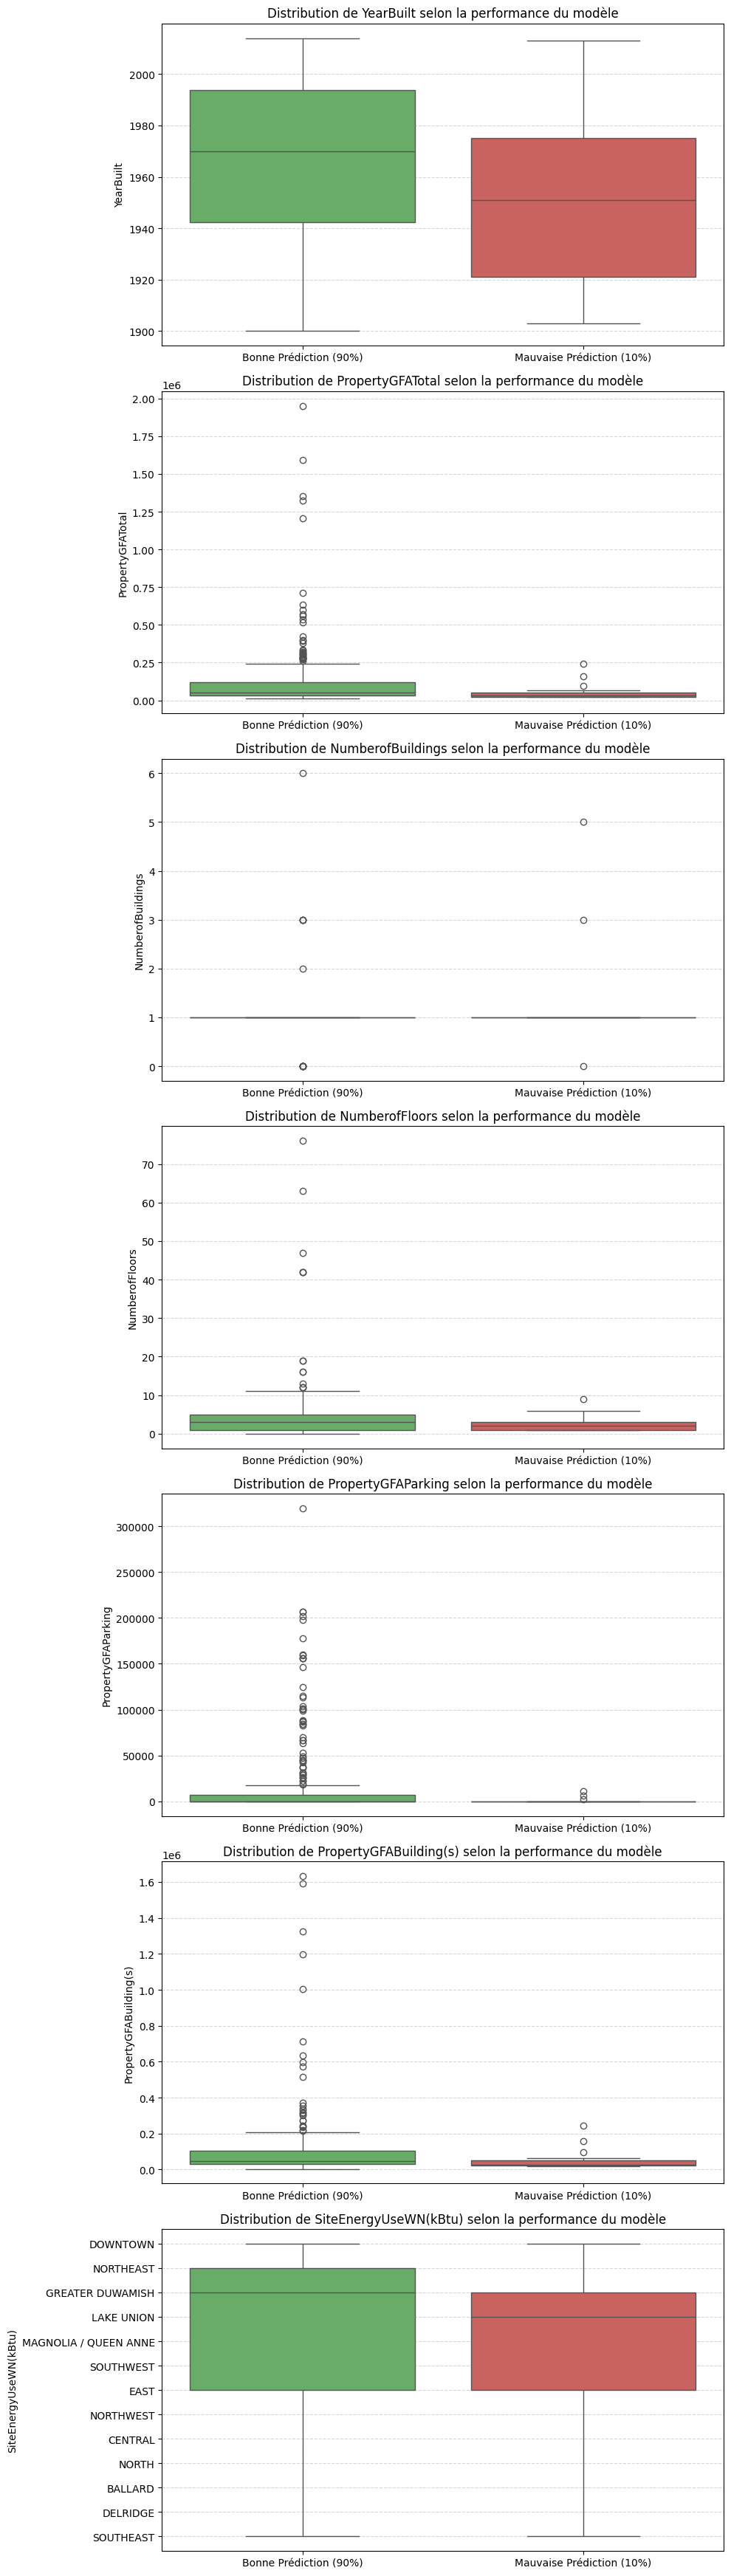

In [130]:
# Colonnes numériques à analyser
columns_cibles = [
    'YearBuilt',
    'PropertyGFATotal',
    'NumberofBuildings',
    'NumberofFloors',
    'PropertyGFAParking',
    'PropertyGFABuilding(s)',
    'SiteEnergyUseWN(kBtu)'
]

performance_col = "Performance_Modele"
order_perf = ['Bonne Prédiction (90%)', 'Mauvaise Prédiction (10%)']

# Filtrer uniquement les lignes classées 90% / 10%
df_plot = df_combined[df_combined[performance_col].isin(order_perf)].copy()

fig, axes = plt.subplots(len(columns_cibles), 1, figsize=(10, 5 * len(columns_cibles)))
if len(columns_cibles) == 1:
    axes = [axes]  

# Tracer un boxplot pour chaque colonne
for ax, col in zip(axes, columns_cibles):
    sns.boxplot(
        data=df_plot,
        x=performance_col,
        y=col,
        hue=performance_col,
        order=order_perf,
        palette=['#5cb85c', '#d9534f'],
        ax=ax
    )
    ax.set_title(f"Distribution de {col} selon la performance du modèle")
    ax.set_xlabel("")
    ax.set_ylabel(col)
    ax.grid(axis="y", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

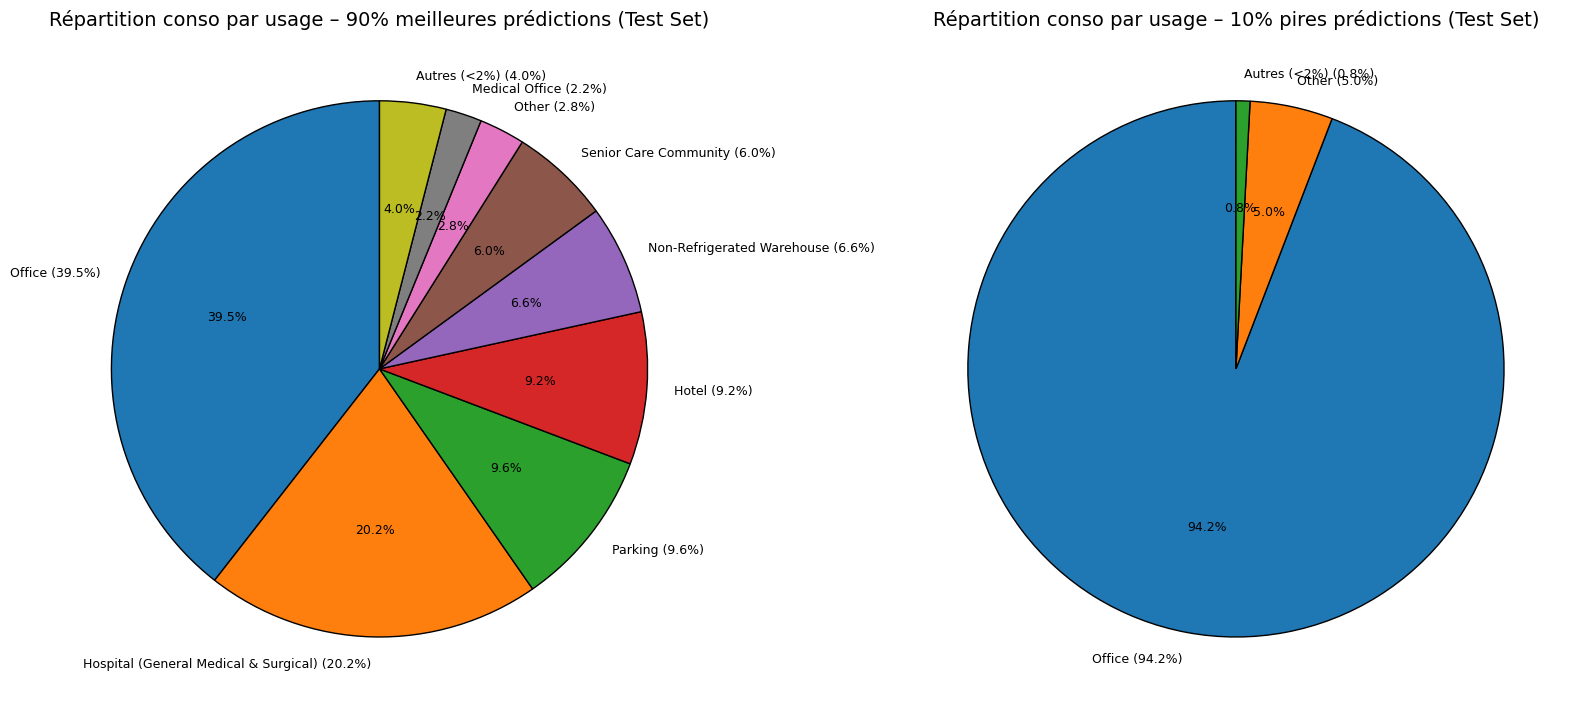

In [131]:
# Définition des colonnes
largest_use_col = 'LargestPropertyUseType'
conso_col = 'SiteEnergyUseWN(kBtu)'

# Ajout de LargestPropertyUseType et consommation réelle
df_resultats_test[largest_use_col] = X_test[largest_use_col]
df_resultats_test["Consommation_reel"] = y_test 

# Calcul du seuil des 90% meilleures prédictions
seuil_90 = df_resultats_test["erreur_pourcentage"].quantile(0.90)
df_90 = df_resultats_test[df_resultats_test["erreur_pourcentage"] <= seuil_90].copy()
df_10 = df_resultats_test[df_resultats_test["erreur_pourcentage"] > seuil_90].copy()


# Calcul des pourcentages par type d'usage
freq_90 = df_90.groupby(largest_use_col)["Consommation_reel"].sum()
freq_90 = 100 * freq_90 / freq_90.sum()
freq_90 = freq_90.sort_values(ascending=False)

# Regrouper les petites catégories (<2%)
main_90 = freq_90[freq_90 >= 2]
autres_90 = freq_90[freq_90 < 2].sum()
if autres_90 > 0:
    main_90[f"Autres (<2%)"] = autres_90


labels_90 = [f"{cat} ({val:.1f}%)" for cat, val in main_90.items()]
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.pie(
    main_90.values,
    labels=labels_90,
    startangle=90,
    wedgeprops={'edgecolor': 'black'},
    textprops={'fontsize': 9},
    autopct='%.1f%%'
)
plt.title("Répartition conso par usage – 90% meilleures prédictions (Test Set)", fontsize=14)

# --- Tracé du second camembert (10% pires prédictions) ---
freq_10 = df_10.groupby(largest_use_col)["Consommation_reel"].sum()
freq_10 = 100 * freq_10 / freq_10.sum()
freq_10 = freq_10.sort_values(ascending=False)

main_10 = freq_10[freq_10 >= 2]
autres_10 = freq_10[freq_10 < 2].sum()
if autres_10 > 0:
    main_10[f"Autres (<2%)"] = autres_10

labels_10 = [f"{cat} ({val:.1f}%)" for cat, val in main_10.items()]
plt.subplot(1, 2, 2)
plt.pie(
    main_10.values,
    labels=labels_10,
    startangle=90,
    wedgeprops={'edgecolor': 'black'},
    textprops={'fontsize': 9},
    autopct='%.1f%%'
)
plt.title("Répartition conso par usage – 10% pires prédictions (Test Set)", fontsize=14)

plt.tight_layout()
plt.show()


##### Graphique de comparaison entre Y-reel et Y-predict

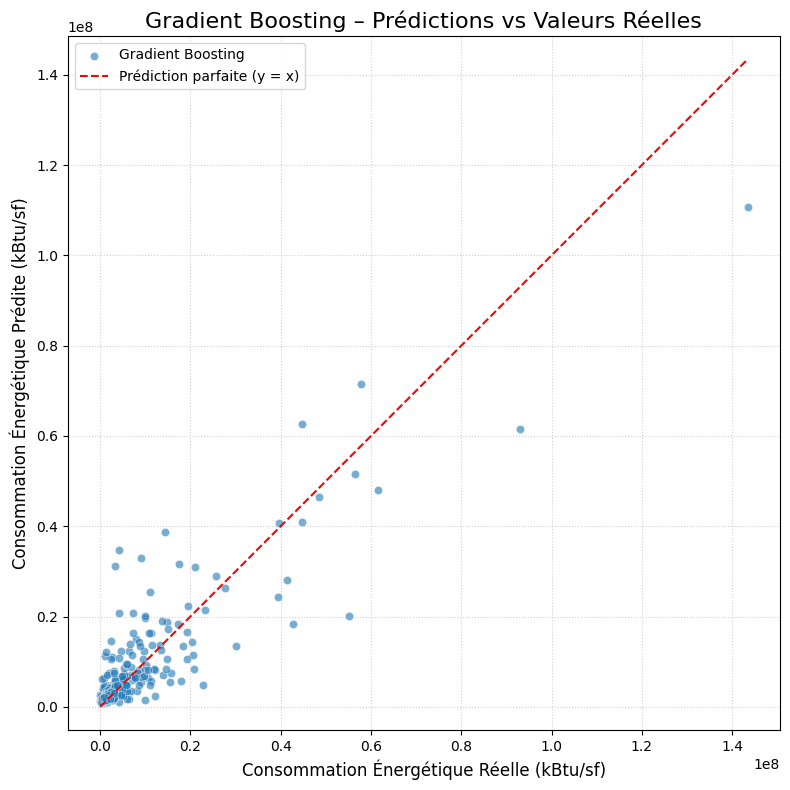

In [132]:
y_reel = y_test
y_pred_gb = pipeline_gbr.predict(X_test)

plt.figure(figsize=(8, 8))

sns.scatterplot(
    x=y_reel,
    y=y_pred_gb,
    alpha=0.6,
    edgecolor='w',
    label="Gradient Boosting"
)

# Droite parfaite y = x
max_val = max(y_reel.max(), y_pred_gb.max())
min_val = min(y_reel.min(), y_pred_gb.min())

plt.plot(
    [min_val, max_val],
    [min_val, max_val],
    color='red',
    linestyle='--',
    label='Prédiction parfaite (y = x)'
)

plt.title("Gradient Boosting – Prédictions vs Valeurs Réelles", fontsize=16)
plt.xlabel("Consommation Énergétique Réelle (kBtu/sf)", fontsize=12)
plt.ylabel("Consommation Énergétique Prédite (kBtu/sf)", fontsize=12)

plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.axis('equal')
plt.tight_layout()
plt.show()


#### Modèle RandomForest

##### Pipeline de RandomForest

In [133]:
rf_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=3,
    max_features="sqrt",
    n_jobs=-1,
    random_state=42
)
pipeline_rf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", rf_model)
])

models = {
    "Random Forest": pipeline_rf,
}


results = []

for name, model in models.items():
    print(f"Entraînement de : {name}...")
    res = train_and_evaluate_model(
        model=model, 
        X=X, 
        y=y, 
        model_name=name
    )
    results.append(res)

df_results = pd.DataFrame(results)

df_results = df_results.sort_values(by='R2 CV', ascending=False)
df_results

Entraînement de : Random Forest...


Modèle     R2 CV        MAE CV        MSE CV       RMSE CV
0  Random Forest  0.455796  4.438487e+06  1.834590e+14  1.142910e+07

##### Calcul du R²

**Le R² étant assez proche de 0.5, le modèle n'est pas mauvais, mais le résultat étant inférieur à celui de Grandient Boost, on priviligera le premier pour notre projet.**

In [134]:
scoring = {
    'r2': 'r2',
    'rmse': 'neg_root_mean_squared_error',
    'mae': 'neg_mean_absolute_error'
}

cv_results = cross_validate(
    estimator=pipeline_rf,
    X=X,
    y=y,
    cv=5,
    scoring=scoring,
    return_train_score=True,
    n_jobs=-1
)
cv_df = pd.DataFrame({
    'R2_train': cv_results['train_r2'],
    'R2_test': cv_results['test_r2'],
    'RMSE_test': -cv_results['test_rmse'],
    'MAE_test': -cv_results['test_mae']
})

cv_df.mean()

R2_train     6.327078e-01
R2_test      4.557958e-01
RMSE_test    1.142910e+07
MAE_test     4.438487e+06
dtype: float64

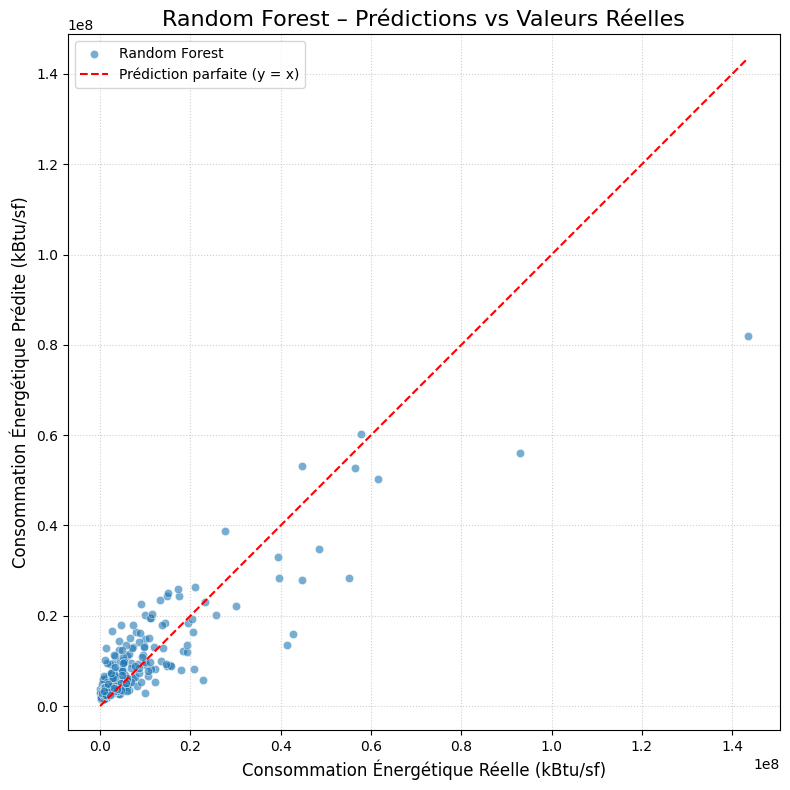

In [135]:
y_reel = y_test
y_pred_rf = pipeline_rf.predict(X_test)

plt.figure(figsize=(8, 8))

sns.scatterplot(
    x=y_reel,
    y=y_pred_rf,
    alpha=0.6,
    edgecolor='w',
    label="Random Forest"
)

# Droite parfaite y = x
max_val = max(y_reel.max(), y_pred_rf.max())
min_val = min(y_reel.min(), y_pred_rf.min())

plt.plot(
    [min_val, max_val],
    [min_val, max_val],
    color='red',
    linestyle='--',
    label='Prédiction parfaite (y = x)'
)

plt.title("Random Forest – Prédictions vs Valeurs Réelles", fontsize=16)
plt.xlabel("Consommation Énergétique Réelle (kBtu/sf)", fontsize=12)
plt.ylabel("Consommation Énergétique Prédite (kBtu/sf)", fontsize=12)

plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.axis('equal')
plt.tight_layout()
plt.show()

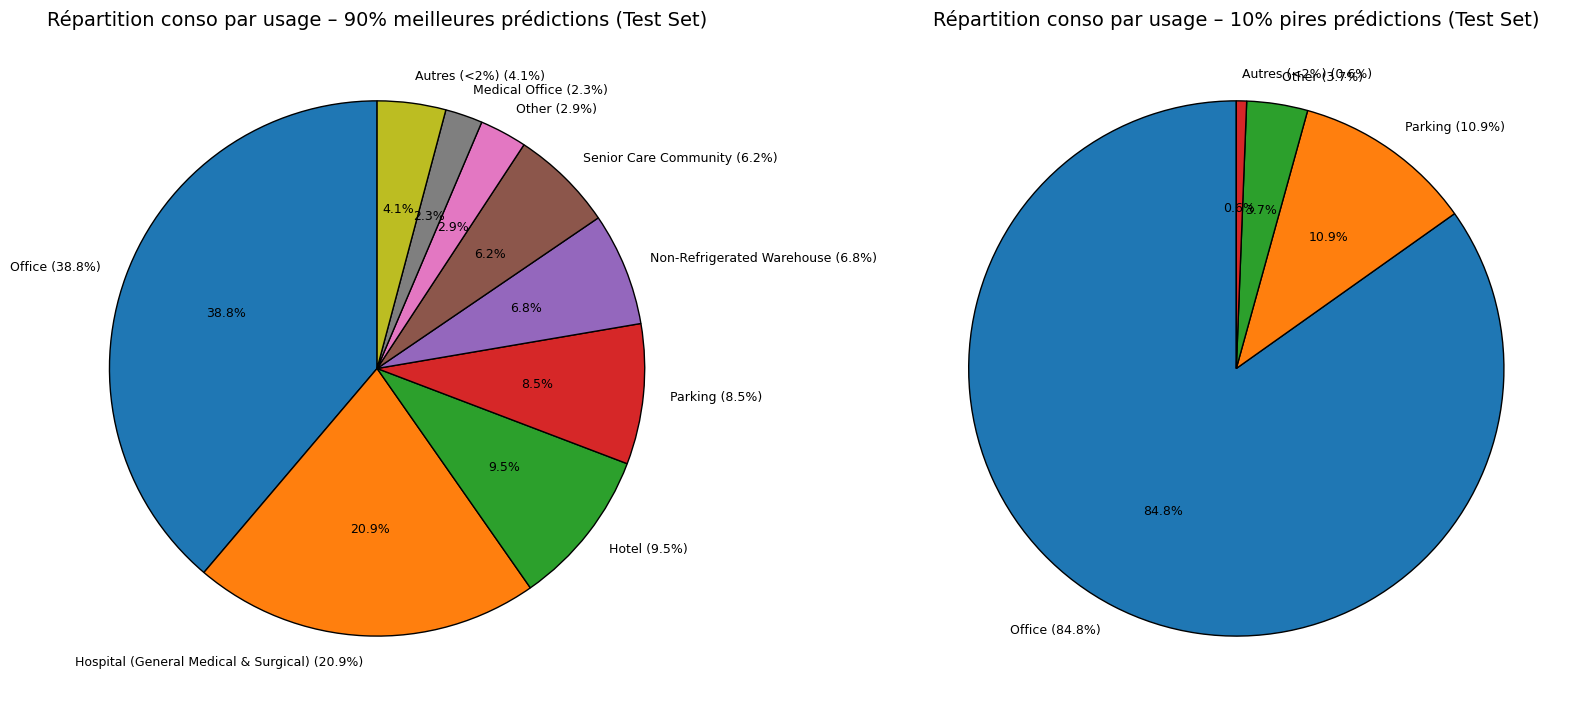

In [136]:
# Définition des colonnes
largest_use_col = 'LargestPropertyUseType'
conso_col = 'SiteEnergyUseWN(kBtu)'

df_resultats_test = pd.DataFrame({
    # y_test contient les vraies valeurs du jeu de test (la vérité terrain)
    'y_reel': y_test.values,
    
    # y_prediction_test contient les prédictions correspondantes du jeu de test
    'y_pred_rf': y_pred_rf,
})

df_resultats_test['erreur_pourcentage'] = (
    np.abs(df_resultats_test['y_reel'] - df_resultats_test['y_pred_rf']) / df_resultats_test['y_reel']
) * 100
# Ajout de LargestPropertyUseType et consommation réelle
df_resultats_test[largest_use_col] = X_test[largest_use_col]
df_resultats_test["Consommation_reel"] = y_test 

# Calcul du seuil des 90% meilleures prédictions
seuil_90 = df_resultats_test["erreur_pourcentage"].quantile(0.90)
df_90 = df_resultats_test[df_resultats_test["erreur_pourcentage"] <= seuil_90].copy()
df_10 = df_resultats_test[df_resultats_test["erreur_pourcentage"] > seuil_90].copy()


# Calcul des pourcentages par type d'usage
freq_90 = df_90.groupby(largest_use_col)["Consommation_reel"].sum()
freq_90 = 100 * freq_90 / freq_90.sum()
freq_90 = freq_90.sort_values(ascending=False)

# Regrouper les petites catégories (<2%)
main_90 = freq_90[freq_90 >= 2]
autres_90 = freq_90[freq_90 < 2].sum()
if autres_90 > 0:
    main_90[f"Autres (<2%)"] = autres_90


labels_90 = [f"{cat} ({val:.1f}%)" for cat, val in main_90.items()]
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.pie(
    main_90.values,
    labels=labels_90,
    startangle=90,
    wedgeprops={'edgecolor': 'black'},
    textprops={'fontsize': 9},
    autopct='%.1f%%'
)
plt.title("Répartition conso par usage – 90% meilleures prédictions (Test Set)", fontsize=14)

# --- Tracé du second camembert (10% pires prédictions) ---
freq_10 = df_10.groupby(largest_use_col)["Consommation_reel"].sum()
freq_10 = 100 * freq_10 / freq_10.sum()
freq_10 = freq_10.sort_values(ascending=False)

main_10 = freq_10[freq_10 >= 2]
autres_10 = freq_10[freq_10 < 2].sum()
if autres_10 > 0:
    main_10[f"Autres (<2%)"] = autres_10

labels_10 = [f"{cat} ({val:.1f}%)" for cat, val in main_10.items()]
plt.subplot(1, 2, 2)
plt.pie(
    main_10.values,
    labels=labels_10,
    startangle=90,
    wedgeprops={'edgecolor': 'black'},
    textprops={'fontsize': 9},
    autopct='%.1f%%'
)
plt.title("Répartition conso par usage – 10% pires prédictions (Test Set)", fontsize=14)

plt.tight_layout()
plt.show()

#### Comparaison de Random Forest et Gradient Boost

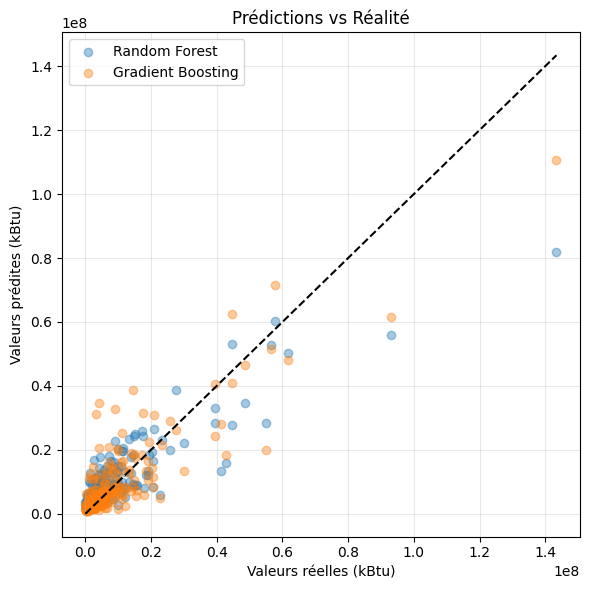

In [137]:
plt.figure(figsize=(6, 6))

plt.scatter(y_test, y_pred_rf, alpha=0.4, label="Random Forest")
plt.scatter(y_test, y_pred_gb, alpha=0.4, label="Gradient Boosting")

max_val = max(y_test.max(), y_pred_rf.max(), y_pred_gb.max())
plt.plot([0, max_val], [0, max_val], "--", color="black")

plt.xlabel("Valeurs réelles (kBtu)")
plt.ylabel("Valeurs prédites (kBtu)")
plt.title("Prédictions vs Réalité")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

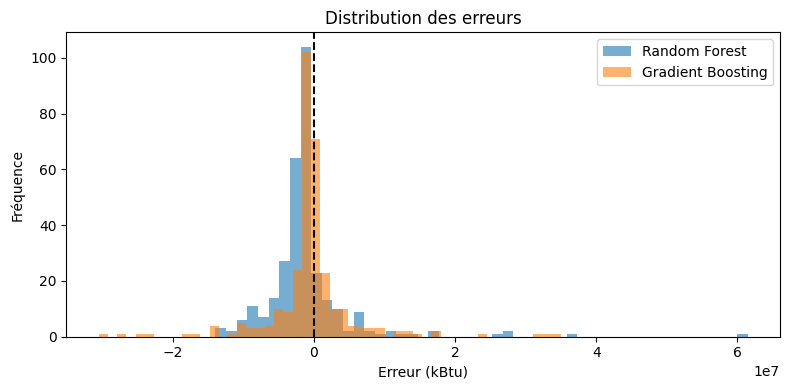

In [138]:
errors_rf = y_test - y_pred_rf
errors_gb = y_test - y_pred_gb

plt.figure(figsize=(8, 4))

plt.hist(errors_rf, bins=50, alpha=0.6, label="Random Forest")
plt.hist(errors_gb, bins=50, alpha=0.6, label="Gradient Boosting")

plt.axvline(0, color="black", linestyle="--")
plt.xlabel("Erreur (kBtu)")
plt.ylabel("Fréquence")
plt.title("Distribution des erreurs")
plt.legend()
plt.tight_layout()
plt.show()

#### Modèle SVR

##### Pipeline du modèle SVR

In [139]:
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns
categorical_features = X.select_dtypes(include=["object", "category"]).columns


preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)


pipeline_svr = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("svr", SVR(
        kernel='rbf',
        C=1,
        epsilon=0.1,
        gamma='scale'
    ))
])

models = {
    "SVR": pipeline_svr,
}


results = []

for name, model in models.items():
    print(f"Entraînement de : {name}...")
    res = train_and_evaluate_model(
        model=model, 
        X=X, 
        y=y, 
        model_name=name
    )
    results.append(res)

df_results = pd.DataFrame(results)

# 5. Tri et affichage
df_results = df_results.sort_values(by='R2 CV', ascending=False)
df_results

Entraînement de : SVR...


Modèle    R2 CV        MAE CV        MSE CV       RMSE CV
0    SVR -0.09263  6.674022e+06  3.782978e+14  1.645753e+07

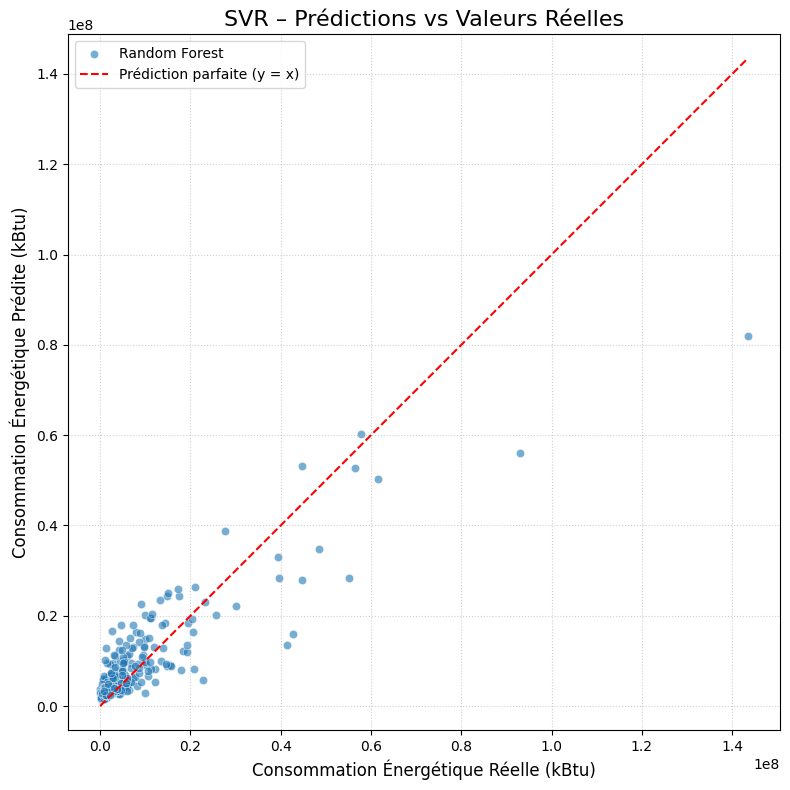

In [140]:
y_reel = y_test
y_pred_svr = pipeline_svr.predict(X_test)

plt.figure(figsize=(8, 8))

sns.scatterplot(
    x=y_reel,
    y=y_pred_rf,
    alpha=0.6,
    edgecolor='w',
    label="Random Forest"
)

# Droite parfaite y = x
max_val = max(y_reel.max(), y_pred_svr.max())
min_val = min(y_reel.min(), y_pred_svr.min())

plt.plot(
    [min_val, max_val],
    [min_val, max_val],
    color='red',
    linestyle='--',
    label='Prédiction parfaite (y = x)'
)

plt.title("SVR – Prédictions vs Valeurs Réelles", fontsize=16)
plt.xlabel("Consommation Énergétique Réelle (kBtu)", fontsize=12)
plt.ylabel("Consommation Énergétique Prédite (kBtu)", fontsize=12)

plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.axis('equal')
plt.tight_layout()
plt.show()

In [141]:
r2_lr  = r2_score(y_test, y_pred_lr)
r2_gbr  = r2_score(y_test, y_pred_gb)
r2_rf  = r2_score(y_test, y_pred_rf)
r2_svr = r2_score(y_test, y_pred_svr)

df_scores = pd.DataFrame({
    "Modèle": [
        "Régression Linéaire",
        "Gradient Boosting",
        "Random Forest",
        "SVR"
    ],
    "R²": [
        r2_score(y_test, y_pred_lr),
        r2_score(y_test, y_pred_gb),
        r2_score(y_test, y_pred_rf),
        r2_score(y_test, y_pred_svr)
    ]
}).sort_values("R²", ascending=False)

df_scores.style.format({"R²": "{:.4f}"})

Le modèle SVR étant sensible à l’échelle de la variable cible,
nous utilisons TransformedTargetRegressor afin de normaliser y
pendant l’apprentissage, puis de retransformer automatiquement
les prédictions dans l’unité originale.

- Ici, on ne touche PAS à X,  
- on normalise la variable cible y.  
  
**Pourquoi c’est nécessaire ?**  
  
SVR est :  
  
- très sensible à l’échelle  
  
- optimisé par des distances  
  
- basé sur des marges (epsilon)  
  
Si *y* est :  
  
- très grande (ex : kBtu)  
  
- très dispersée  
  
- asymétrique  
  
alors :  **le SVR apprend mal ou converge mal**.

In [142]:
model_svr_scaled = TransformedTargetRegressor(
    regressor=pipeline_svr, 
    transformer=StandardScaler() # Normalise y pendant le fit
)

In [143]:
models = {
    "SVR_scaled": model_svr_scaled}


results = []


for name, model in models.items():
    print(f"Entraînement de : {name}...")
    res = train_and_evaluate_model(
        model=model, 
        X=X, 
        y=y, 
        model_name=name
    )
    results.append(res)


df_results = pd.DataFrame(results)


df_results = df_results.sort_values(by='R2 CV', ascending=False)
df_results

Entraînement de : SVR_scaled...


Modèle     R2 CV        MAE CV        MSE CV       RMSE CV
0  SVR_scaled  0.311075  4.320145e+06  2.446159e+14  1.307266e+07

*Le R² est maintenant positif*

##### Graphique d'anlayse de Y-reel et Y-predict

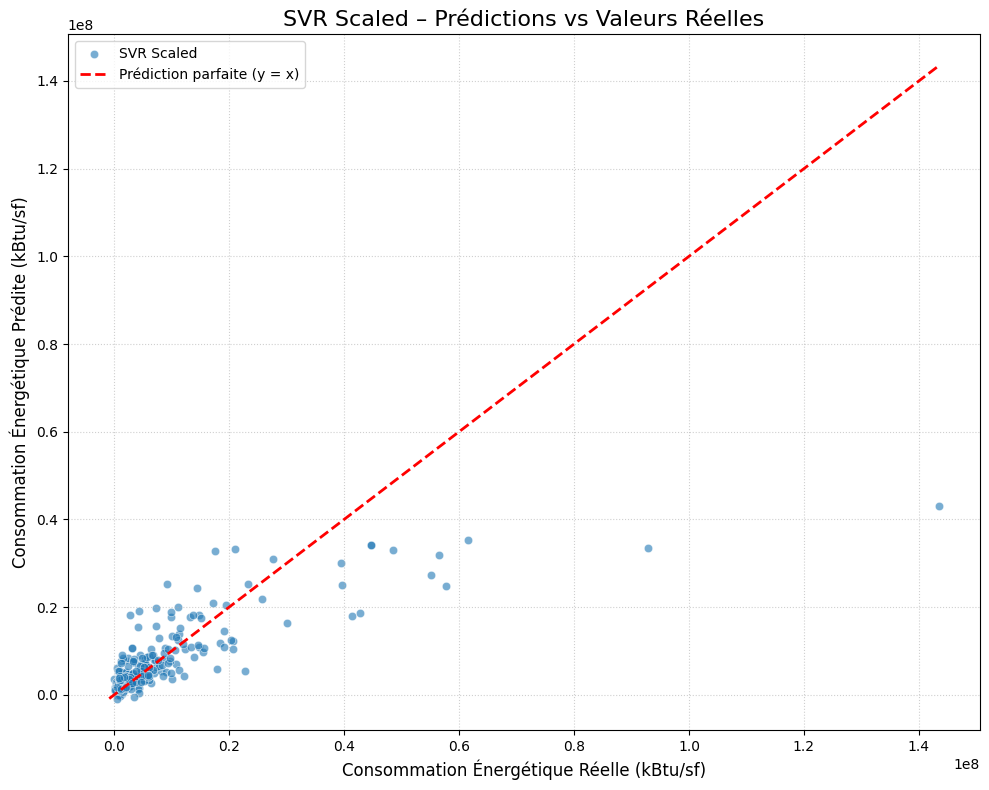

In [144]:
model_svr_scaled.fit(X_train, y_train)


# TransformedTargetRegressor s'occupe tout seul de "dé-normaliser" 
# pour revenir à l'unité d'origine (kBtu/sf)
y_pred_scaled = model_svr_scaled.predict(X_test)

plt.figure(figsize=(10, 8))

sns.scatterplot(
    x=y_test, 
    y=y_pred_scaled, 
    alpha=0.6, 
    edgecolor='w', 
    label="SVR Scaled"
)


all_values = np.concatenate([y_test, y_pred_scaled])
min_val, max_val = all_values.min(), all_values.max()

plt.plot(
    [min_val, max_val], 
    [min_val, max_val], 
    color='red', 
    linestyle='--', 
    linewidth=2,
    label='Prédiction parfaite (y = x)'
)

plt.title("SVR Scaled – Prédictions vs Valeurs Réelles", fontsize=16)
plt.xlabel("Consommation Énergétique Réelle (kBtu/sf)", fontsize=12)
plt.ylabel("Consommation Énergétique Prédite (kBtu/sf)", fontsize=12)

plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()

Le fait d'utiliser TransformTargetRegressor permet d'avoir un modèle mieux adapté pour notre projet.

#### Graphique de comparaison des 4 modèles

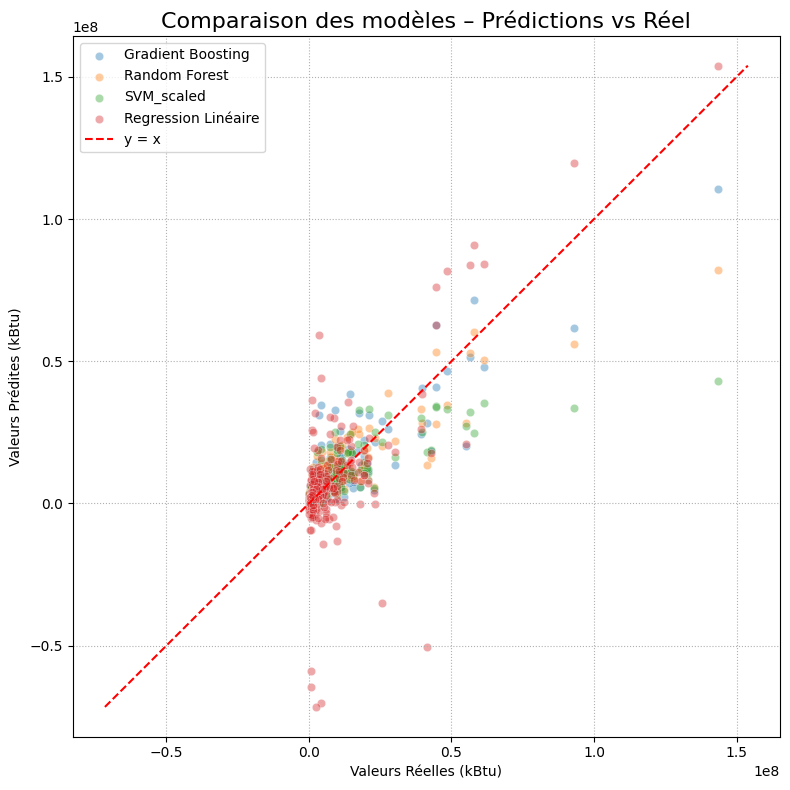

In [145]:
plt.figure(figsize=(8, 8))

sns.scatterplot(x=y_test, y=y_pred_gb, alpha=0.4, label="Gradient Boosting")
sns.scatterplot(x=y_test, y=y_pred_rf, alpha=0.4, label="Random Forest")
sns.scatterplot(x=y_test, y=y_pred_scaled, alpha=0.4, label="SVM_scaled")
sns.scatterplot(x=y_test, y=y_pred_lr, alpha=0.4, label="Regression Linéaire")

# Droite parfaite
max_val = max(y_test.max(), y_pred_gb.max(), y_pred_rf.max(), y_pred_scaled.max(), y_pred_lr.max())
min_val = min(y_test.min(), y_pred_gb.min(), y_pred_rf.min(), y_pred_scaled.min(), y_pred_lr.min())

plt.plot([min_val, max_val], [min_val, max_val], 'r--', label="y = x")

plt.title("Comparaison des modèles – Prédictions vs Réel", fontsize=16)
plt.xlabel("Valeurs Réelles (kBtu)")
plt.ylabel("Valeurs Prédites (kBtu)")
plt.legend()
plt.grid(True, linestyle=":")
plt.axis("equal")
plt.tight_layout()
plt.show()

#### Comparaison des R² en fonction des modèles

In [146]:
r2_lr  = r2_score(y_test, y_pred_lr)
r2_gbr  = r2_score(y_test, y_pred_gb)
r2_rf  = r2_score(y_test, y_pred_rf)
r2_svr = r2_score(y_test, y_pred_scaled)

df_scores = pd.DataFrame({
    "Modèle": [
        "Régression Linéaire",
        "Gradient Boosting",
        "Random Forest",
        "SVR_scaled"
    ],
    "R²": [
        r2_score(y_test, y_pred_lr),
        r2_score(y_test, y_pred_gb),
        r2_score(y_test, y_pred_rf),
        r2_score(y_test, y_pred_scaled)
    ]
}).sort_values("R²", ascending=False)

df_scores.style.format({"R²": "{:.4f}"})

In [147]:
results = []

models = {
    "Régression Linéaire": pipeline,
    "Gradient Boosting": pipeline_gbr,
    "Random Forest": pipeline_rf,
    "SVR_scaled": model_svr_scaled
}


for name, model in models.items():
    cv = cross_validate(
        estimator=model,
        X=X,
        y=y,
        cv=5,
        scoring=scoring,
        return_train_score=True,
        n_jobs=-1
    )

    results.append({
        "Modèle": name,
        "R2 Train (CV)": cv['train_r2'].mean(),
        "R2 Test (CV)": cv['test_r2'].mean(),
        "RMSE Test": -cv['test_rmse'].mean(),
        "MAE Test": -cv['test_mae'].mean()
    })

df_models_comparison = pd.DataFrame(results)

df_models_comparison.sort_values(
    by="R2 Test (CV)",
    ascending=False
)

Modèle  R2 Train (CV)  R2 Test (CV)     RMSE Test  \
1    Gradient Boosting       0.981673      0.613052  9.312583e+06   
2        Random Forest       0.632708      0.455796  1.142910e+07   
3           SVR_scaled       0.505611      0.311075  1.307266e+07   
0  Régression Linéaire       0.890664     -0.488602  1.445987e+07   

       MAE Test  
1  3.612826e+06  
2  4.438487e+06  
3  4.320145e+06  
0  6.391177e+06

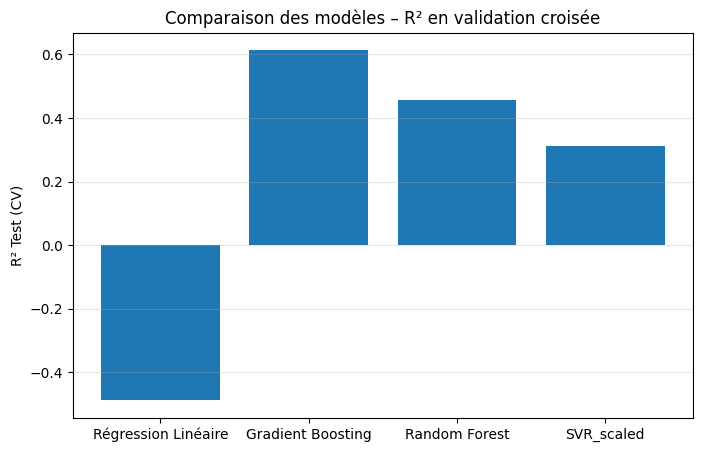

In [148]:
plt.figure(figsize=(8,5))
plt.bar(
    df_models_comparison["Modèle"],
    df_models_comparison["R2 Test (CV)"]
)

plt.title("Comparaison des modèles – R² en validation croisée")
plt.ylabel("R² Test (CV)")
plt.grid(axis='y', alpha=0.3)
plt.show()

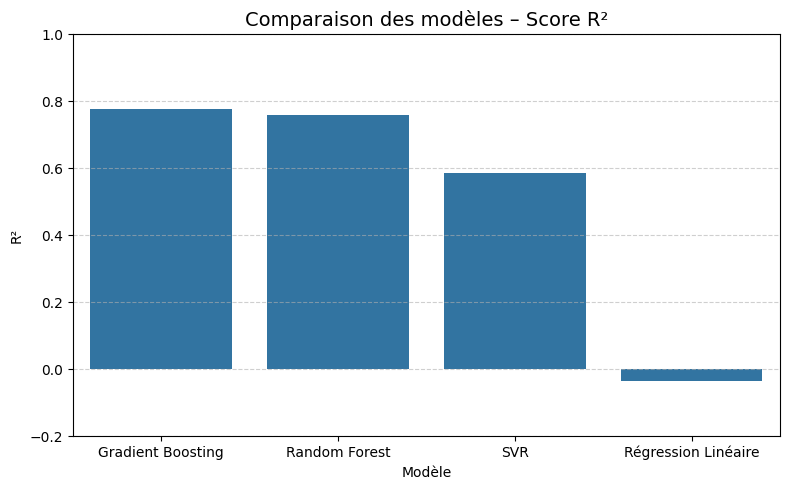

In [149]:
r2_scores = {
    "Régression Linéaire": r2_lr,
    "Gradient Boosting": r2_gbr,
    "Random Forest": r2_rf,
    "SVR": r2_svr
}

df_scores = pd.DataFrame.from_dict(
    r2_scores,
    orient="index",
    columns=["R²"]
).sort_values("R²", ascending=False)

plt.figure(figsize=(8, 5))

sns.barplot(
    x=df_scores.index,
    y=df_scores["R²"]
)

plt.title("Comparaison des modèles – Score R²", fontsize=14)
plt.ylabel("R²")
plt.xlabel("Modèle")
plt.ylim(-0.2, 1)
plt.grid(axis="y", linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()

Plusieurs modèles de régression ont été évalués :  
- Régression linéaire  
- Support Vector Regression (SVR)  
- Random Forest  
- Gradient Boosting  

*Objectif :*  
  
Comparer des modèles linéaires vs non-linéaires
  
Identifier la famille la plus adaptée à la complexité du problème

Les performances sont synthétisées dans un tableau comparatif multi-modèles.  

Le **Gradient Boosting** se distingue par :  

- Un R² CV supérieur  

- Un bon compromis biais / variance  

- Une meilleure stabilité que Random Forest  


#### Création des hyperparamètres et du pipeline

In [150]:
param_grid = {
    'regressor__n_estimators': [500,600,700], # Nombre total d’arbres dans le modèle.
    'regressor__learning_rate': [ 0.07,0.08, 0.1],  # Le learning rate contrôle le poids de chaque arbre ajouté au modèle.
    'regressor__max_depth': [2,3,4] # Contrôle la profondeur maximale des arbres.
}

In [151]:
numeric_columns = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_columns = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

# Création du preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ],
    remainder='drop'
)

#  Création du pipeline
full_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(random_state=42))
])


#### GridSearch

Une GridSearch a été réalisée afin d’optimiser les hyperparamètres clés du Gradient Boosting.  
Hyperparamètres optimisés :  
  
- *n_estimators* : nombre d’arbres  

- *learning_rate* : contribution de chaque arbre  

- *max_depth* : complexité des arbres  
  
Une GridSearch volontairement restreinte a été utilisée afin de :  
  
- Limiter le coût de calcul  
  
- Éviter le sur-ajustement  
  
- Favoriser la généralisabilité  

Le R² est utilisé comme métrique de scoring pour la GridSearch car il est
indépendant de l’échelle de la variable cible et permet une comparaison
plus stable entre les différents folds de validation croisée.
Les métriques MAE et RMSE sont ensuite utilisées pour interpréter
l’erreur du modèle en unité réelle.


In [152]:
#Création de la GridSearch
grid_search = GridSearchCV(
    full_pipeline, 
    param_grid, 
    cv=5, 
    scoring='r2',
    n_jobs=-1,
    verbose=1 
)

grid_search.fit(X_train, y_train)

print(f"Meilleurs paramètres : {grid_search.best_params_}")

y_pred = grid_search.predict(X_test)
r2_train = grid_search.score(X_train, y_train)
r2_test = grid_search.score(X_test, y_test)
print(f"R2 Train: {r2_train:.4f}")
print(f"R2 Test: {r2_test:.4f}")
print(f"R2 Train -R2 Test: {(r2_train-r2_test):.4f}")

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Meilleurs paramètres : {'regressor__learning_rate': 0.08, 'regressor__max_depth': 3, 'regressor__n_estimators': 500}
R2 Train: 0.9854
R2 Test: 0.7504
R2 Train -R2 Test: 0.2350


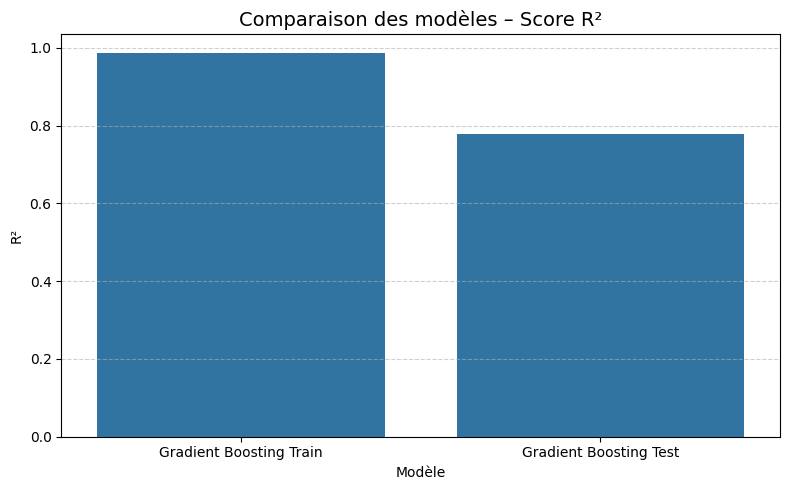

In [153]:
r2_scores = {
    "Gradient Boosting Train": r2_train,
    "Gradient Boosting Test": r2_gbr,
}

df_scores = pd.DataFrame.from_dict(
    r2_scores,
    orient="index",
    columns=["R²"]
).sort_values("R²", ascending=False)

plt.figure(figsize=(8, 5))

sns.barplot(
    x=df_scores.index,
    y=df_scores["R²"]
)

plt.title("Comparaison des modèles – Score R²", fontsize=14)
plt.ylabel("R²")
plt.xlabel("Modèle")
plt.grid(axis="y", linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()

On remarque qu'il y a beaucoup d'**Overfitting**, nous allons donc crée une nouvelle grille de paramètres, en ajustant ceux déjà choisis & en rajoutant deux autres.

In [154]:
param_grid = {
    'regressor__learning_rate': [0.01, 0.015],  # Le learning rate contrôle le poids de chaque arbre ajouté au modèle.
    'regressor__max_depth': [ 4, 5],  # Contrôle la profondeur maximale des arbres.
    'regressor__min_samples_leaf': [5,10,15],  # Nombre minimum d’observations dans une feuille terminale.
    'regressor__n_estimators': [500, 700, 900], # Nombre total d’arbres dans le modèle.
    'regressor__subsample': [0.7,0.8], # Proportion d’échantillons utilisés pour entraîner chaque arbre.
    'regressor__max_features': ['sqrt', 0.3,0.5] # Nombre de variables testées à chaque split.
}


**Pourquoi cette grille ?**  
  

*Elle agit sur 3 leviers anti-overfitting majeurs :*  
  
- Complexité des arbres  
  
- Bruit statistique  
  
- Régularisation implicite  

Elle reste :  
  
- Réalisable en temps de calcul  

- Interprétable  


In [155]:

# Création du preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ],
    remainder='drop'
)

# 4. Création du pipeline
full_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(random_state=42))
])

#Création de la GridSearch
grid_search = GridSearchCV(
    full_pipeline, 
    param_grid, 
    cv=5, 
    scoring='r2',
    n_jobs=-1, 
    verbose=1 
)

grid_search.fit(X_train, y_train)

print(f"Meilleurs paramètres : {grid_search.best_params_}")

y_pred = grid_search.predict(X_test)
r2_train = grid_search.score(X_train, y_train)
r2_test = grid_search.score(X_test, y_test)
print(f"R2 Train: {r2_train:.4f}")
print(f"R2 Test: {r2_test:.4f}")

print(f"R2 Train -R2 Test: {(r2_train-r2_test):.4f}")

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Meilleurs paramètres : {'regressor__learning_rate': 0.01, 'regressor__max_depth': 5, 'regressor__max_features': 0.3, 'regressor__min_samples_leaf': 5, 'regressor__n_estimators': 500, 'regressor__subsample': 0.7}
R2 Train: 0.8538
R2 Test: 0.7976
R2 Train -R2 Test: 0.0562


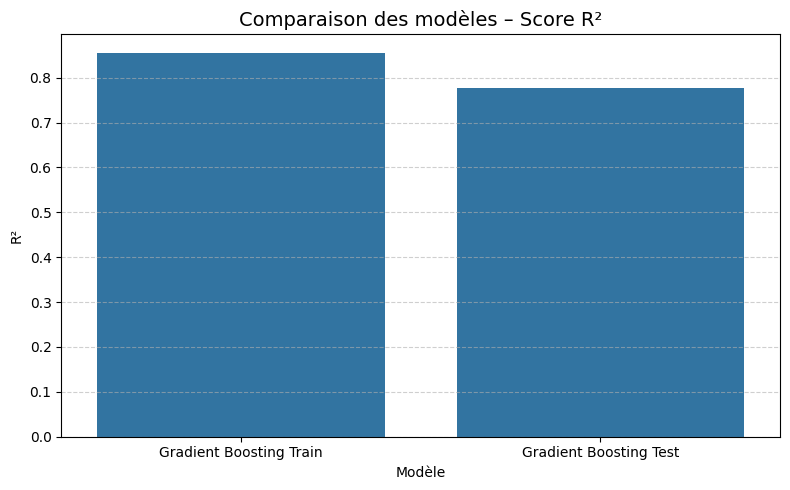

In [156]:
r2_scores = {
    "Gradient Boosting Train": r2_train,
    "Gradient Boosting Test": r2_gbr,
}

df_scores = pd.DataFrame.from_dict(
    r2_scores,
    orient="index",
    columns=["R²"]
).sort_values("R²", ascending=False)

plt.figure(figsize=(8, 5))

sns.barplot(
    x=df_scores.index,
    y=df_scores["R²"]
)

plt.title("Comparaison des modèles – Score R²", fontsize=14)
plt.ylabel("R²")
plt.xlabel("Modèle")
plt.grid(axis="y", linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()

**Interprétation**  

- La performance sur le jeu de test est légèrement meilleure  
  
- La différence est quasi nulle  

- Pas de chute de performance


Le modèle **Gradient Boosting** optimisé présente une excellente capacité de généralisation. Avec un $R^2$ Test de **0.80** et un écart maîtrisé de seulement **5,6%** par rapport au score d'entraînement, le modèle démontre une grande stabilité. Cette absence d'overfitting significatif confirme que les hyperparamètres de régularisation choisis (profondeur limitée et taille de feuilles minimale) sont pertinents, rendant le modèle robuste et fiable pour prédire la consommation de bâtiments qu'il n'a jamais rencontrés.

In [157]:
# 1. On récupère le meilleur estimateur (le pipeline complet optimisé)
best_model = grid_search.best_estimator_

# 2. Maintenant on peut calculer les scores de validation croisée
mae_cv = -cross_val_score(
    best_model, 
    X, 
    y, 
    scoring="neg_mean_absolute_error", 
    cv=5,
    n_jobs=-1
).mean()

rmse_cv = -cross_val_score(
    best_model, 
    X, 
    y, 
    scoring="neg_root_mean_squared_error", 
    cv=5,
    n_jobs=-1
).mean()

print(f"MAE CV  : {mae_cv:.2f}")
print(f"RMSE CV : {rmse_cv:.2f}")

MAE CV  : 3938070.57
RMSE CV : 10010879.95


In [158]:
# 1. Calcul de la MAPE (Erreur moyenne en %)
mape = mean_absolute_percentage_error(y_test, y_pred)

# 2. Calcul de l'erreur relative médiane (plus robuste aux outliers)
relative_error = abs(y_test - y_pred) / y_test
median_relative_error = relative_error.median()

print(f"MAPE (Erreur moyenne relative) : {mape:.2%}")
print(f"Erreur relative médiane : {median_relative_error:.2%}")

MAPE (Erreur moyenne relative) : 180.86%
Erreur relative médiane : 52.13%


- **Capacité Prédictive**  
GlobaleLe modèle Gradient Boosting Regressor optimisé atteint un score $R^2$ de *0,80* sur le jeu de test. Cela signifie que le modèle parvient à expliquer 80 % de la variance de la consommation énergétique des bâtiments. L'écart entre le score d'entraînement (0,85) et le score de test (0,80) est de seulement *5,6 %*, ce qui démontre une excellente généralisation et une absence de sur-apprentissage (overfitting)
- **Analyse de la Précision et des Écarts**  
L'analyse des erreurs relatives apporte une nuance importante sur la nature des données :
*Erreur Relative Médiane (52,13 %)* : Pour la moitié du parc immobilier, le modèle prédit la consommation avec une erreur de ± 52 %. Bien que ce chiffre puisse paraître élevé, il est cohérent avec la grande hétérogénéité des bâtiments de Seattle (usages, isolation, vétusté).  
*MAPE (180,86 %)* : Cette erreur moyenne très élevée est symptomatique d'une distribution "asymétrique". Elle est fortement impactée par les bâtiments à très faible consommation, où un petit écart de prédiction se traduit mathématiquement par un pourcentage d'erreur immense.  

#### Features importances

Les modèles de Gradient Boosting permettent d’extraire directement l’importance des variables.

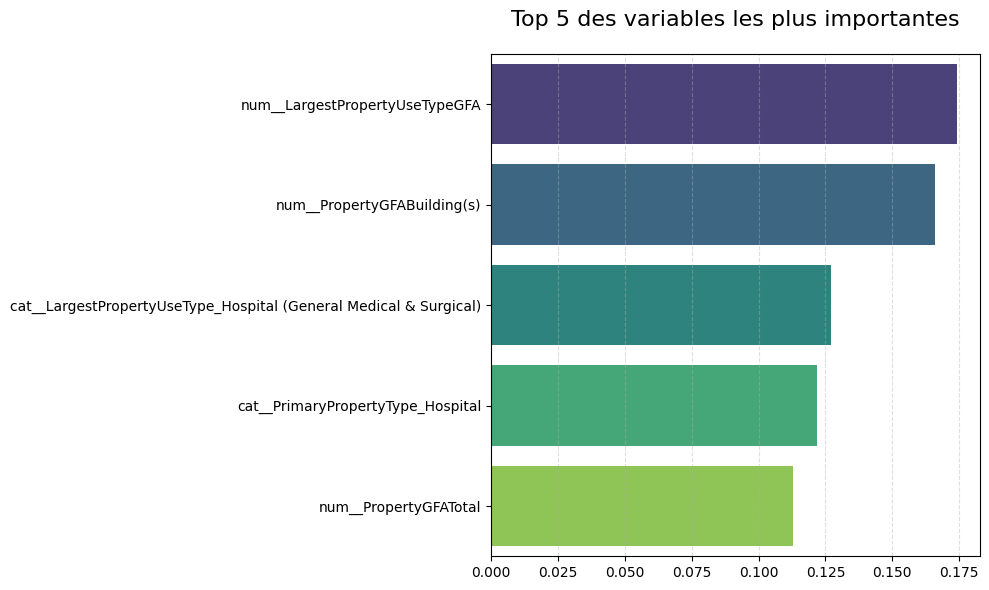

In [159]:
# 1. Extraire le modèle et le préprocesseur
best_pipeline = grid_search.best_estimator_
model = best_pipeline.named_steps['regressor']
preprocessor = best_pipeline.named_steps['preprocessor']

# 2. Récupérer les noms des colonnes après encodage
feature_names = preprocessor.get_feature_names_out()

# 3. Créer un DataFrame des importances
importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))

sns.barplot(
    x='Importance', 
    y='Feature', 
    data=importances.head(5), 
    hue='Feature',
    palette='viridis', 
    legend=False
)

plt.title('Top 5 des variables les plus importantes', fontsize=16, pad=20)
plt.xlabel(None) 
plt.ylabel(None)

plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

Les résultats montrent que les variables liées à :  
  
- La surface du plus grand type d'usage (GFA),  

- La surface totale des bâtiments construits (GFA Buildings)

- Les bâtiments dont la plus grande surface est un Hôpital,

- Les bâtiments dont le premier usage est un Hôpital,  
  
- La surface totale du bâtiment,  
  
sont les principaux déterminants de la consommation énergétique.

##### Bâtiments les moins bien devinés

In [160]:
# 1. On ré-entraîne le meilleur modèle sur le train set
best_model = pipeline_gbr
best_model.fit(X_train, y_train)

# 2. On fait des prédictions sur le test set
y_pred = best_model.predict(X_test)

# 3. On crée un DF de comparaison
df_error = X_test.copy()
df_error['Vrai_Y'] = y_test
df_error['Pred_Y'] = y_pred
df_error['Erreur_Absolue'] = abs(y_test - y_pred)

# 4. On affiche les 10 lignes où le modèle s'est le plus trompé
top_outliers = df_error.sort_values(by='Erreur_Absolue', ascending=False).head(10)
print("--- Les 10 plus grosses erreurs du modèle ---")
top_outliers

--- Les 10 plus grosses erreurs du modèle ---


BuildingType    PrimaryPropertyType Neighborhood  YearBuilt  \
308   NonResidential     Mixed Use Property   LAKE UNION       2001   
167   NonResidential               Hospital      CENTRAL       1990   
559   NonResidential           Large Office     DOWNTOWN       1985   
305   NonResidential                  Other         EAST       1988   
3000  NonResidential                  Other         EAST       1975   
59    NonResidential  Senior Care Community    SOUTHWEST       1922   
298   NonResidential                  Other     DOWNTOWN       1985   
1328  NonResidential     Mixed Use Property   LAKE UNION       2008   
221   NonResidential           Large Office     DOWNTOWN       1983   
2522  NonResidential                  Other         EAST       1928   

      NumberofBuildings  NumberofFloors  PropertyGFATotal  PropertyGFAParking  \
308                 1.0               6            378443              177660   
167                 6.0               5            597519                   0   
559                 1.0              76           1952220              319400   
305                 1.0               9             46710                   0   
3000                5.0               2             38879               11328   
59                  1.0               5            217603                   0   
298                 1.0              12            193500               38000   
1328                1.0               4            274442                   0   
221                 1.0              47           1323055                   0   
2522                1.0               3             71280                   0   

      PropertyGFABuilding(s)                 LargestPropertyUseType  ...  \
308                   200783                                Parking  ...   
167                   597519  Hospital (General Medical & Surgical)  ...   
559                  1632820                                 Office  ...   
305                    46710    Urgent Care/Clinic/Other Outpatient  ...   
3000                   27551    Urgent Care/Clinic/Other Outpatient  ...   
59                    217603                  Senior Care Community  ...   
298                   155500                                  Other  ...   
1328                  274442                                  Hotel  ...   
221                  1323055                                 Office  ...   
2522                   71280                     Other - Recreation  ...   

     SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA  \
308                        Office                         214111.0   
167                       Parking                              0.0   
559                       Parking                         271283.0   
305                          None                              0.0   
3000                         None                              0.0   
59                        Parking                              0.0   
298                          None                              0.0   
1328                      Parking                         165679.0   
221                       Parking                         311920.0   
2522                         None                              0.0   

     ThirdLargestPropertyUseType  ThirdLargestPropertyUseTypeGFA DefaultData  \
308                  Data Center                             0.0       False   
167                         None                             0.0       False   
559                         None                             0.0       False   
305                         None                             0.0       False   
3000                        None                             0.0       False   
59                          None                             0.0       False   
298                         None                             0.0       False   
1328         Multifamily Housing                             0.0       False   
221   

On remarque que les bâtiments les moins bien devinés ont des problèmes au niveau des surface : un SecondLargestPropertyUseType ou un ThirdLargestPropertyUseType défini n'ont pas forcément de surface associée.

Le modèle **Gradient Boosting** avec la nouvelle GridSearch permet de prédire efficacement la consommation énergétique des bâtiments.  

**Forces du modèle :**
  
- Bonne capacité prédictive  

- Interprétabilité via feature importance  

- Robustesse validée par cross-validation  

**Axes d’amélioration :**

- Tester des modèles de boosting avancés (XGBoost, LightGBM)  

- Ajouter des variables climatiques ou temporelles  

- Travailler sur la segmentation des bâtiments  

In [165]:
import bentoml

best_model = grid_search.best_estimator_

bentoml.sklearn.save_model(
    "energy_gb_model",
    best_model,
    custom_objects={
        "features": X_train.columns.tolist()
    },
    metadata={
        "model_type": "GradientBoosting",
        "scoring": "r2"
    }
)


Model(tag="energy_gb_model:z44akwxgfoxokqa2", path="C:\Users\mcourte\AppData\Local\Temp\bentoml-model-energy_gb_model-l8aljexo")

In [166]:
!bentoml models list


 Tag                          Module           Size        Creation Time       
 energy_gb_model:z44akwxgfoâ€¦  bentoml.sklearn  876.84 KiB  2025-12-31 10:33:48 
 energy_gb_model:6ltslepgfkâ€¦  bentoml.sklearn  876.44 KiB  2025-12-31 10:27:38 


In [167]:
X.columns

Index(['BuildingType', 'PrimaryPropertyType', 'Neighborhood', 'YearBuilt',
       'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'LargestPropertyUseType', 'ListOfAllPropertyUseTypes',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType',
       'ThirdLargestPropertyUseTypeGFA', 'DefaultData', 'ComplianceStatus',
       'Outlier'],
      dtype='object')